<h1 align="center">IMPLEMENTASI DEEP LEARNING UNTUK SISTEM PENCARIAN GAMBAR PRODUK MENGGUNAKAN ALGORITMA CONVOLUTIONAL NEURAL NETWORK (CNN)</h1>

<p align="center">
   LAPORAN TUGAS AKHIR
</p>



<p align="center">
   Yogi Dwi Andrian
</p>

<p align="center">
   5180411123
</p>

<br/>

 




# **1. Mengimpor pustaka/modul python yang dibutuhkan**

In [ ]:
# Mengunduh pustaka
!pip install split-folders

In [ ]:
# I/O python
import os, shutil, glob, time

# Preproses data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
import numpy as np

# Untuk pembuatan model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from keras.models import Sequential, Model

# Transfer learning
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Visualisasi
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
from PIL import Image

# Evaluasi
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
# Menyambungkan ke GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **2. Menyiapkan Dataset**

## 2.1 Menyiapkan kredensial akun Kaggle

In [ ]:
# Sebelumnya unggah API kredensial dari kaggle yang bernama kaggle.json
# Membuat direktori bernama ".kaggle"
!mkdir ~/.kaggle

# Menyalin file kaggle.json ke direktori baru yaitu ".kaggle"
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## 2.2 Mengunduh dan Menyiapkan Dataset

![Sampul Dataset](https://user-images.githubusercontent.com/56554261/138807261-1ef8414e-9e38-40d5-8200-4e03d5ccbb8c.PNG)

Informasi Dataset :

Jenis | Keterangan
--- | ---
Sumber | [Kaggle Dataset : Real Fashion](https://www.kaggle.com/hammaadali/real-fashion)
Lisensi | Unknown
Kategori | clothing and accessories
Rating Penggunaan | 4.4
Jenis dan Ukuran Berkas | Folder (2 GB)

In [ ]:
# Mengunduh dataset menggunakan Kaggle
!kaggle datasets download -d hammaadali/real-fashion

100% 1.80G/1.80G [00:16<00:00, 156MB/s]
100% 1.80G/1.80G [00:16<00:00, 116MB/s]


In [ ]:
# Mengekstrak berkas zip yang baru di unduh
!unzip real-fashion.zip

Streaming output truncated to the last 5000 lines.
  inflating: shoes/slides/P_M_317.jpg  
  inflating: shoes/slides/P_M_318.jpg  
  inflating: shoes/slides/P_M_319.jpg  
  inflating: shoes/slides/P_M_32 (2).jpg  
  inflating: shoes/slides/P_M_32.jpg  
  inflating: shoes/slides/P_M_320.jpg  
  inflating: shoes/slides/P_M_321.jpg  
  inflating: shoes/slides/P_M_322.jpg  
  inflating: shoes/slides/P_M_323.jpg  
  inflating: shoes/slides/P_M_324.jpg  
  inflating: shoes/slides/P_M_325.jpg  
  inflating: shoes/slides/P_M_326.jpg  
  inflating: shoes/slides/P_M_327.jpg  
  inflating: shoes/slides/P_M_328.jpg  
  inflating: shoes/slides/P_M_329.jpg  
  inflating: shoes/slides/P_M_33 (2).jpg  
  inflating: shoes/slides/P_M_33 (3).jpg  
  inflating: shoes/slides/P_M_33.jpg  
  inflating: shoes/slides/P_M_330.jpg  
  inflating: shoes/slides/P_M_331.jpg  
  inflating: shoes/slides/P_M_332.jpg  
  inflating: shoes/slides/P_M_333.jpg  
  inflating: shoes/slides/P_M_334.jpg  
  inflating: shoes/sli

# **3. Pemahaman Data** ***(Data Understanding)***

## 3.1 Struktur dataset

In [ ]:
# Mengecek hasil ekstrak
# 7 main category
os.listdir('/content/')

['.config',
 'dress',
 'real-fashion.zip',
 'swimwear',
 'kaggle.json',
 'outerwear',
 'accessories',
 'shoes',
 'gdrive',
 'bag',
 'bottom',
 'sample_data']

In [ ]:
# Mengecek isi dari salah satu kategori
os.listdir('/content/dress')

['mini', 'midi', 'jumpsuit', 'casual', 'cocktail', 'maxi']

In [ ]:
# Melihat isi dari masing-masing sub-kategori
print('total gambar mini :', len(os.listdir('/content/dress/mini')))
print('total gambar maxi :', len(os.listdir('/content/dress/maxi')))
print('total gambar cocktail :', len(os.listdir('/content/dress/cocktail')))
print('total gambar midi :', len(os.listdir('/content/dress/midi')))
print('total gambar casual :', len(os.listdir('/content/dress/casual')))
print('total gambar jumpsuit :', len(os.listdir('/content/dress/jumpsuit')))

total gambar mini : 634
total gambar maxi : 469
total gambar cocktail : 800
total gambar midi : 612
total gambar casual : 496
total gambar jumpsuit : 494


In [ ]:
# Membuat folder dataset
os.mkdir('/content/dataset')

# Inisiasi data yang akan dipindah
sources = ['dress', 'accessories', 'bag', 'bottom', 'shoes', 'outerwear', 'swimwear']
source = "/content/"
destination = "/content/dataset"

# Melakukan pemindahan sub-kategori dataset ke satu folder
for category in sources:
  cur_cat = os.path.join(source, category)
  for sub in os.listdir(category):
    cur_sub = os.path.join(cur_cat, sub)
    shutil.move(cur_sub, destination, copy_function = shutil.copytree)
  os.rmdir(cur_cat)

In [ ]:
# Merubah ukuran gambar menjadi 128x128
path = destination
for cat in os.listdir(path):
    cur_cat = os.path.join(path, cat)
    for item in os.listdir(cur_cat):
        cur_item = os.path.join(cur_cat, item)
        if os.path.isfile(cur_item):
            im = Image.open(cur_item)
            rgb_im = im.convert('RGB')
            imResize = rgb_im.resize((128, 128), Image.ANTIALIAS)
            imResize.save(cur_item, 'JPEG', quality=90)
    print(f'Kategori {cat} berhasil di resize')

Kategori scarves berhasil di resize
Kategori jeans berhasil di resize
Kategori mini berhasil di resize
Kategori backpacks berhasil di resize
Kategori handbags berhasil di resize
Kategori wedges berhasil di resize
Kategori slides berhasil di resize
Kategori gloves berhasil di resize
Kategori satchel berhasil di resize
Kategori onepiece berhasil di resize
Kategori hairaccessories berhasil di resize
Kategori ponchos berhasil di resize
Kategori jewelry berhasil di resize
Kategori shorts berhasil di resize
Kategori jackets berhasil di resize
Kategori caps berhasil di resize
Kategori top berhasil di resize
Kategori midi berhasil di resize
Kategori makeup berhasil di resize
Kategori heels berhasil di resize
Kategori jumpsuit berhasil di resize
Kategori coats berhasil di resize
Kategori hats berhasil di resize
Kategori sneakers berhasil di resize
Kategori pants berhasil di resize
Kategori clutch berhasil di resize
Kategori casual berhasil di resize
Kategori sandals berhasil di resize
Kategori 

## 3.2 Visualisasi Data

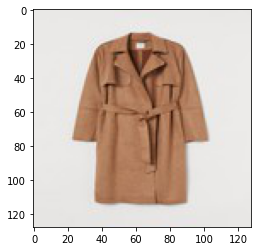

In [ ]:
# Menampilkan salah satu gambar dataset
img = image.load_img('/content/dataset/coats/P_0.jpg')
imgplot = plt.imshow(img)

In [ ]:
# Menampilkan bar chart jumlah data
label = []
count = []
for dir in os.listdir(path):
  label.append(dir)
  count.append(len(os.listdir(f'/content/dataset/{dir}')))
  
fig = px.bar(x=label, y=count, title="Jumlah Data pada Sub-Kategori")
fig.show()

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>
Dari hasik ekstraksi terdapat 7 direktori kategori yang didalamnya masing-masing terdiri dari beberapa sub-kategori, pada sub-kategori terdapat kumpulan file gambar yang akan digunakan untuk membuat model. Dalam proyek ini digunakan sub-kategori sebagai label maka untuk memmudahkannya dalam proses pembuatan model nantinya dibuat satu direktori dataset yang berisi kumpulan dari sub-kategori.
</details>

# **4. Persiapan Data** ***(Data Preparation)***

## 4.1 Melakukan pembagian data pada dataset dengan splitfolders

In [ ]:
# Melakukan split dataset 
path = os.path.join('/content/dataset')
splitfolders.ratio(path ,output="/content/split_data",ratio=(.9,.1))

Copying files: 30726 files [00:05, 5943.02 files/s]


Alternative menyalin data split ke google drive

In [ ]:
# !mkdir "/content/gdrive/MyDrive/TA"
# !zip -r "/content/gdrive/MyDrive/TA/split_data.zip" "split_data"

!cp -r '/content/gdrive/MyDrive/TA/split_data.zip' '/content/' 
!unzip split_data.zip
!mv /content/content/split_data /content/

Streaming output truncated to the last 5000 lines.
  inflating: split_data/train/twopiece/dresslily_2238.jpg  
  inflating: split_data/train/twopiece/yoox_465.jpg  
  inflating: split_data/train/twopiece/modaoperandi_368.jpg  
  inflating: split_data/train/twopiece/theoutnet_3005.jpg  
  inflating: split_data/train/twopiece/theoutnet_3137.jpg  
  inflating: split_data/train/twopiece/yoox_15.jpg  
  inflating: split_data/train/twopiece/dresslily_2300.jpg  
  inflating: split_data/train/twopiece/yoox_103.jpg  
  inflating: split_data/train/twopiece/google_2101.jpg  
  inflating: split_data/train/twopiece/googleImages_3827.jpg  
  inflating: split_data/train/twopiece/theoutnet_3063.jpg  
  inflating: split_data/train/twopiece/dresslily_2251.jpg  
  inflating: split_data/train/twopiece/yoox_494.jpg  
  inflating: split_data/train/twopiece/theoutnet_3168.jpg  
  inflating: split_data/train/twopiece/dresslily_2302.jpg  
  inflating: split_data/train/twopiece/yoox_383.jpg  
  inflating: split

## 4.2 Membuat augmentasi gambar dengan ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   rotation_range=10,
                                   vertical_flip=True,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

## 4.3 Menghasilkan augmentasi data pelatihan dan validasi menggunakan generator data.

In [ ]:
WIDTH = 128
HEIGHT = 128
BATCH_SIZE = 268
N_CLASS = 42

train_generator = train_datagen.flow_from_directory(
    '/content/split_data/train',
    target_size=(WIDTH, HEIGHT), 
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    '/content/split_data/val', 
    target_size=(WIDTH, HEIGHT), 
    batch_size=BATCH_SIZE,
    shuffle = False,
    class_mode='categorical')

Found 27642 images belonging to 42 classes.
Found 3084 images belonging to 42 classes.


# **5. Pembuatan Model**

## 5.1 Membangun arsitektur model

### 5.1.1 Model dengan VGG

In [ ]:
def vgg_model(opt, lr):
  #	Membangun arsitektur model
  base_vgg = VGG16(include_top=False,
                    weights='imagenet',
                    input_shape=(WIDTH, HEIGHT, 3))

  base_vgg.trainable = False

  model = Sequential([
                      base_vgg,
                      Flatten(),
                      Dense(512,activation = "relu"),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(512,activation = "relu"),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(N_CLASS, activation='softmax')
                  ])
  # Optimasi Model
  model.compile(optimizer=opt(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

 # CallBack Implementation
  save_model = f'/content/gdrive/MyDrive/TA/models/vgg_{str(opt)}_{lr}.h5'
  earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
  modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

  # proses pelatihan
  start = time.time()
  history = model.fit(train_generator, 
                      steps_per_epoch=len(train_generator.filenames) // BATCH_SIZE,
                      epochs=50,
                      validation_data=validation_generator,
                      validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
                      callbacks=[earlyStopping, modelCheckpoint])
  elapsed = time.time() - start
  print('Computation time = ' + str(round(elapsed,2)) + 's') 

  return history, model

### 5.1.2 Model dengan ResNet

In [ ]:
def resnet_model(opt, lr):
  #	Membangun arsitektur model
  base_resnet = ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(WIDTH, HEIGHT, 3))

  base_resnet.trainable = False

  model = Sequential([
                      base_resnet,
                      Flatten(),
                      Dense(512,activation = "relu"),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(512,activation = "relu"),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(N_CLASS, activation='softmax')
                  ])
  
  # Optimasi Model
  model.compile(optimizer=opt(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # CallBack Implementation
  save_model = f'/content/gdrive/MyDrive/TA/models/resnet_{str(opt)}_{lr}.h5'
  earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
  modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

  # proses pelatihan
  start = time.time()
  history = model.fit(train_generator, 
                      steps_per_epoch=len(train_generator.filenames) // BATCH_SIZE,
                      epochs=50,
                      validation_data=validation_generator,
                      validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
                      callbacks=[earlyStopping, modelCheckpoint])
  elapsed = time.time() - start
  print('Computation time = ' + str(round(elapsed,2)) + 's') 

  return history, model

### 5.1.1 Model dengan buatan sendiri

In [ ]:
def own_model(opt, lr):
  #	Membangun arsitektur model
  model = Sequential([
                      Conv2D(16, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)),
                      MaxPooling2D(2, 2),
                      Conv2D(32, (3, 3), activation='relu'),
                      MaxPooling2D(2, 2),
                      Conv2D(64, (3, 3), activation='relu'),
                      MaxPooling2D(2, 2),
                      Conv2D(128, (3, 3), activation='relu'),
                      MaxPooling2D(2, 2),
                      Flatten(),
                      Dense(512,activation = "relu"),
                      BatchNormalization(),
                      Dropout(0.3),
                      Dense(512,activation = "relu"),
                      BatchNormalization(),
                      Dropout(0.3),
                      Dense(N_CLASS, activation='softmax')])
  
  # Optimasi Model
  model.compile(optimizer=opt(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # CallBack Implementation
  save_model = f'/content/gdrive/MyDrive/TA/models/own_{str(opt)}_{lr}.h5'
  earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
  modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

  # proses pelatihan
  start = time.time()
  history = model.fit(train_generator, 
                      steps_per_epoch=len(train_generator.filenames) // BATCH_SIZE,
                      epochs=50,
                      validation_data=validation_generator,
                      validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
                      callbacks=[earlyStopping, modelCheckpoint])
  elapsed = time.time() - start
  print('Computation time = ' + str(round(elapsed,2)) + 's') 

  return history, model

## 5.2 Melatih model

In [ ]:
# Fungsi untuk menampilkan grafik pelatihan
def plot_accuracy_loss(history, title):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Accuracy {title}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(2,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Loss {title}')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### 5.2.1 Melatih model VGG

#### 5.2.1.1 Optimizers Adam

In [ ]:
history_vgg_adam1, model_vgg_adam1 = vgg_model(Adam, 0.01)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.5531 - accuracy: 0.5551
Epoch 00001: val_accuracy improved from -inf to 0.70149, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.adam.Adam'>_0.01.h5
103/103 [==============================] - 191s 2s/step - loss: 1.5531 - accuracy: 0.5551 - val_loss: 1.1268 - val_accuracy: 0.7015
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.6840
Epoch 00002: val_accuracy improved from 0.70149 to 0.75509, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.adam.Adam'>_0.01.h5
103/103 [==============================] - 152s 1s/step - loss: 0.9825 - accuracy: 0.6840 - val_loss: 0.7686 - val_accuracy: 0.7551
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.8564 - accuracy: 0.7186
Epoch 00003: val_accuracy did not improve from 0.75509
103/103 [

In [ ]:
history_vgg_adam2, model_vgg_adam2 = vgg_model(Adam, 0.001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.7223 - accuracy: 0.5300
Epoch 00001: val_accuracy improved from -inf to 0.71337, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.adam.Adam'>_0.001.h5
103/103 [==============================] - 152s 1s/step - loss: 1.7223 - accuracy: 0.5300 - val_loss: 1.0024 - val_accuracy: 0.7134
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.0347 - accuracy: 0.6744
Epoch 00002: val_accuracy improved from 0.71337 to 0.76730, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.adam.Adam'>_0.001.h5
103/103 [==============================] - 152s 1s/step - loss: 1.0347 - accuracy: 0.6744 - val_loss: 0.7300 - val_accuracy: 0.7673
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.8801 - accuracy: 0.7160
Epoch 00003: val_accuracy improved from 0.76730 to 0.78630, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras

In [ ]:
history_vgg_adam3, model_vgg_adam3 = vgg_model(Adam, 0.0001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 3.3106 - accuracy: 0.2289
Epoch 00001: val_accuracy improved from -inf to 0.58480, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.adam.Adam'>_0.0001.h5
103/103 [==============================] - 152s 1s/step - loss: 3.3106 - accuracy: 0.2289 - val_loss: 1.5144 - val_accuracy: 0.5848
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.9647 - accuracy: 0.4687
Epoch 00002: val_accuracy improved from 0.58480 to 0.66689, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.adam.Adam'>_0.0001.h5
103/103 [==============================] - 151s 1s/step - loss: 1.9647 - accuracy: 0.4687 - val_loss: 1.1199 - val_accuracy: 0.6669
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.5829 - accuracy: 0.5536
Epoch 00003: val_accuracy improved from 0.66689 to 0.70929, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'ker

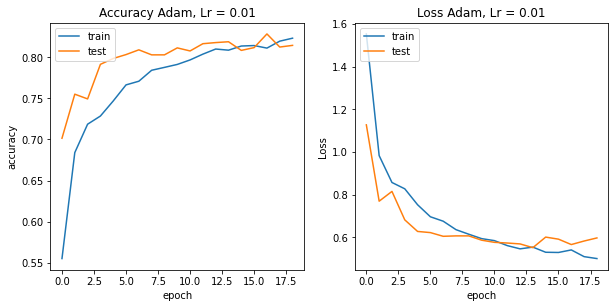

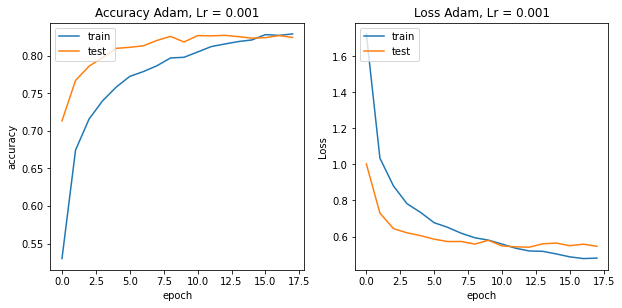

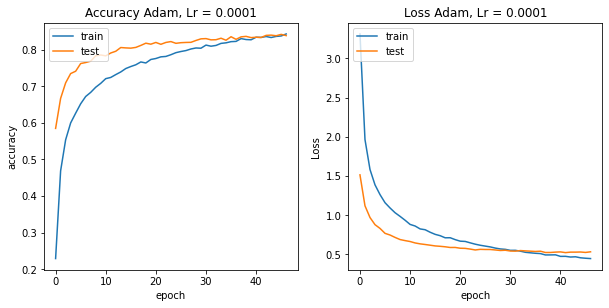

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_vgg_adam1, history_vgg_adam2, history_vgg_adam3]
train_title = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

#### 5.2.1.4 Optimizers RMSProp

In [ ]:
history_vgg_rmsprop1, model_vgg_rmsprop1 = vgg_model(RMSprop, 0.01)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.6145 - accuracy: 0.5570
Epoch 00001: val_accuracy improved from -inf to 0.63942, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
103/103 [==============================] - 208s 2s/step - loss: 1.6145 - accuracy: 0.5570 - val_loss: 1.8196 - val_accuracy: 0.6394
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.0313 - accuracy: 0.6762
Epoch 00002: val_accuracy improved from 0.63942 to 0.72999, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
103/103 [==============================] - 158s 2s/step - loss: 1.0313 - accuracy: 0.6762 - val_loss: 0.9540 - val_accuracy: 0.7300
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.7130
Epoch 00003: val_accuracy improved from 0.72999 to 0

In [ ]:
history_vgg_rmsprop2, model_vgg_rmsprop2 = vgg_model(RMSprop, 0.001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.6354 - accuracy: 0.5480
Epoch 00001: val_accuracy improved from -inf to 0.71031, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
103/103 [==============================] - 158s 2s/step - loss: 1.6354 - accuracy: 0.5480 - val_loss: 1.0604 - val_accuracy: 0.7103
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.0295 - accuracy: 0.6777
Epoch 00002: val_accuracy improved from 0.71031 to 0.76730, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
103/103 [==============================] - 155s 2s/step - loss: 1.0295 - accuracy: 0.6777 - val_loss: 0.7889 - val_accuracy: 0.7673
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.7200
Epoch 00003: val_accuracy improved from 0.76730 to 0.77782, saving model to /content/gdrive/MyDrive/TA/models/vgg_<

In [ ]:
history_vgg_rmsprop3, model_vgg_rmsprop2 = vgg_model(RMSprop, 0.0001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 3.0982 - accuracy: 0.2598
Epoch 00001: val_accuracy improved from -inf to 0.60448, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
103/103 [==============================] - 157s 2s/step - loss: 3.0982 - accuracy: 0.2598 - val_loss: 1.4644 - val_accuracy: 0.6045
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.8658 - accuracy: 0.4885
Epoch 00002: val_accuracy improved from 0.60448 to 0.68419, saving model to /content/gdrive/MyDrive/TA/models/vgg_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
103/103 [==============================] - 156s 2s/step - loss: 1.8658 - accuracy: 0.4885 - val_loss: 1.1012 - val_accuracy: 0.6842
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.4927 - accuracy: 0.5753
Epoch 00003: val_accuracy improved from 0.68419 to 0.71303, saving model to /content/gdrive/MyDrive/TA/models/vgg

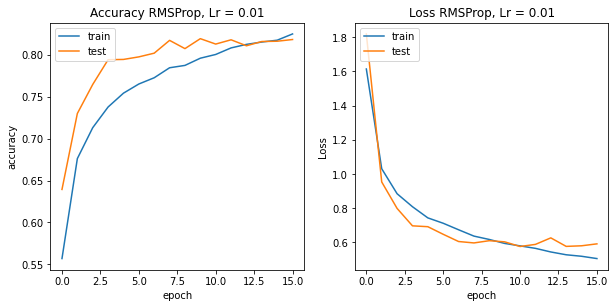

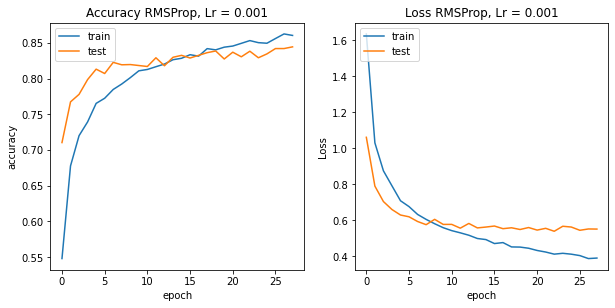

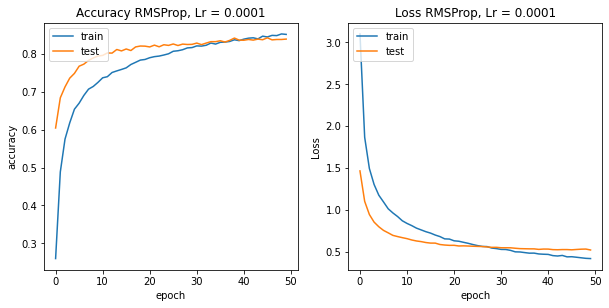

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_vgg_rmsprop1, history_vgg_rmsprop2, history_vgg_rmsprop3]
train_title = ["RMSProp, Lr = 0.01", "RMSProp, Lr = 0.001", "RMSProp, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

### 5.2.2 Melatih model ResNet

#### 5.2.1.1 Optimizers Adam

In [ ]:
history_resnet_adam1, model_resnet_adam1 = resnet_model(Adam, 0.01)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.6951 - accuracy: 0.5270
Epoch 00001: val_accuracy improved from -inf to 0.67877, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.01.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



103/103 [==============================] - 162s 1s/step - loss: 1.6951 - accuracy: 0.5270 - val_loss: 1.2574 - val_accuracy: 0.6788
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.0423 - accuracy: 0.6636
Epoch 00002: val_accuracy improved from 0.67877 to 0.73847, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.01.h5
103/103 [==============================] - 149s 1s/step - loss: 1.0423 - accuracy: 0.6636 - val_loss: 0.8586 - val_accuracy: 0.7385
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.7112
Epoch 00003: val_accuracy improved from 0.73847 to 0.77476, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.01.h5
103/103 [==============================] - 144s 1s/step - loss: 0.8875 - accuracy: 0.7112 - val_loss: 0.6885 - val_accuracy: 0.7748
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss: 0.7832 - accur

In [ ]:
history_resnet_adam2, model_resnet_adam2 = resnet_model(Adam, 0.001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.6337 - accuracy: 0.5477
Epoch 00001: val_accuracy improved from -inf to 0.71913, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.001.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



103/103 [==============================] - 147s 1s/step - loss: 1.6337 - accuracy: 0.5477 - val_loss: 0.9905 - val_accuracy: 0.7191
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.0198 - accuracy: 0.6801
Epoch 00002: val_accuracy improved from 0.71913 to 0.76391, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.001.h5
103/103 [==============================] - 143s 1s/step - loss: 1.0198 - accuracy: 0.6801 - val_loss: 0.7642 - val_accuracy: 0.7639
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.8485 - accuracy: 0.7221
Epoch 00003: val_accuracy improved from 0.76391 to 0.79172, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.001.h5
103/103 [==============================] - 143s 1s/step - loss: 0.8485 - accuracy: 0.7221 - val_loss: 0.6744 - val_accuracy: 0.7917
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss: 0.7640 - acc

In [ ]:
history_resnet_adam3, model_resnet_adam3 = resnet_model(Adam, 0.0001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.2697 - accuracy: 0.4257
Epoch 00001: val_accuracy improved from -inf to 0.68521, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.0001.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



103/103 [==============================] - 151s 1s/step - loss: 2.2697 - accuracy: 0.4257 - val_loss: 1.0863 - val_accuracy: 0.6852
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.3572 - accuracy: 0.6135
Epoch 00002: val_accuracy improved from 0.68521 to 0.75305, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.0001.h5
103/103 [==============================] - 146s 1s/step - loss: 1.3572 - accuracy: 0.6135 - val_loss: 0.8449 - val_accuracy: 0.7531
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.1296 - accuracy: 0.6633
Epoch 00003: val_accuracy improved from 0.75305 to 0.76628, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.adam.Adam'>_0.0001.h5
103/103 [==============================] - 146s 1s/step - loss: 1.1296 - accuracy: 0.6633 - val_loss: 0.7421 - val_accuracy: 0.7663
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss: 1.0161 - a

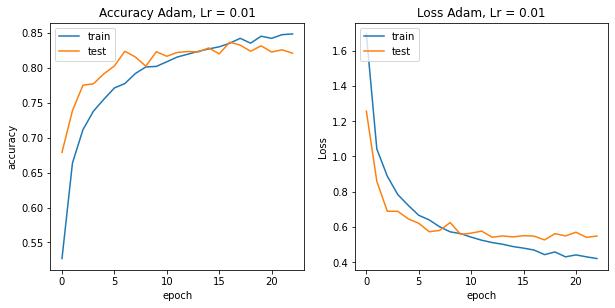

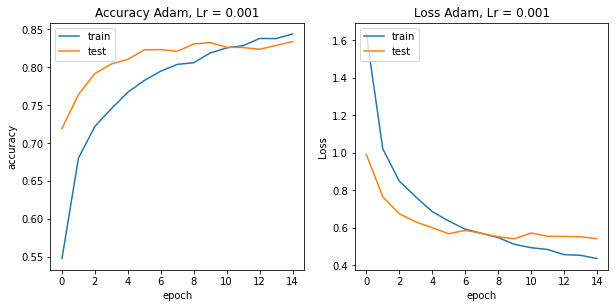

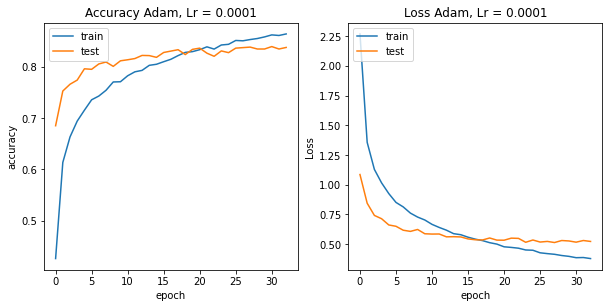

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_resnet_adam1, history_resnet_adam2, history_resnet_adam3]
train_title = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

#### 5.2.1.4 Optimizers RMSProp

In [ ]:
history_resnet_rmsprop1, model_resnet_rmsprop1 = resnet_model(RMSprop, 0.01)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.7591 - accuracy: 0.5424
Epoch 00001: val_accuracy improved from -inf to 0.67436, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.01.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



103/103 [==============================] - 163s 1s/step - loss: 1.7591 - accuracy: 0.5424 - val_loss: 1.7769 - val_accuracy: 0.6744
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.0422 - accuracy: 0.6701
Epoch 00002: val_accuracy improved from 0.67436 to 0.69369, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
103/103 [==============================] - 148s 1s/step - loss: 1.0422 - accuracy: 0.6701 - val_loss: 1.4065 - val_accuracy: 0.6937
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.8608 - accuracy: 0.7211
Epoch 00003: val_accuracy improved from 0.69369 to 0.75441, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
103/103 [==============================] - 147s 1s/step - loss: 0.8608 - accuracy: 0.7211 - val_loss: 0.8635 - val_accuracy: 0.7544
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss: 0.

In [ ]:
history_resnet_rmsprop2, model_resnet_rmsprop2 = resnet_model(RMSprop, 0.001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.5755 - accuracy: 0.5635
Epoch 00001: val_accuracy improved from -inf to 0.73202, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.001.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



103/103 [==============================] - 152s 1s/step - loss: 1.5755 - accuracy: 0.5635 - val_loss: 1.0355 - val_accuracy: 0.7320
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.0015 - accuracy: 0.6892
Epoch 00002: val_accuracy improved from 0.73202 to 0.77103, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
103/103 [==============================] - 149s 1s/step - loss: 1.0015 - accuracy: 0.6892 - val_loss: 0.7956 - val_accuracy: 0.7710
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.8340 - accuracy: 0.7315
Epoch 00003: val_accuracy improved from 0.77103 to 0.78460, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
103/103 [==============================] - 149s 1s/step - loss: 0.8340 - accuracy: 0.7315 - val_loss: 0.7078 - val_accuracy: 0.7846
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss: 

In [ ]:
history_resnet_rmsprop3, model_resnet_rmsprop2 = resnet_model(RMSprop, 0.0001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.1130 - accuracy: 0.4539
Epoch 00001: val_accuracy improved from -inf to 0.71506, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



103/103 [==============================] - 147s 1s/step - loss: 2.1130 - accuracy: 0.4539 - val_loss: 1.0105 - val_accuracy: 0.7151
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.6286
Epoch 00002: val_accuracy improved from 0.71506 to 0.75102, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
103/103 [==============================] - 143s 1s/step - loss: 1.3052 - accuracy: 0.6286 - val_loss: 0.8272 - val_accuracy: 0.7510
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.0847 - accuracy: 0.6763
Epoch 00003: val_accuracy improved from 0.75102 to 0.77510, saving model to /content/gdrive/MyDrive/TA/models/resnet_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
103/103 [==============================] - 144s 1s/step - loss: 1.0847 - accuracy: 0.6763 - val_loss: 0.7586 - val_accuracy: 0.7751
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss

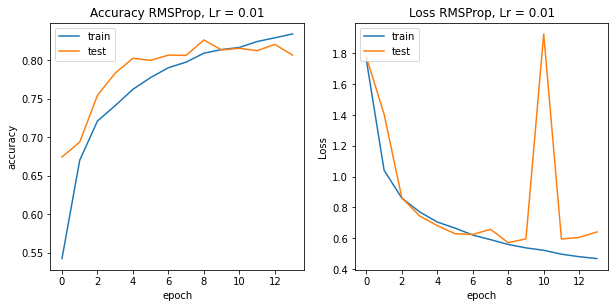

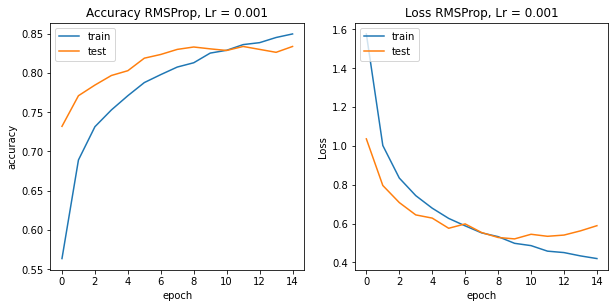

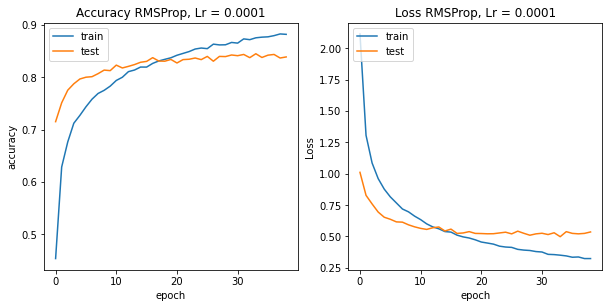

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_resnet_rmsprop1, history_resnet_rmsprop2, history_resnet_rmsprop3]
train_title = ["RMSProp, Lr = 0.01", "RMSProp, Lr = 0.001", "RMSProp, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

### 5.2.1 Melatih model rancangan sendiri

#### 5.2.1.1 Optimizers Adam

In [ ]:
history_own_adam1, model_own_adam1 = own_model(Adam, 0.01)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.5660 - accuracy: 0.3059
Epoch 00001: val_accuracy improved from -inf to 0.33548, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.adam.Adam'>_0.01.h5
103/103 [==============================] - 140s 1s/step - loss: 2.5660 - accuracy: 0.3059 - val_loss: 2.5494 - val_accuracy: 0.3355
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.8188 - accuracy: 0.4647
Epoch 00002: val_accuracy improved from 0.33548 to 0.36160, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.adam.Adam'>_0.01.h5
103/103 [==============================] - 123s 1s/step - loss: 1.8188 - accuracy: 0.4647 - val_loss: 2.5262 - val_accuracy: 0.3616
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.5460 - accuracy: 0.5331
Epoch 00003: val_accuracy improved from 0.36160 to 0.37347, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.o

In [ ]:
history_own_adam2, model_own_adam2 = own_model(Adam, 0.001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.5597 - accuracy: 0.3080
Epoch 00001: val_accuracy improved from -inf to 0.21879, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.adam.Adam'>_0.001.h5
103/103 [==============================] - 122s 1s/step - loss: 2.5597 - accuracy: 0.3080 - val_loss: 3.5227 - val_accuracy: 0.2188
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.8612 - accuracy: 0.4533
Epoch 00002: val_accuracy improved from 0.21879 to 0.25984, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.adam.Adam'>_0.001.h5
103/103 [==============================] - 122s 1s/step - loss: 1.8612 - accuracy: 0.4533 - val_loss: 2.9810 - val_accuracy: 0.2598
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.5530 - accuracy: 0.5291
Epoch 00003: val_accuracy improved from 0.25984 to 0.33175, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras

In [ ]:
history_own_adam3, model_own_adam3 = own_model(Adam, 0.0001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.6589 - accuracy: 0.2913
Epoch 00001: val_accuracy improved from -inf to 0.13501, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.adam.Adam'>_0.0001.h5
103/103 [==============================] - 124s 1s/step - loss: 2.6589 - accuracy: 0.2913 - val_loss: 5.5373 - val_accuracy: 0.1350
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.8493 - accuracy: 0.4519
Epoch 00002: val_accuracy improved from 0.13501 to 0.25678, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.adam.Adam'>_0.0001.h5
103/103 [==============================] - 122s 1s/step - loss: 1.8493 - accuracy: 0.4519 - val_loss: 3.5043 - val_accuracy: 0.2568
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.5722 - accuracy: 0.5277
Epoch 00003: val_accuracy improved from 0.25678 to 0.32225, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'ker

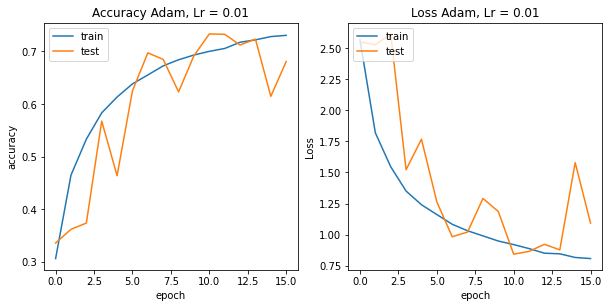

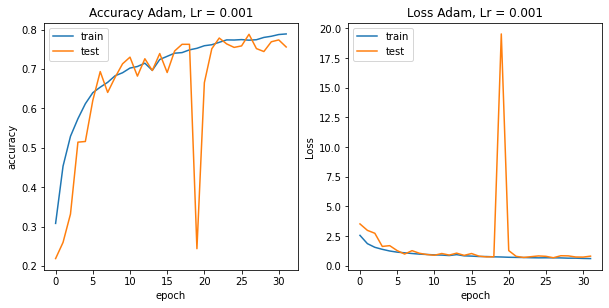

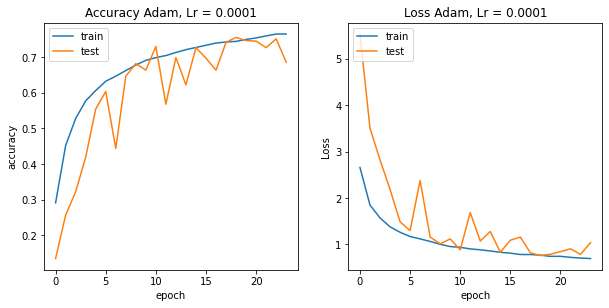

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_own_adam1, history_own_adam2, history_own_adam3]
train_title = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

#### 5.2.1.4 Optimizers RMSProp

In [ ]:
history_own_rmsprop1, model_own_rmsprop1 = own_model(RMSprop, 0.01)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.6619 - accuracy: 0.2895
Epoch 00001: val_accuracy improved from -inf to 0.10142, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
103/103 [==============================] - 125s 1s/step - loss: 2.6619 - accuracy: 0.2895 - val_loss: 9.9388 - val_accuracy: 0.1014
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.9733 - accuracy: 0.4251
Epoch 00002: val_accuracy improved from 0.10142 to 0.24525, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
103/103 [==============================] - 123s 1s/step - loss: 1.9733 - accuracy: 0.4251 - val_loss: 3.7978 - val_accuracy: 0.2453
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.6730 - accuracy: 0.4991
Epoch 00003: val_accuracy improved from 0.24525 to 0.47863, saving model to /content/gdrive/MyDrive/TA/models/own_<cl

In [ ]:
history_own_rmsprop2, model_own_rmsprop2 = own_model(RMSprop, 0.001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.6292 - accuracy: 0.2971
Epoch 00001: val_accuracy improved from -inf to 0.05733, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
103/103 [==============================] - 125s 1s/step - loss: 2.6292 - accuracy: 0.2971 - val_loss: 24.3902 - val_accuracy: 0.0573
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.9655 - accuracy: 0.4249
Epoch 00002: val_accuracy improved from 0.05733 to 0.32361, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
103/103 [==============================] - 120s 1s/step - loss: 1.9655 - accuracy: 0.4249 - val_loss: 2.7032 - val_accuracy: 0.3236
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.6628 - accuracy: 0.5058
Epoch 00003: val_accuracy did not improve from 0.32361
103/103 [==============================] - 120s 1s/step - l

In [ ]:
history_own_rmsprop3, model_own_rmsprop2 = own_model(RMSprop, 0.0001)

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.6476 - accuracy: 0.2910
Epoch 00001: val_accuracy improved from -inf to 0.10278, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
103/103 [==============================] - 124s 1s/step - loss: 2.6476 - accuracy: 0.2910 - val_loss: 8.0867 - val_accuracy: 0.1028
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 1.9607 - accuracy: 0.4247
Epoch 00002: val_accuracy improved from 0.10278 to 0.20488, saving model to /content/gdrive/MyDrive/TA/models/own_<class 'keras.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
103/103 [==============================] - 122s 1s/step - loss: 1.9607 - accuracy: 0.4247 - val_loss: 5.5601 - val_accuracy: 0.2049
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.6728 - accuracy: 0.5004
Epoch 00003: val_accuracy improved from 0.20488 to 0.41927, saving model to /content/gdrive/MyDrive/TA/models/own

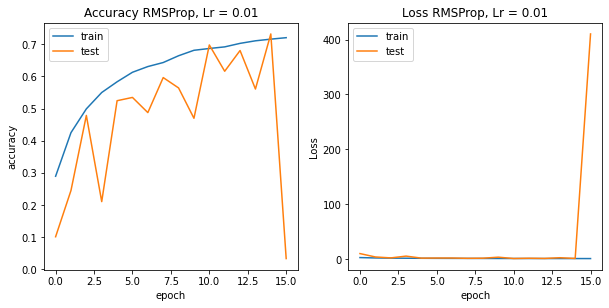

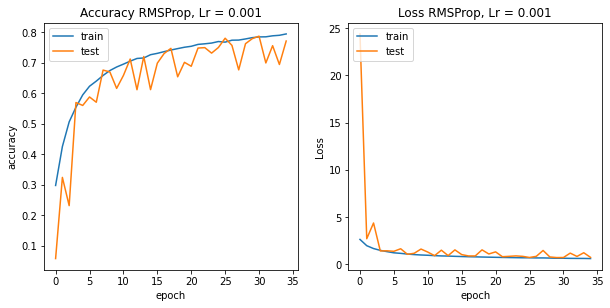

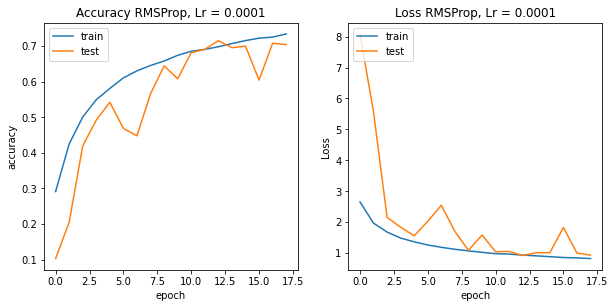

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_own_rmsprop1, history_own_rmsprop2, history_own_rmsprop3]
train_title = ["RMSProp, Lr = 0.01", "RMSProp, Lr = 0.001", "RMSProp, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

# **6. Evaluasi Model**

### 6.1 Load model

In [ ]:
# Memindahkan model ke colab
!cp /content/gdrive/MyDrive/TA/models/* .

In [ ]:
# Ekstrak model
!unzip /content/resnet.zip
!unzip /content/vgg.zip
!unzip /content/own.zip

Archive:  /content/resnet.zip
  inflating: resnet__class _keras.optimizer_v2.adam.Adam__0.001.h5  
  inflating: resnet__class _keras.optimizer_v2.adam.Adam__0.01.h5  
  inflating: resnet__class _keras.optimizer_v2.rmsprop.RMSprop__0.0001.h5  
  inflating: resnet__class _keras.optimizer_v2.rmsprop.RMSprop__0.001.h5  
  inflating: resnet__class _keras.optimizer_v2.rmsprop.RMSprop__0.01.h5  
  inflating: resnet__class _keras.optimizer_v2.adam.Adam__0.0001.h5  
Archive:  /content/vgg.zip
  inflating: vgg__class _keras.optimizer_v2.adam.Adam__0.0001.h5  
  inflating: vgg__class _keras.optimizer_v2.adam.Adam__0.001.h5  
  inflating: vgg__class _keras.optimizer_v2.adam.Adam__0.01.h5  
  inflating: vgg__class _keras.optimizer_v2.rmsprop.RMSprop__0.0001.h5  
  inflating: vgg__class _keras.optimizer_v2.rmsprop.RMSprop__0.001.h5  
  inflating: vgg__class _keras.optimizer_v2.rmsprop.RMSprop__0.01.h5  
Archive:  /content/own.zip
  inflating: models/own__class _keras.optimizer_v2.rmsprop.RMSprop__0.

In [ ]:
# Menghapus archive
!rm /content/resnet.zip
!rm /content/vgg.zip
!rm /content/own.zip

#### 6.1.1 Model VGG

In [ ]:
model_vgg_adam1 = keras.models.load_model('/content/vgg__class _keras.optimizer_v2.adam.Adam__0.01.h5')
model_vgg_adam2 = keras.models.load_model('/content/vgg__class _keras.optimizer_v2.adam.Adam__0.001.h5')
model_vgg_adam3 = keras.models.load_model('/content/vgg__class _keras.optimizer_v2.adam.Adam__0.0001.h5')

In [ ]:
model_vgg_rmsprop1 = keras.models.load_model('/content/vgg__class _keras.optimizer_v2.rmsprop.RMSprop__0.01.h5')
model_vgg_rmsprop2 = keras.models.load_model('/content/vgg__class _keras.optimizer_v2.rmsprop.RMSprop__0.001.h5')
model_vgg_rmsprop3 = keras.models.load_model('/content/vgg__class _keras.optimizer_v2.rmsprop.RMSprop__0.0001.h5')

#### 6.1.2 Model ResNet

In [ ]:
model_resnet_adam1 = keras.models.load_model('/content/resnet__class _keras.optimizer_v2.adam.Adam__0.01.h5')
model_resnet_adam2 = keras.models.load_model('/content/resnet__class _keras.optimizer_v2.adam.Adam__0.001.h5')
model_resnet_adam3 = keras.models.load_model('/content/resnet__class _keras.optimizer_v2.adam.Adam__0.0001.h5')

In [ ]:
model_resnet_rmsprop1 = keras.models.load_model('/content/resnet__class _keras.optimizer_v2.rmsprop.RMSprop__0.01.h5')
model_resnet_rmsprop2 = keras.models.load_model('/content/resnet__class _keras.optimizer_v2.rmsprop.RMSprop__0.001.h5')
model_resnet_rmsprop3 = keras.models.load_model('/content/resnet__class _keras.optimizer_v2.rmsprop.RMSprop__0.0001.h5')

#### 6.1.3 Model Sendiri

In [ ]:
model_own_adam1 = keras.models.load_model('/content/own__class _keras.optimizer_v2.adam.Adam__0.01.h5')
model_own_adam2 = keras.models.load_model('/content/own__class _keras.optimizer_v2.adam.Adam__0.001.h5')
model_own_adam3 = keras.models.load_model('/content/own__class _keras.optimizer_v2.adam.Adam__0.0001.h5')

In [ ]:
model_own_rmsprop1 = keras.models.load_model('/content/own__class _keras.optimizer_v2.rmsprop.RMSprop__0.01.h5')
model_own_rmsprop2 = keras.models.load_model('/content/own__class _keras.optimizer_v2.rmsprop.RMSprop__0.001.h5')
model_own_rmsprop3 = keras.models.load_model('/content/own__class _keras.optimizer_v2.rmsprop.RMSprop__0.0001.h5')

### 6.2 Mengecek klasifikasi

#### 6.2.1 Klasifikasi VGG

In [ ]:
# Melakukan klasifikasi
pred_vgg_adam1 = model_vgg_adam1.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_vgg_adam2 = model_vgg_adam2.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_vgg_adam3 = model_vgg_adam3.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))

In [ ]:
# Melakukan klasifikasi
pred_vgg_rmsprop1 = model_vgg_rmsprop1.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_vgg_rmsprop2 = model_vgg_rmsprop2.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_vgg_rmsprop3 = model_vgg_rmsprop3.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))

#### 6.2.2 Klasifikasi ResNet

In [ ]:
# Melakukan klasifikasi
pred_resnet_adam1 = model_resnet_adam1.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_resnet_adam2 = model_resnet_adam2.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_resnet_adam3 = model_resnet_adam3.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))

In [ ]:
# Melakukan klasifikasi
pred_resnet_rmsprop1 = model_resnet_rmsprop1.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_resnet_rmsprop2 = model_resnet_rmsprop2.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_resnet_rmsprop3 = model_resnet_rmsprop3.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))

#### 6.2.3 Klasifikasi own model

In [ ]:
# Melakukan klasifikasi
pred_own_adam1 = model_own_adam1.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_own_adam2 = model_own_adam2.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_own_adam3 = model_own_adam3.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))

In [ ]:
# Melakukan klasifikasi
pred_own_rmsprop1 = model_own_rmsprop1.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_own_rmsprop2 = model_own_rmsprop2.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))
pred_own_rmsprop3 = model_own_rmsprop3.predict(validation_generator, steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size))

### 6.3 Visualisasi model

In [ ]:
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

In [ ]:
def plot_confusion_matrix(cm, class_, title):
    plt.figure(figsize=(30,30))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix {title}', fontweight='bold')
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True labels', fontweight='bold')
    plt.xlabel('Predicted labels', fontweight='bold')
    plt.show()

In [ ]:
opt = ["Adam", "Adam", "Adam", "RMSProp", "RMSProp", "RMSProp"]
lr = ["0.01", "0.001", "0.0001", "0.01", "0.001", "0.0001"]

#### 6.2.1 Model vgg

In [ ]:
res_predict = [pred_vgg_adam1, pred_vgg_adam2, pred_vgg_adam3, pred_vgg_rmsprop1, pred_vgg_rmsprop2, pred_vgg_rmsprop3]
for (x, y, z) in (zip(res_predict, opt, lr)):
  print(f"\n++++++++++++++++++++++++ Model VGG ++++++++++++++++++++++++")
  print(f"++++++++++ optimizer {y} dan learning rate {z} ++++++++++\n")

  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  print(classification_report(true_classes, preds, target_names=class_labels))



++++++++++++++++++++++++ Model VGG ++++++++++++++++++++++++
++++++++++ optimizer Adam dan learning rate 0.01 ++++++++++

                 precision    recall  f1-score   support

      backpacks       0.90      0.95      0.93        80
          belts       0.97      0.84      0.90        81
        blazers       0.60      0.96      0.74        81
          boots       0.86      0.96      0.91        70
         bottom       0.96      0.97      0.97        80
           caps       0.88      0.93      0.90        80
         casual       0.91      0.86      0.89        50
         clutch       0.86      0.85      0.86        80
          coats       0.88      0.81      0.85        74
       cocktail       0.85      0.75      0.79        80
          flats       0.85      0.41      0.56        70
         gloves       0.92      0.91      0.92        80
hairaccessories       0.92      0.61      0.73        76
       handbags       0.82      0.94      0.88        80
           hats       

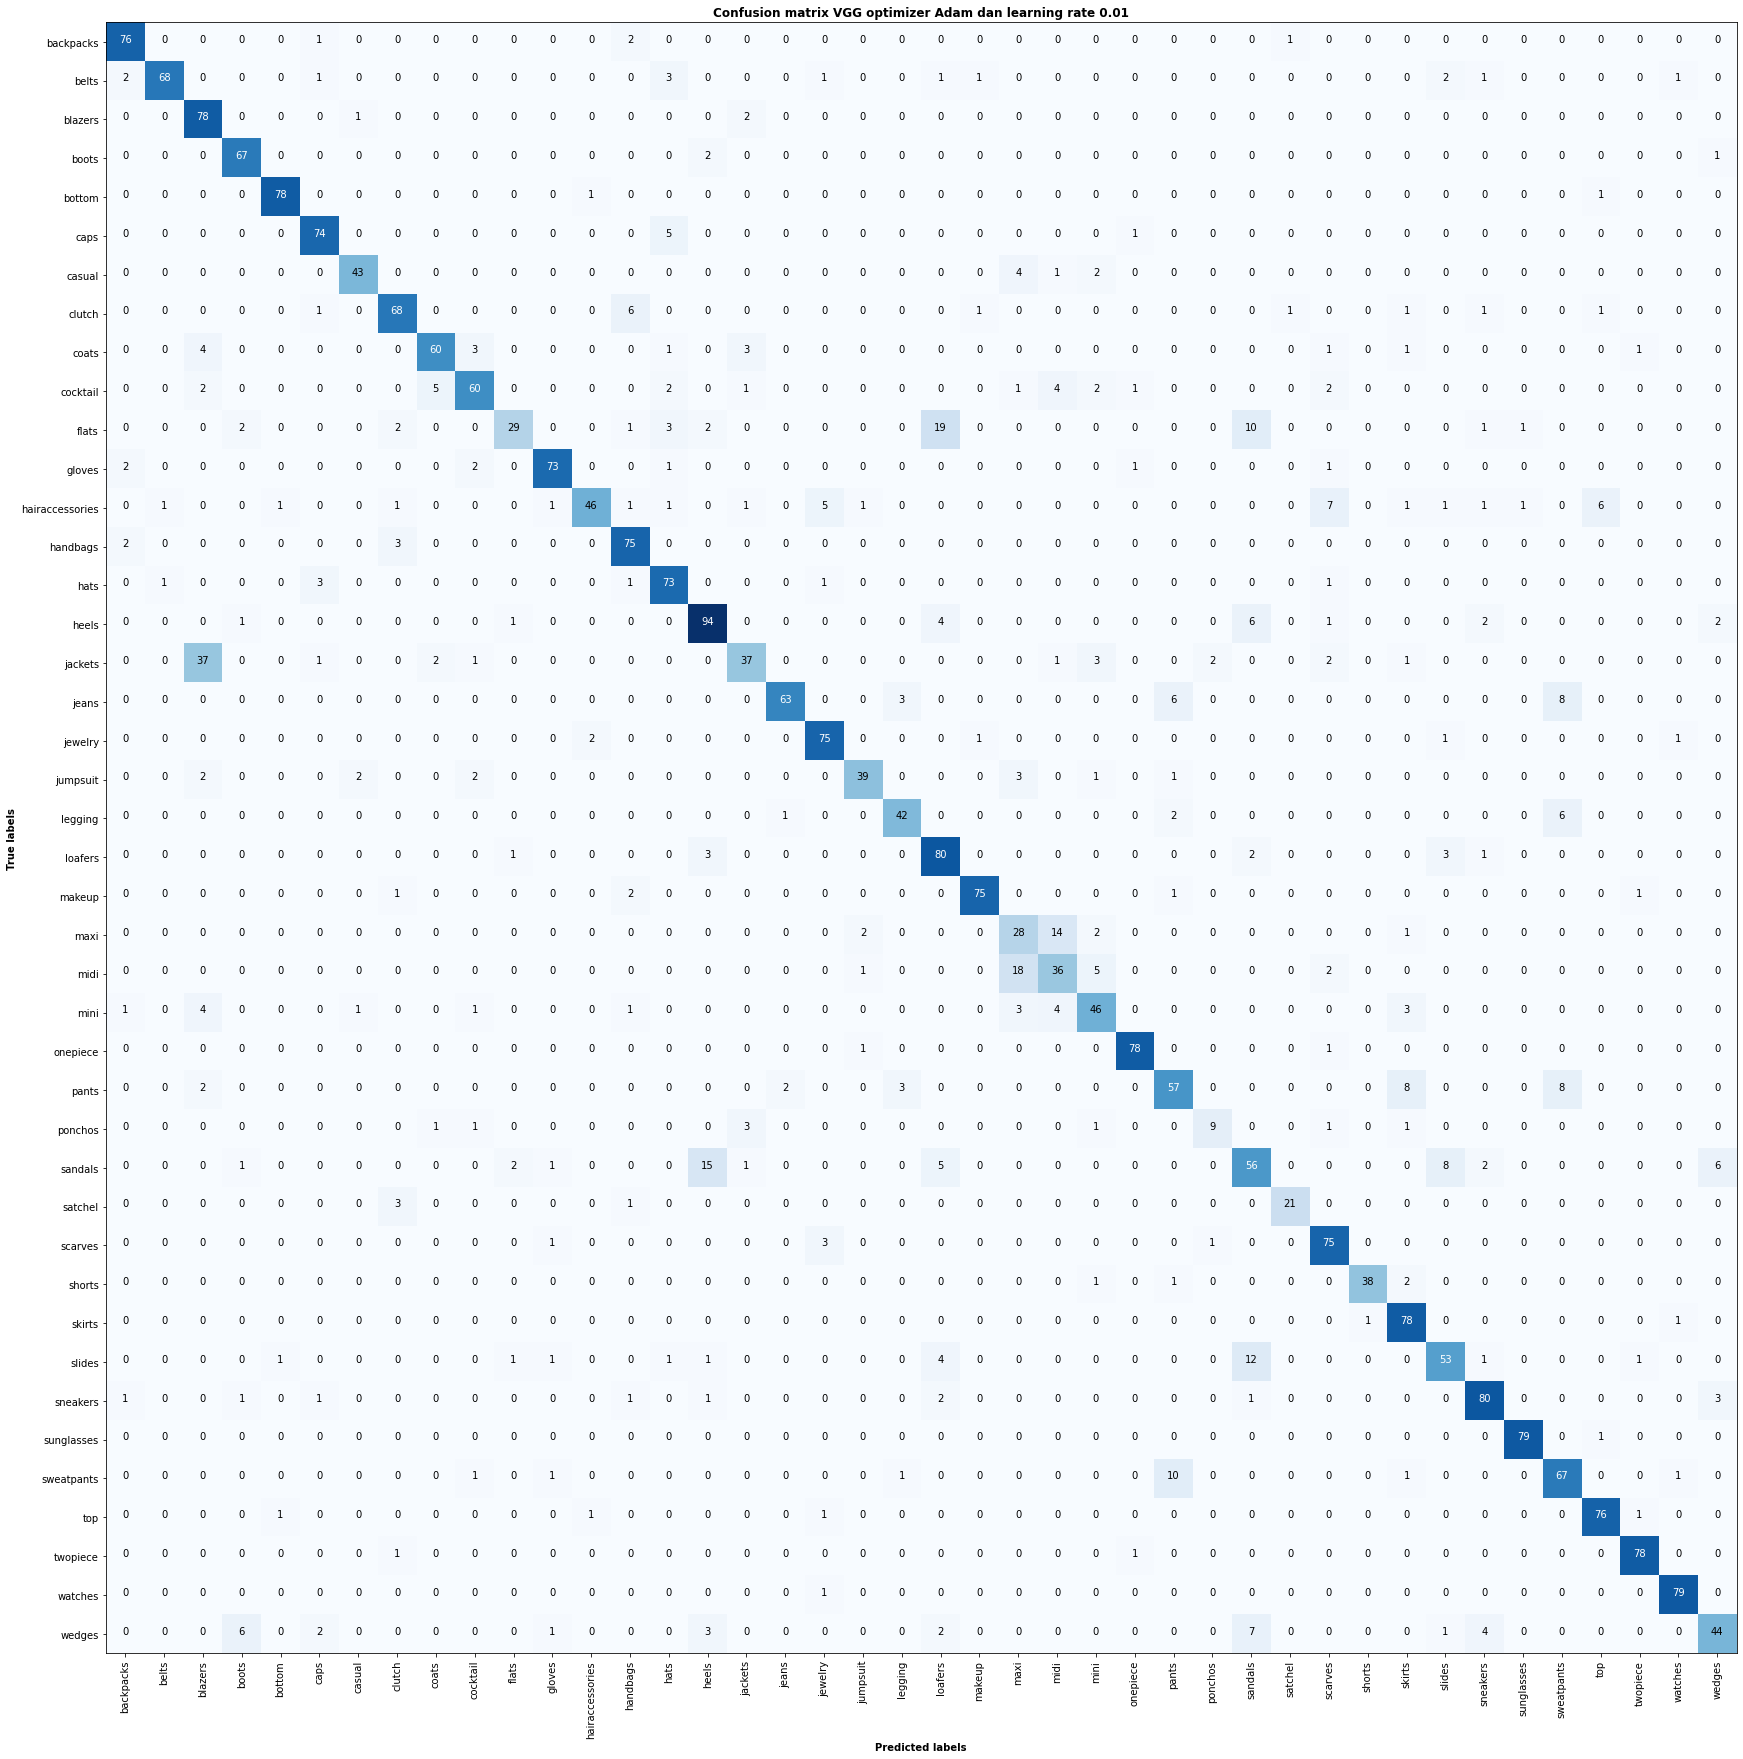

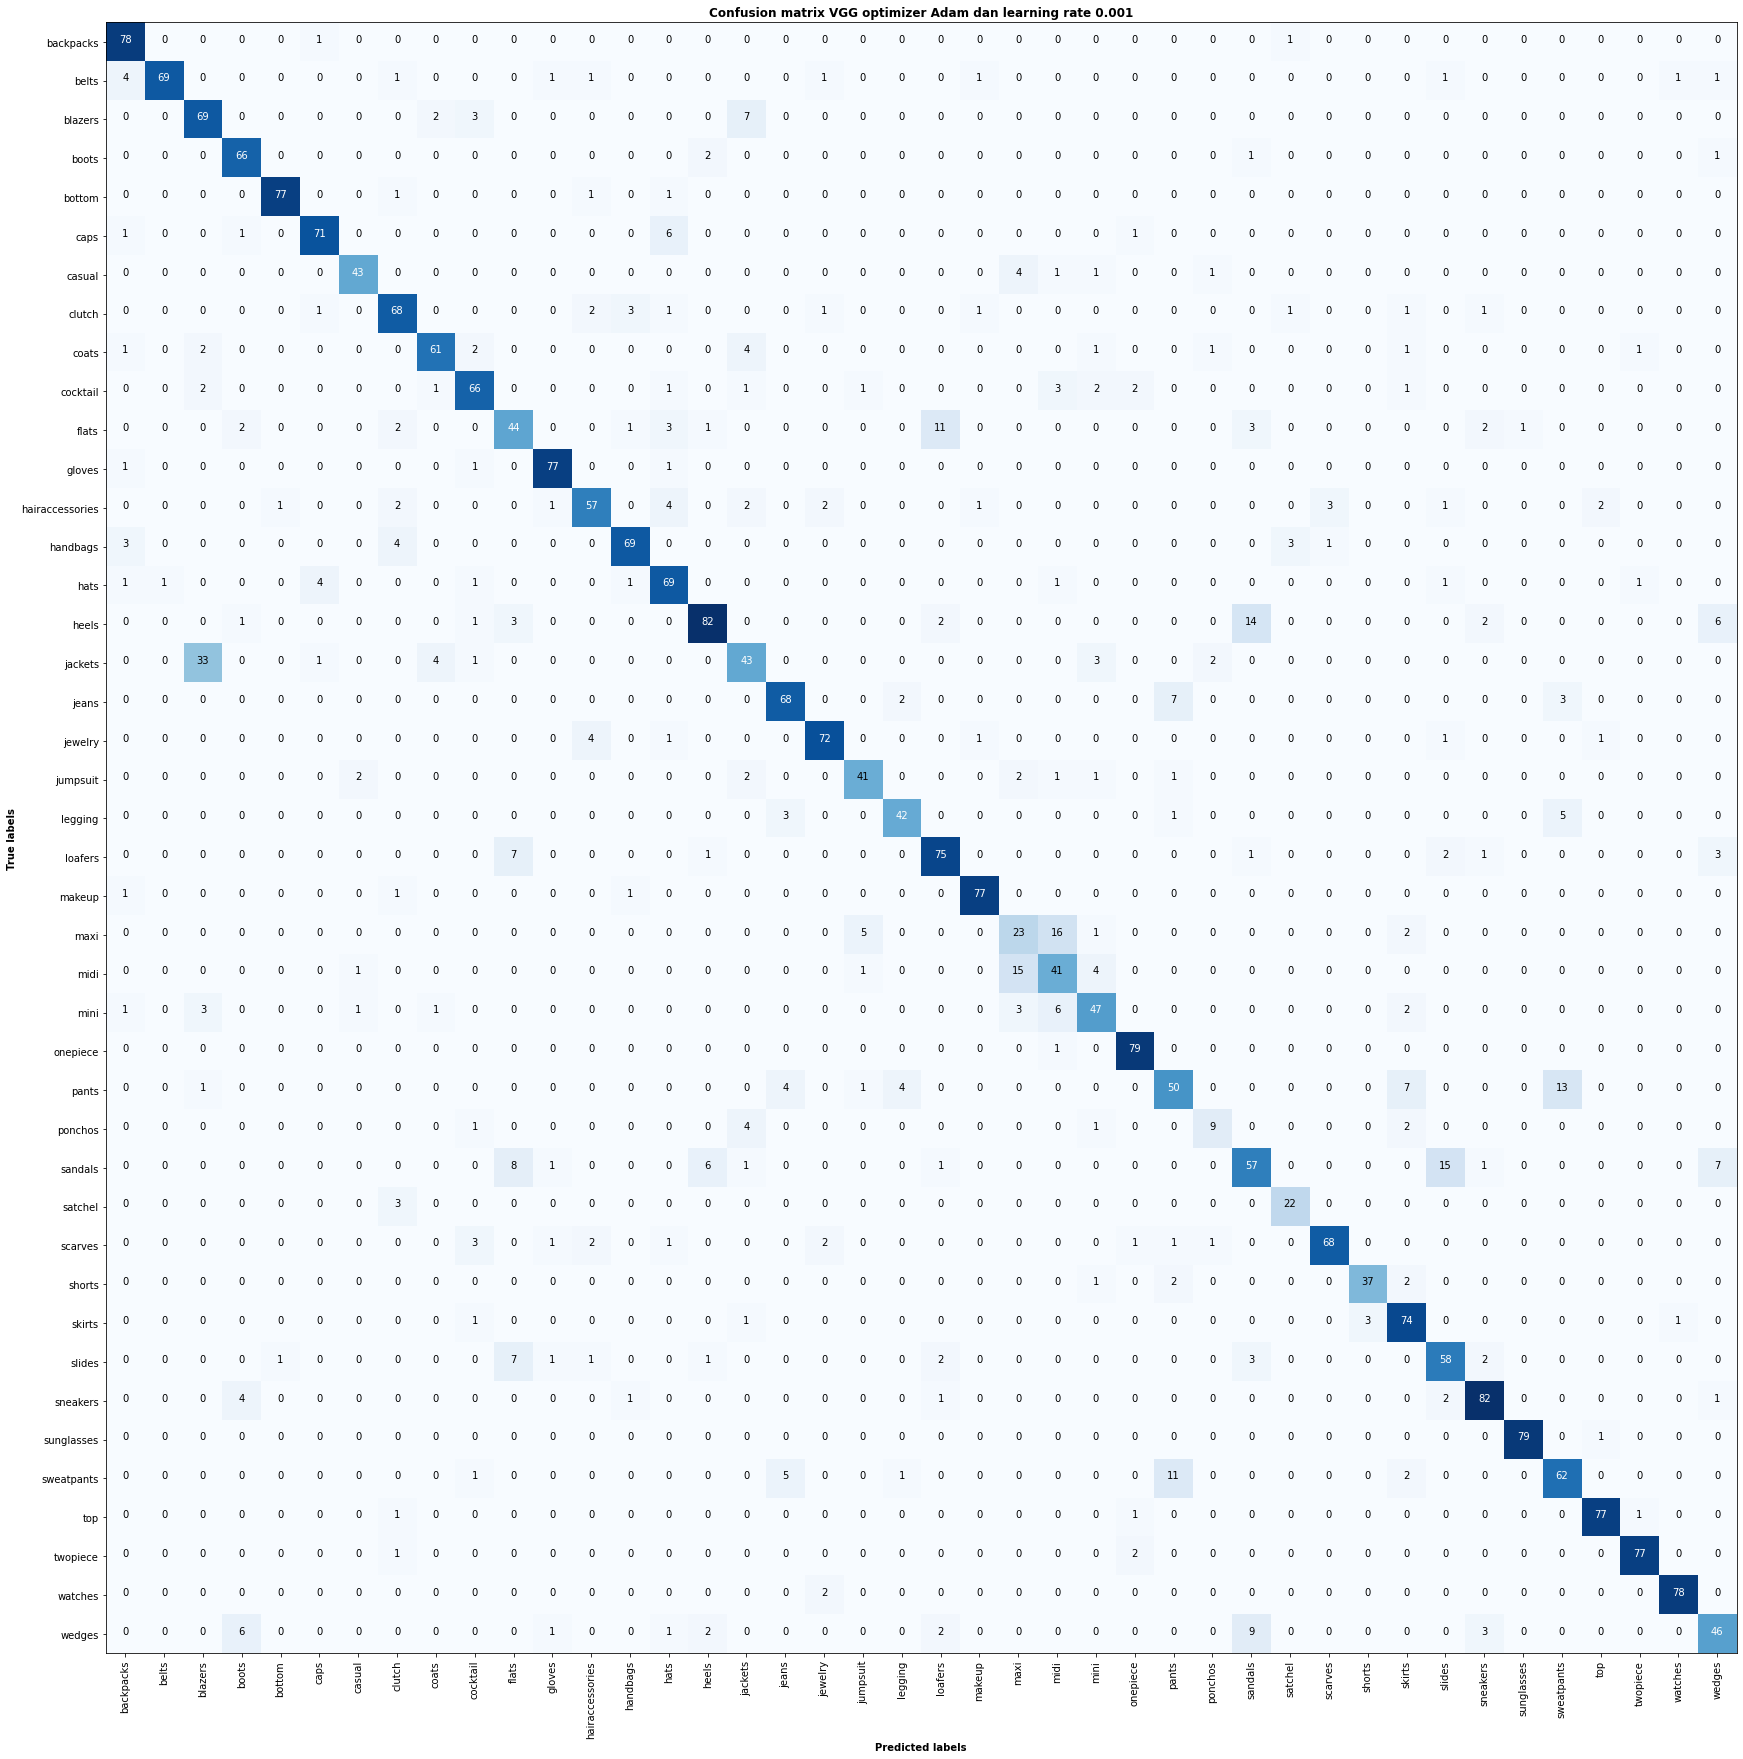

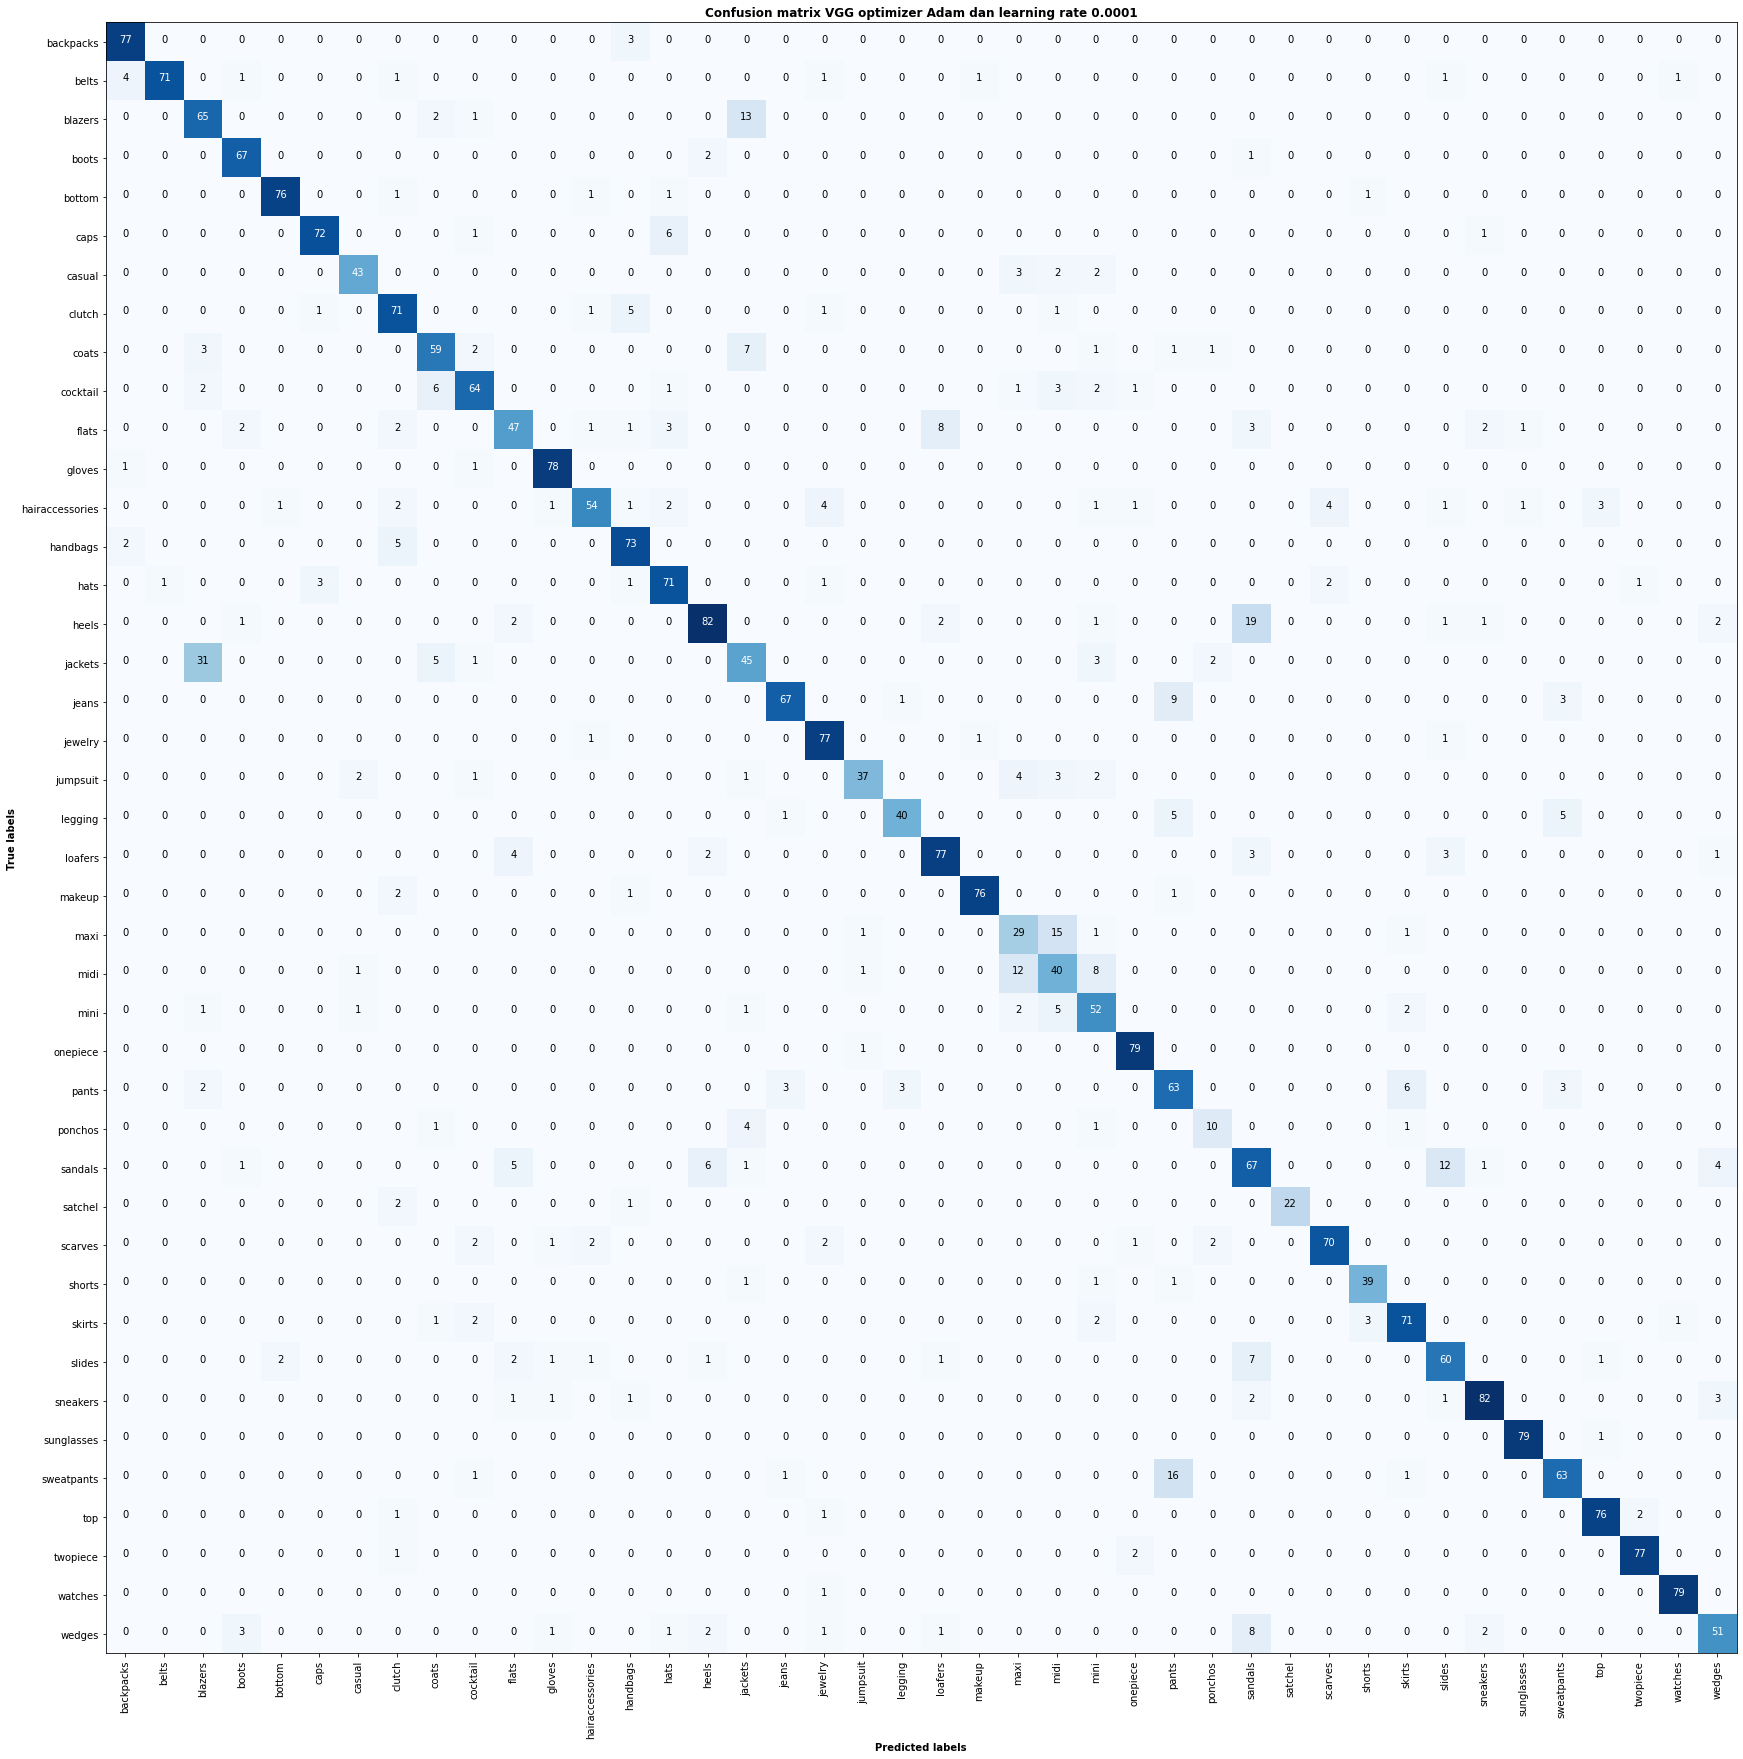

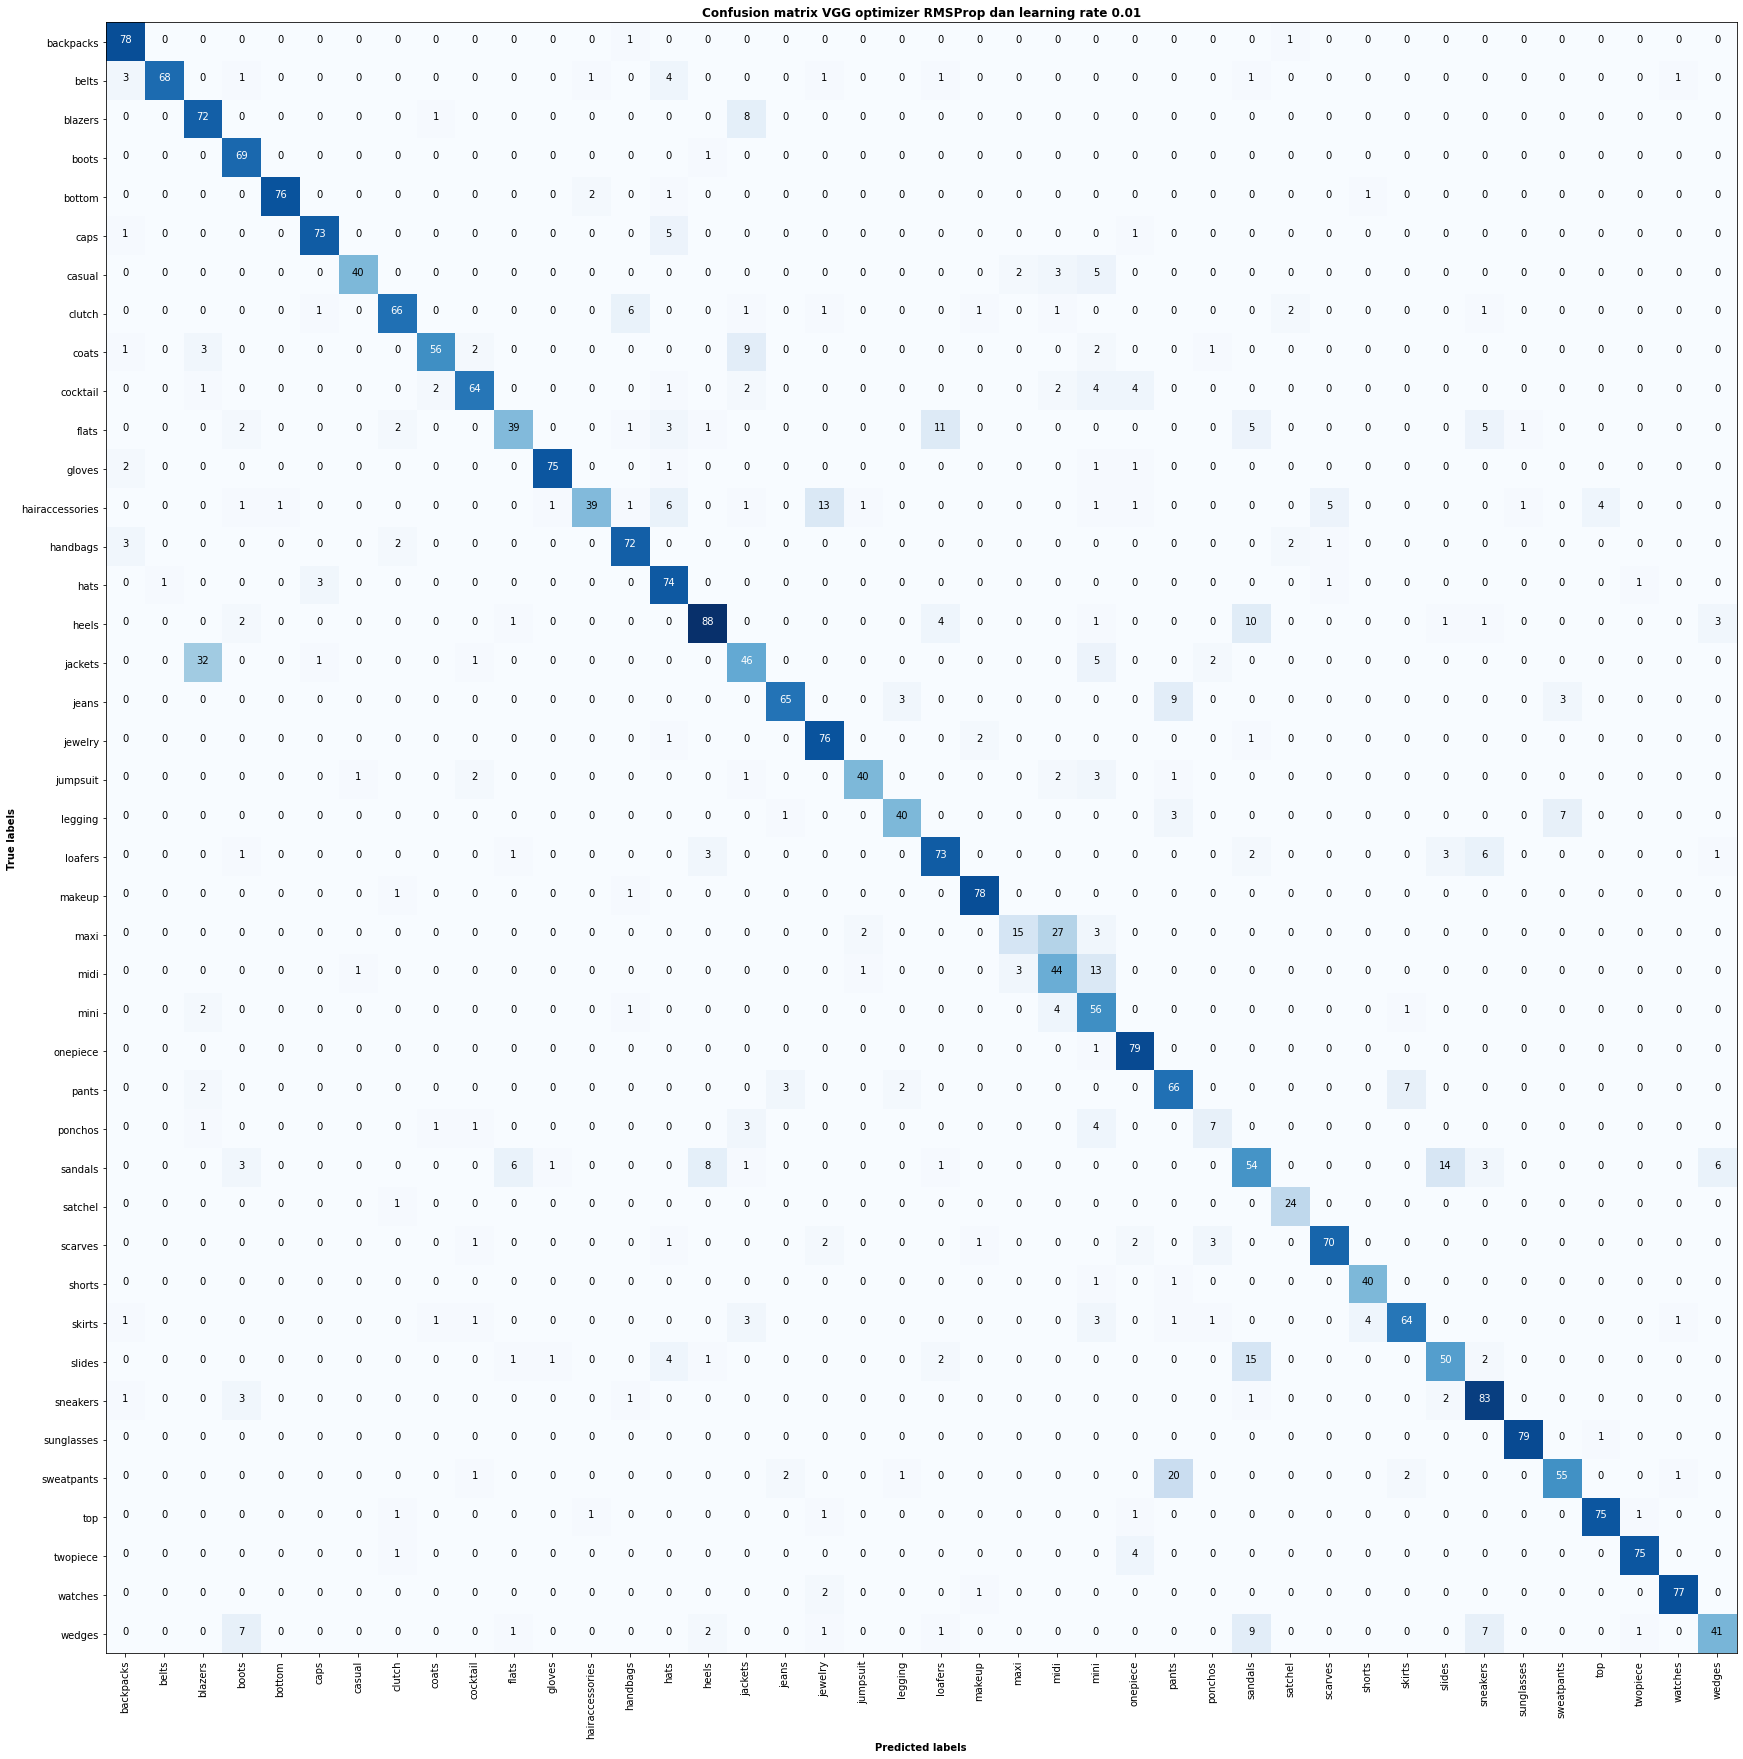

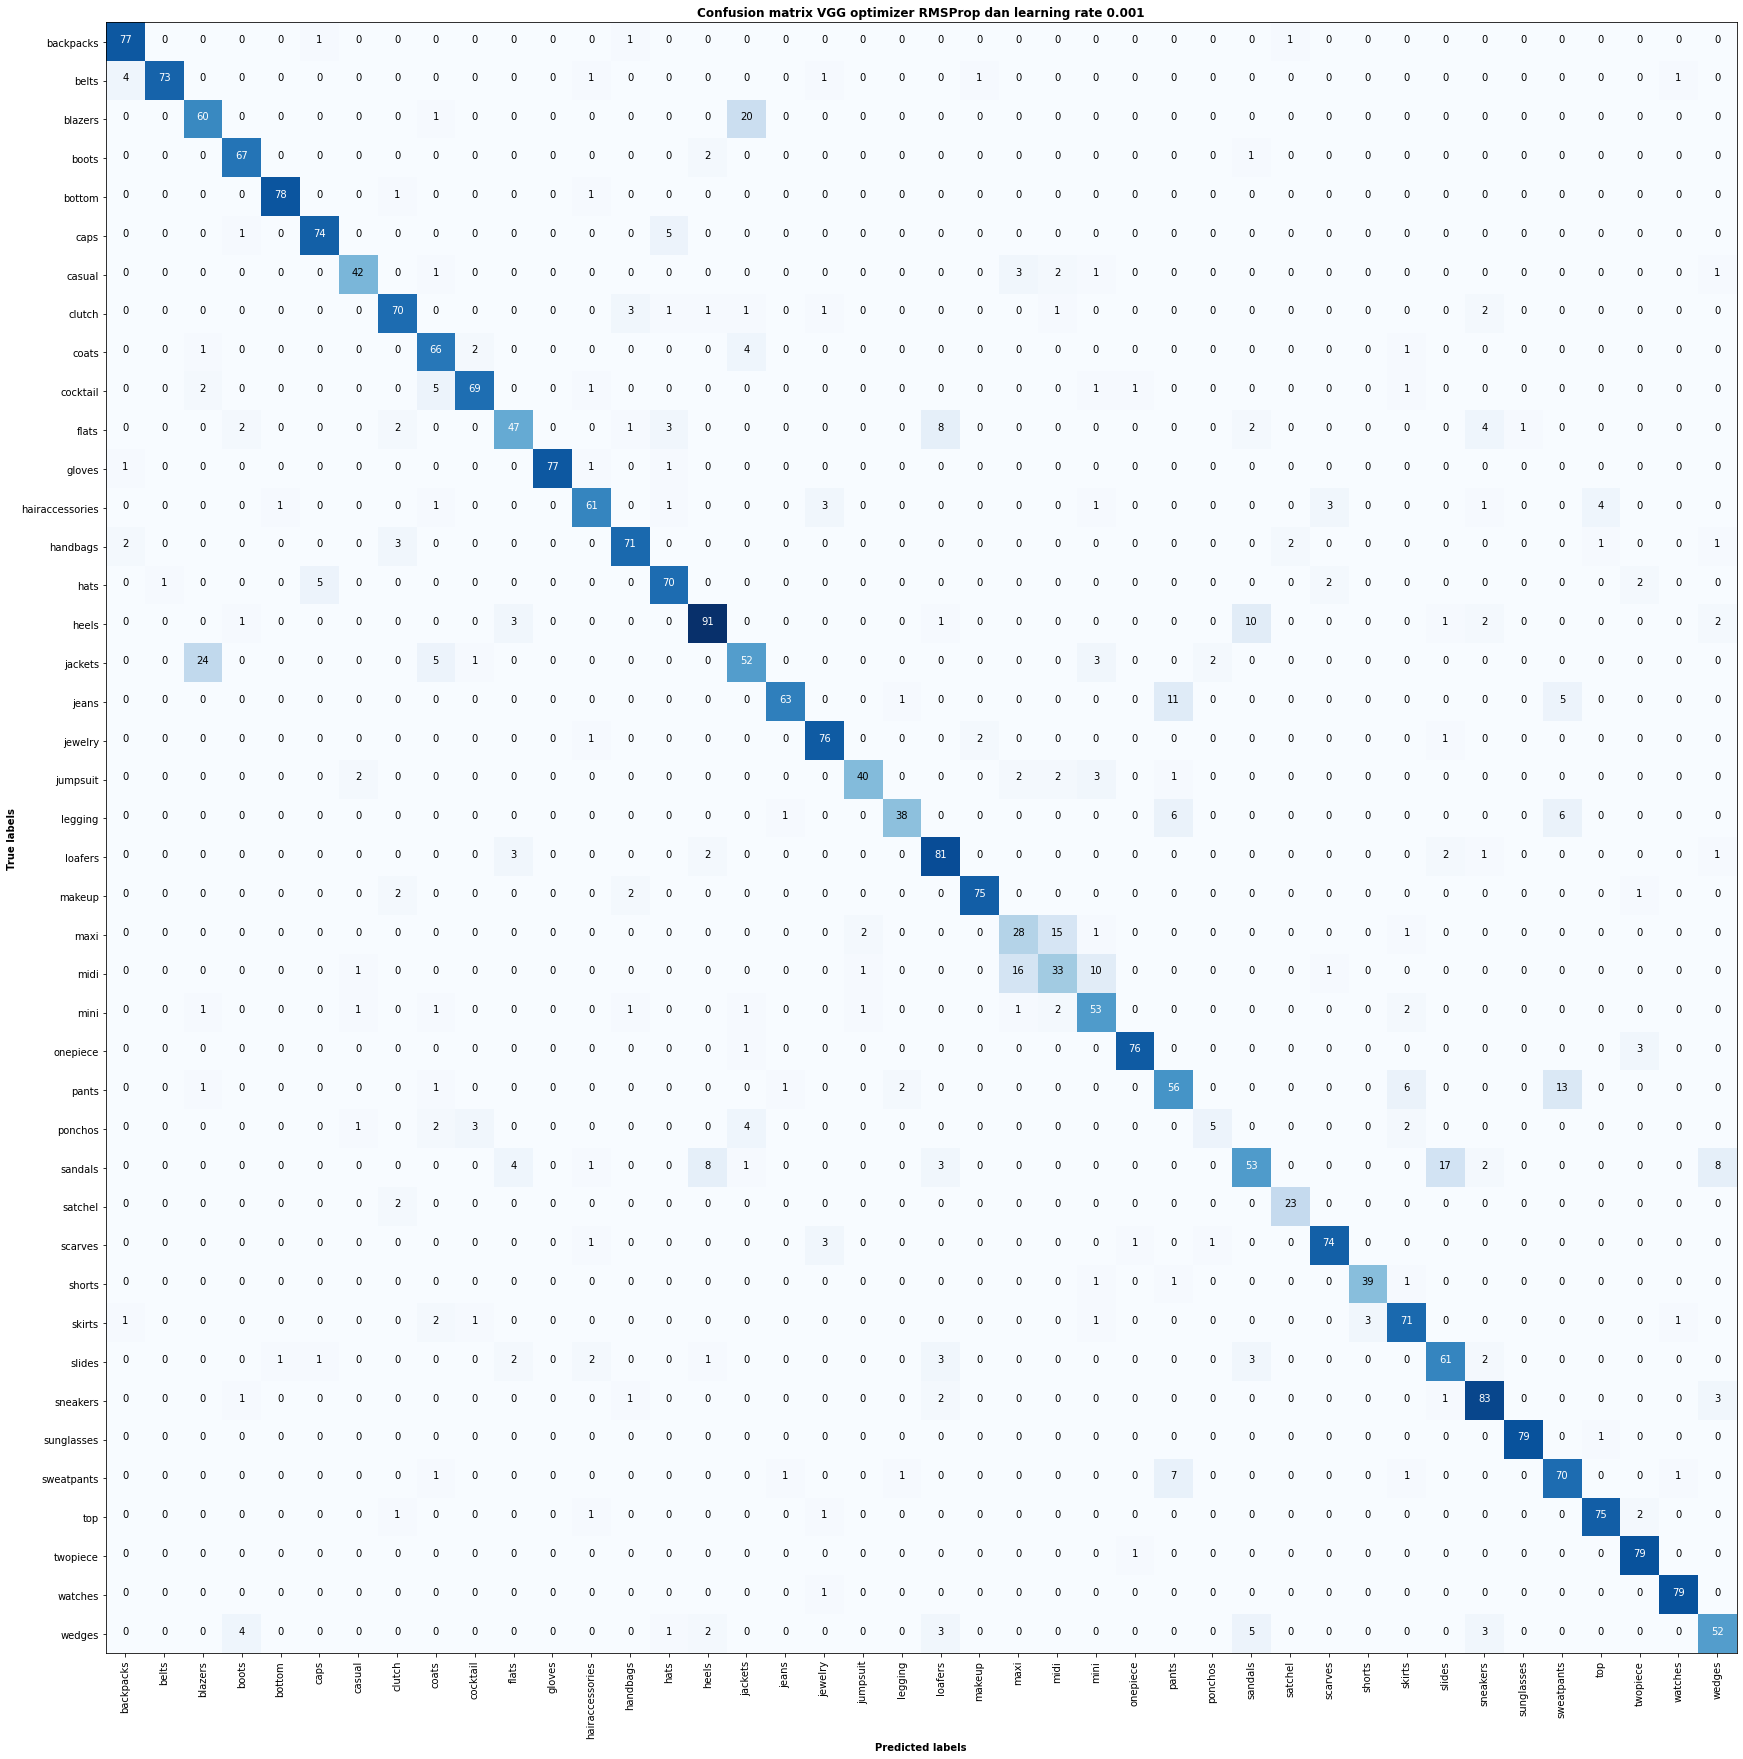

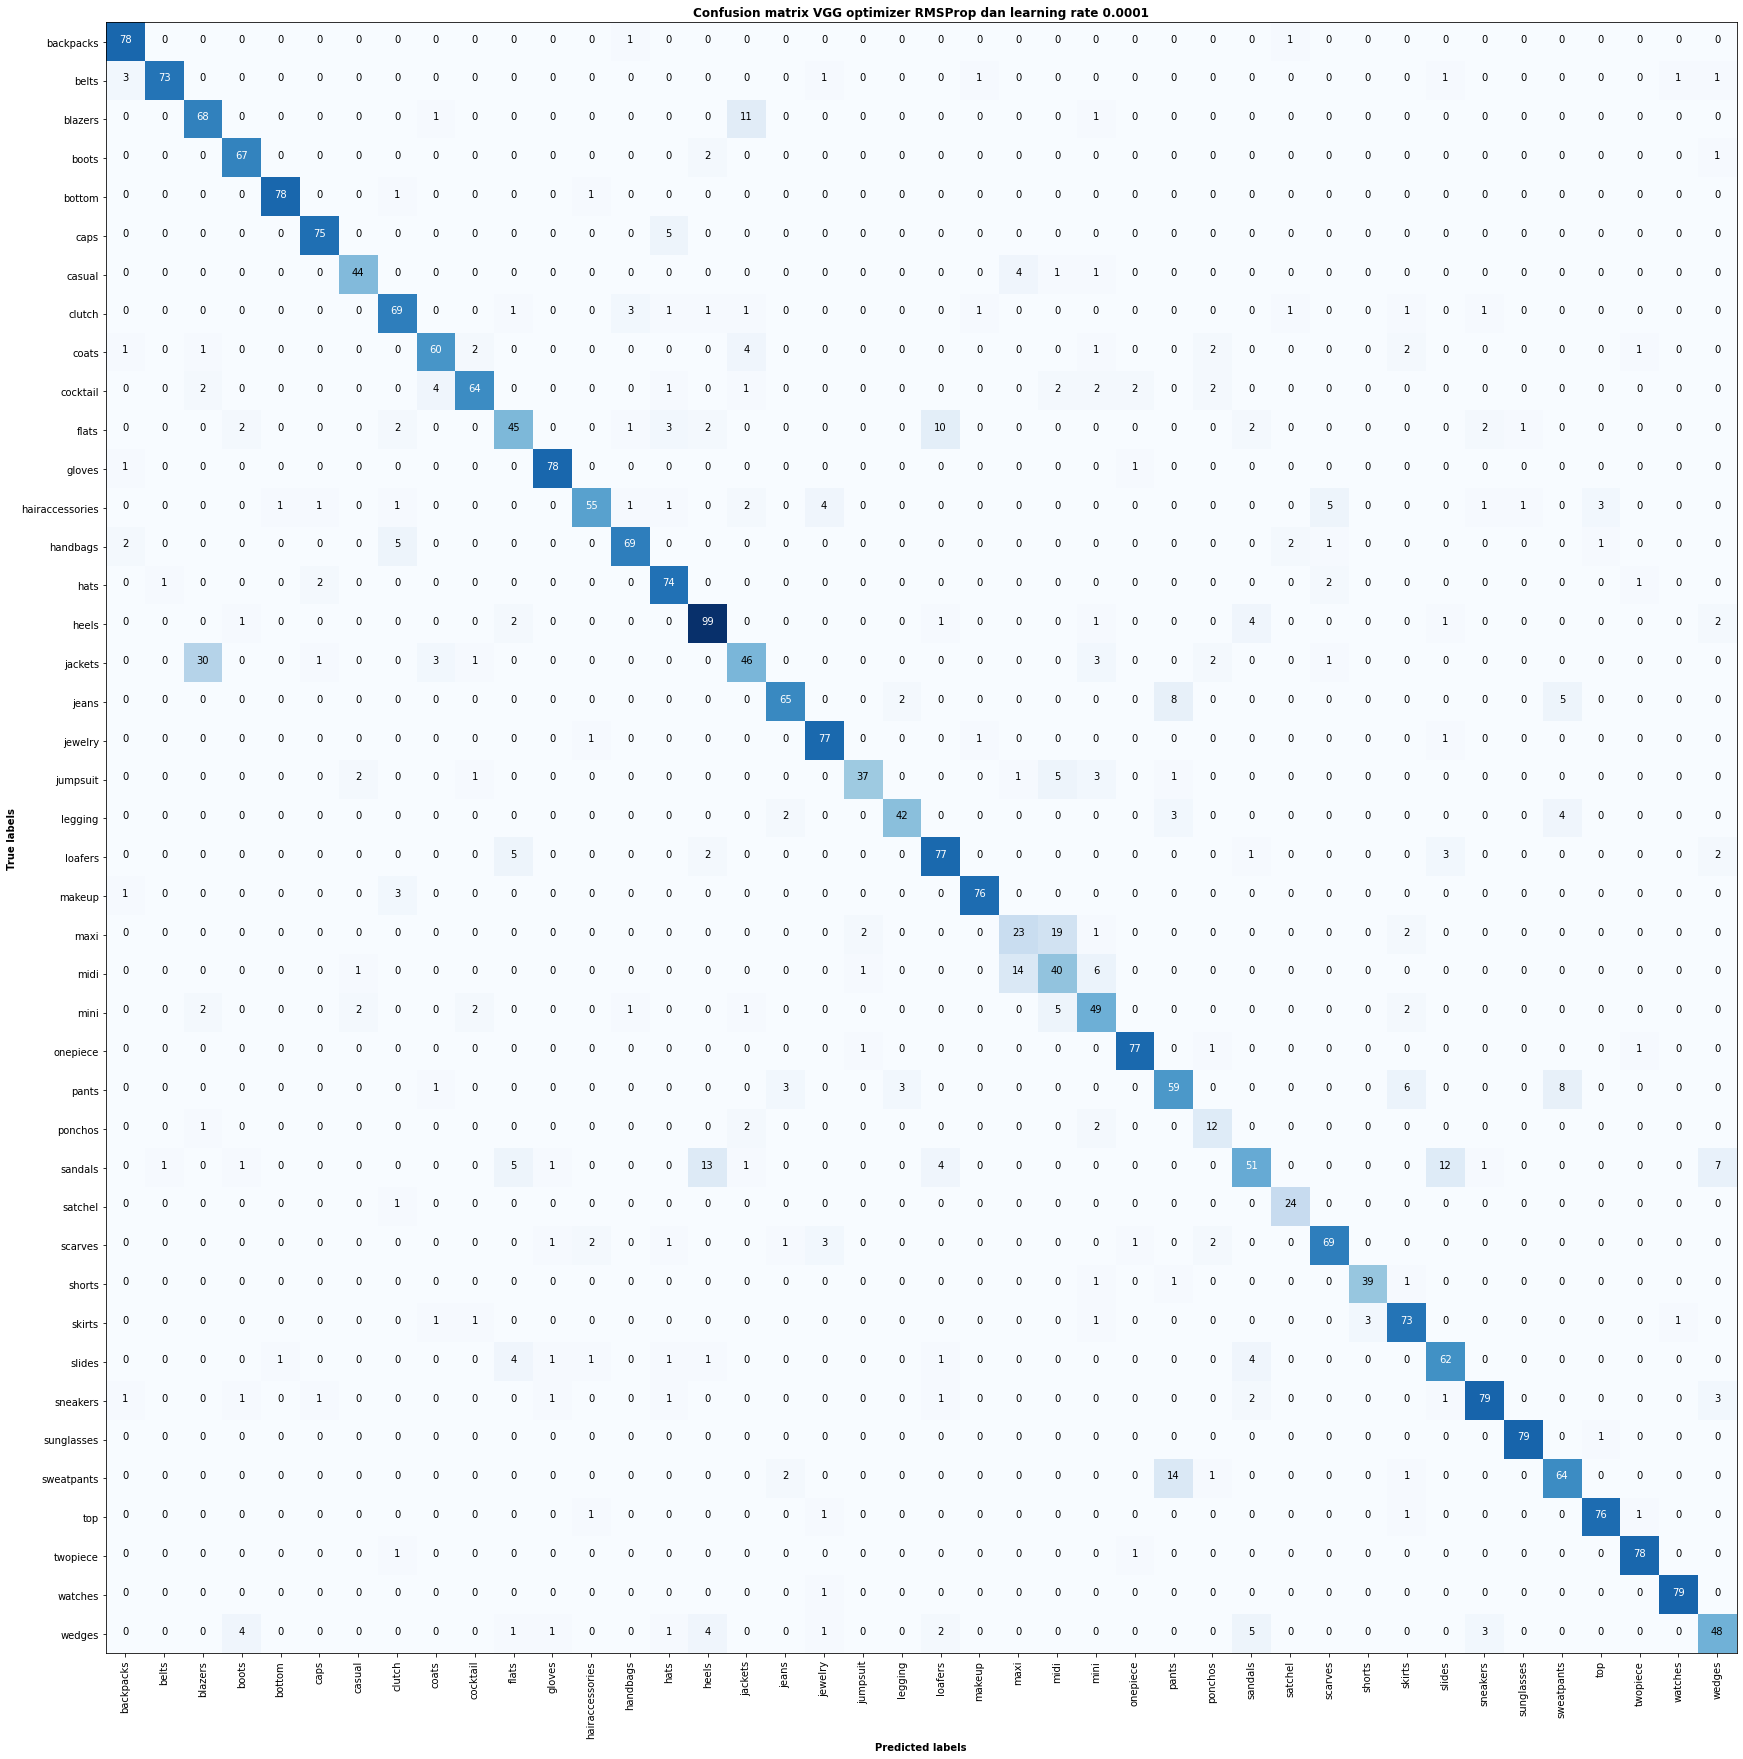

In [ ]:
# Visualisasi menggunakan confusion matrix
for (x, y, z) in (zip(res_predict, opt, lr)):
  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  plot_confusion_matrix(confusion_matrix(true_classes, preds), class_labels, f"VGG optimizer {y} dan learning rate {z}")

#### 6.2.2 Model resnet

In [ ]:
res_predict = [pred_resnet_adam1, pred_resnet_adam2, pred_resnet_adam3, pred_resnet_rmsprop1, pred_resnet_rmsprop2, pred_resnet_rmsprop3]
for (x, y, z) in (zip(res_predict, opt, lr)):
  print(f"\n++++++++++++++++++++++++ Model ResNet ++++++++++++++++++++++++")
  print(f"++++++++++ optimizer {y} dan learning rate {z} ++++++++++\n")

  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  print(classification_report(true_classes, preds, target_names=class_labels))


++++++++++++++++++++++++ Model VGG ++++++++++++++++++++++++
++++++++++ optimizer Adam dan learning rate 0.01 ++++++++++

                 precision    recall  f1-score   support

      backpacks       0.94      0.97      0.96        80
          belts       0.97      0.94      0.96        81
        blazers       0.57      0.96      0.72        81
          boots       0.91      0.89      0.90        70
         bottom       0.97      0.97      0.97        80
           caps       0.99      0.94      0.96        80
         casual       0.98      0.84      0.90        50
         clutch       0.86      0.88      0.87        80
          coats       0.89      0.74      0.81        74
       cocktail       0.88      0.85      0.87        80
          flats       0.69      0.60      0.64        70
         gloves       0.96      0.97      0.97        80
hairaccessories       0.89      0.67      0.77        76
       handbags       0.93      0.88      0.90        80
           hats       

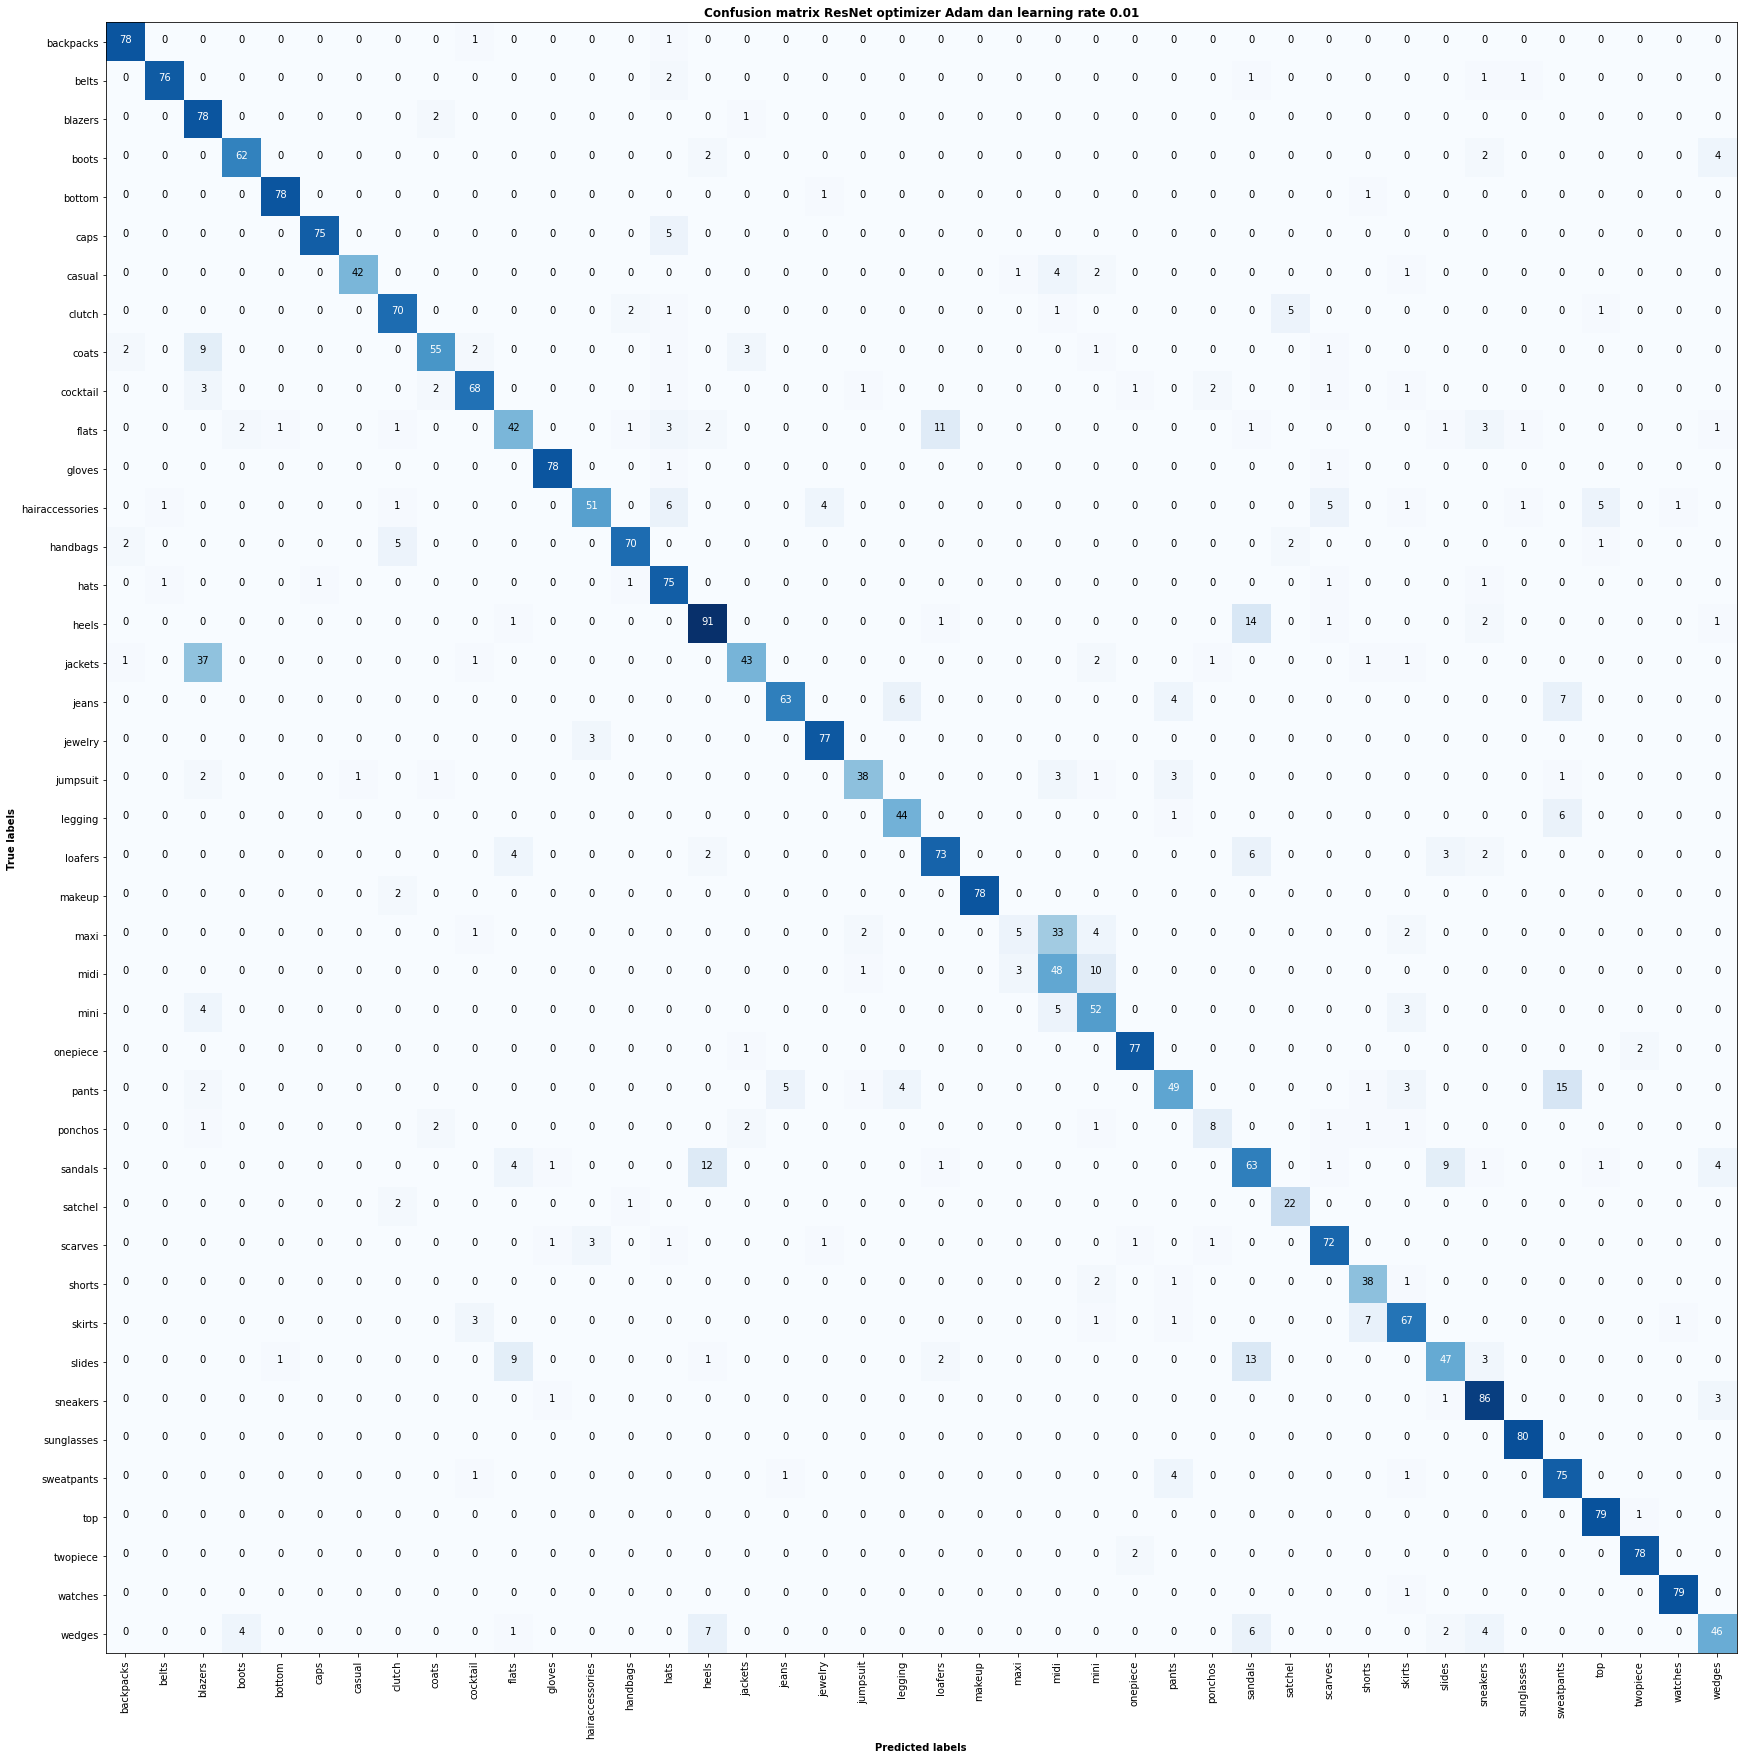

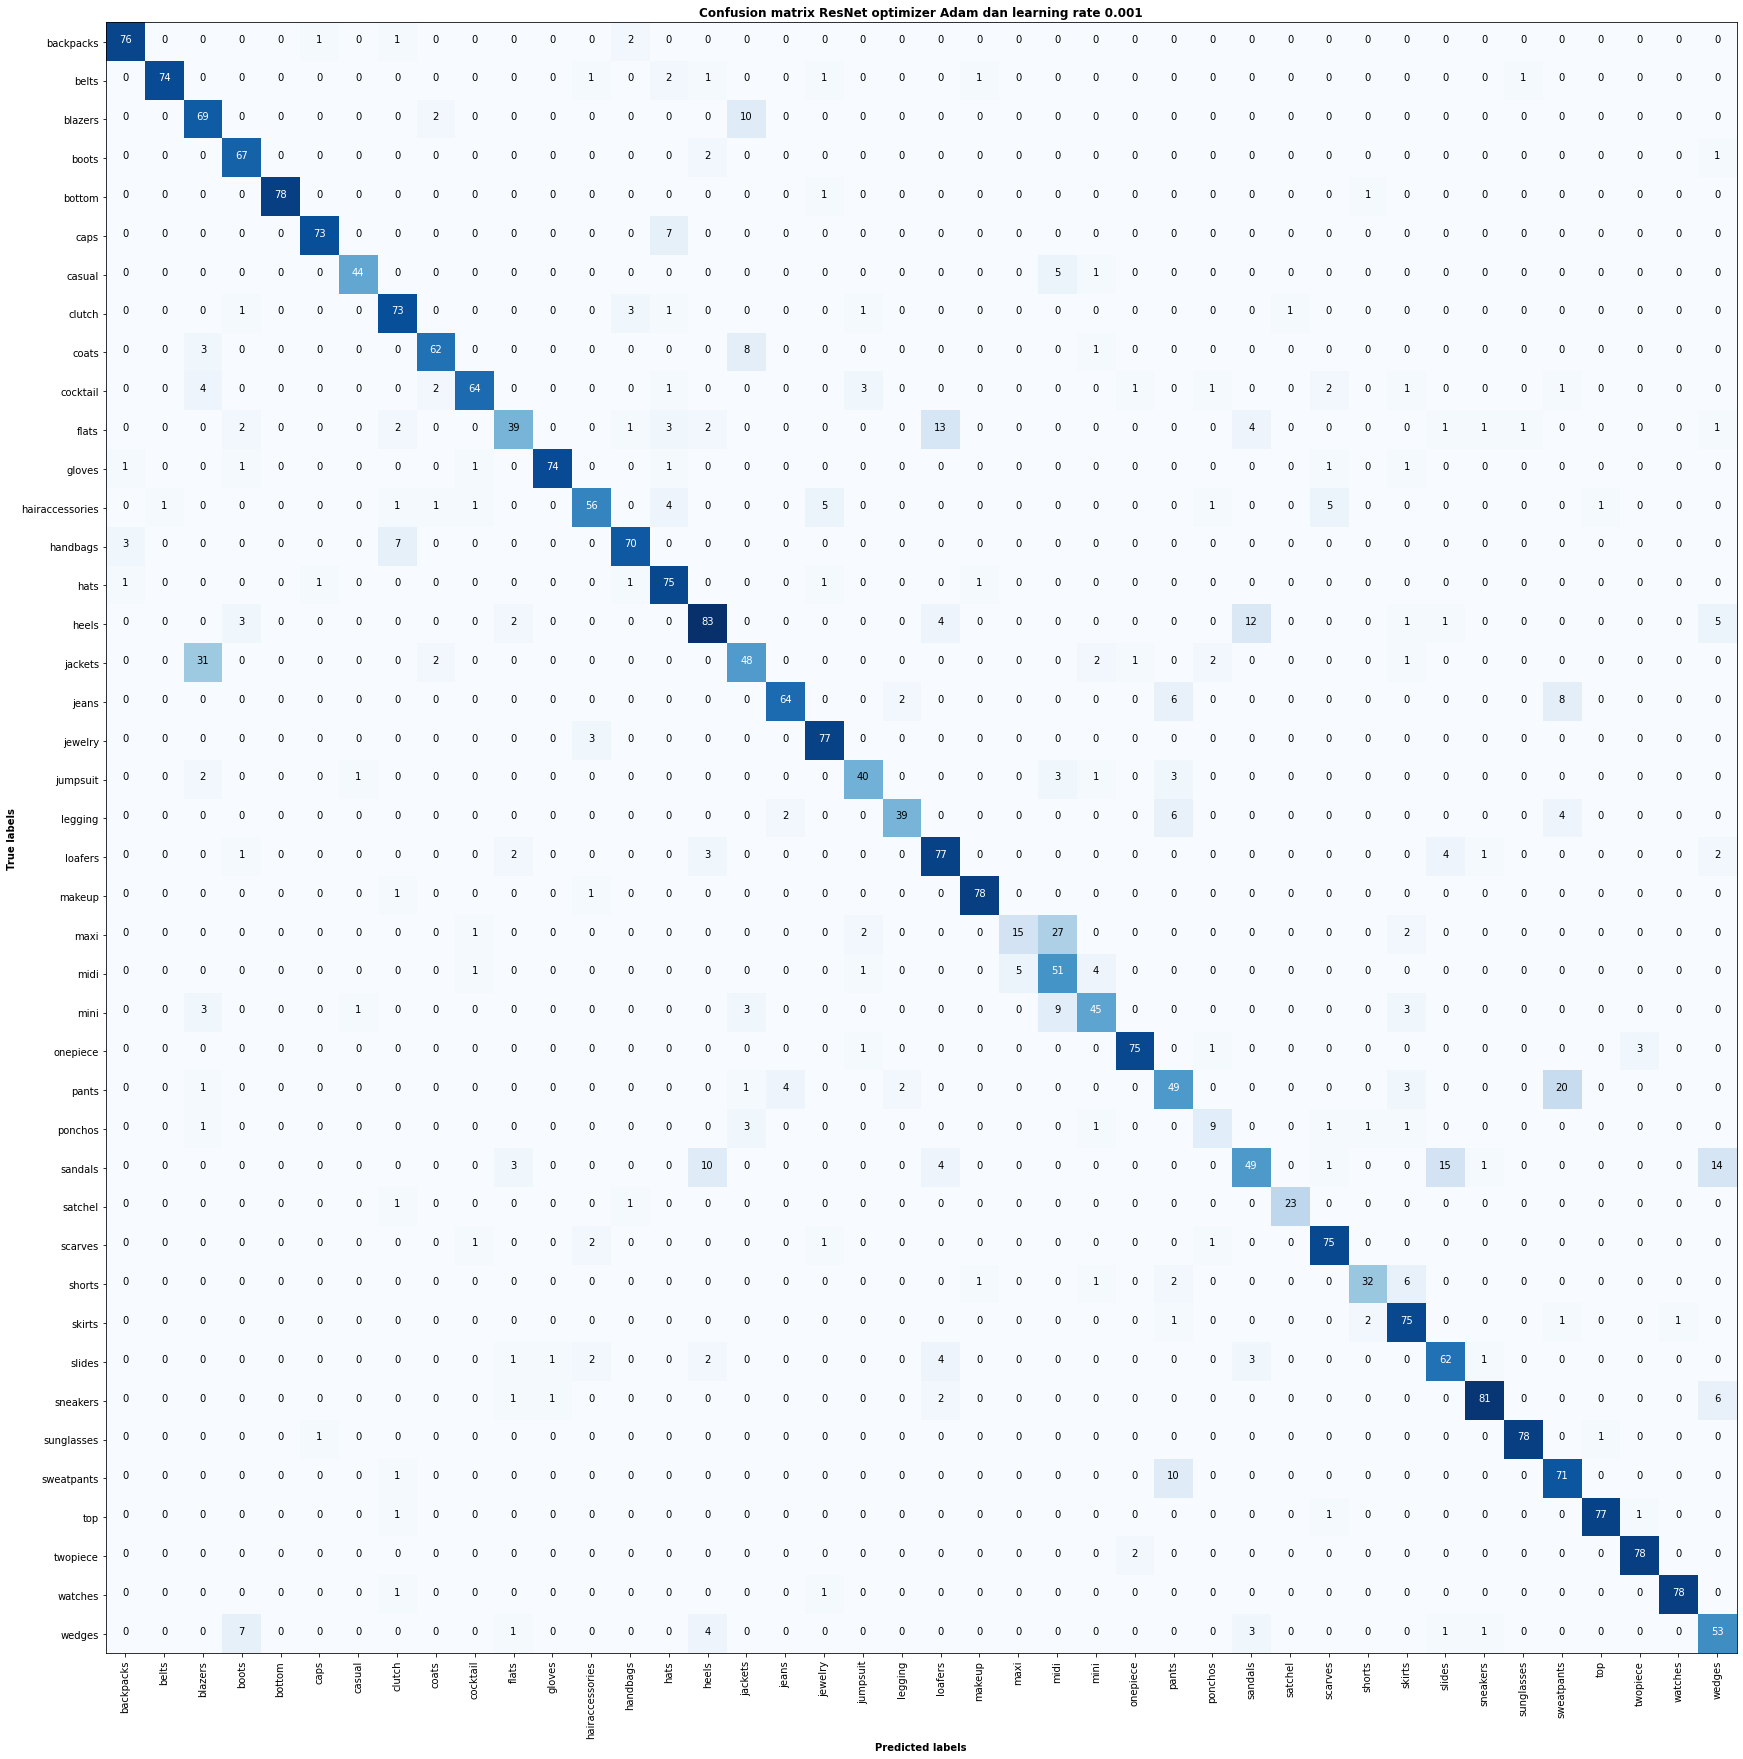

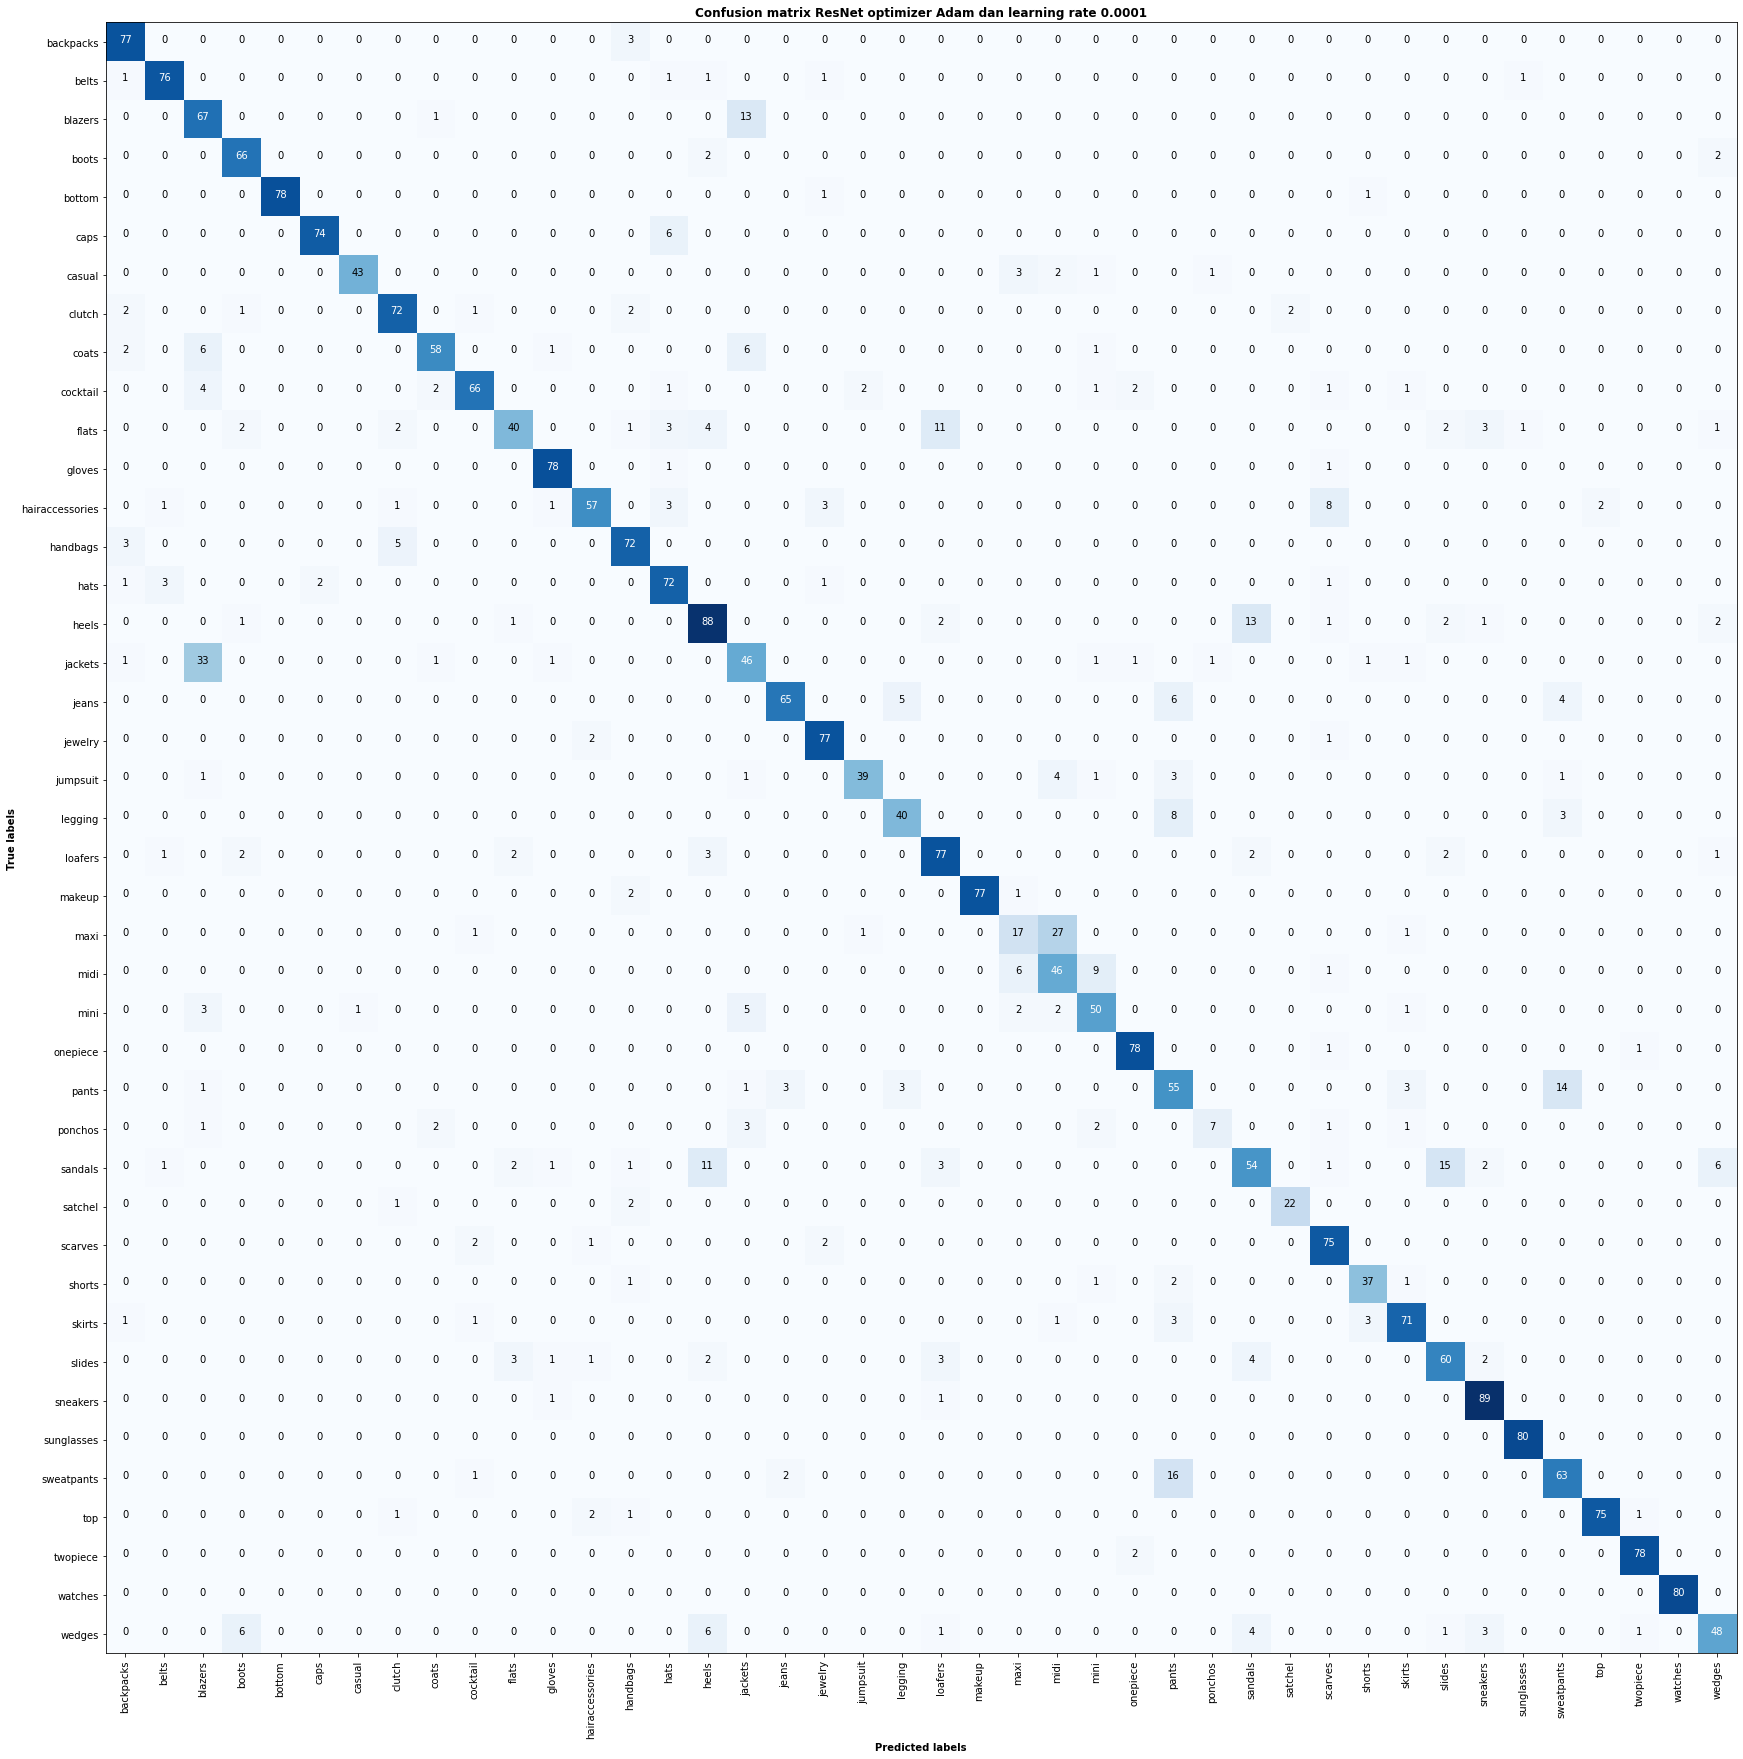

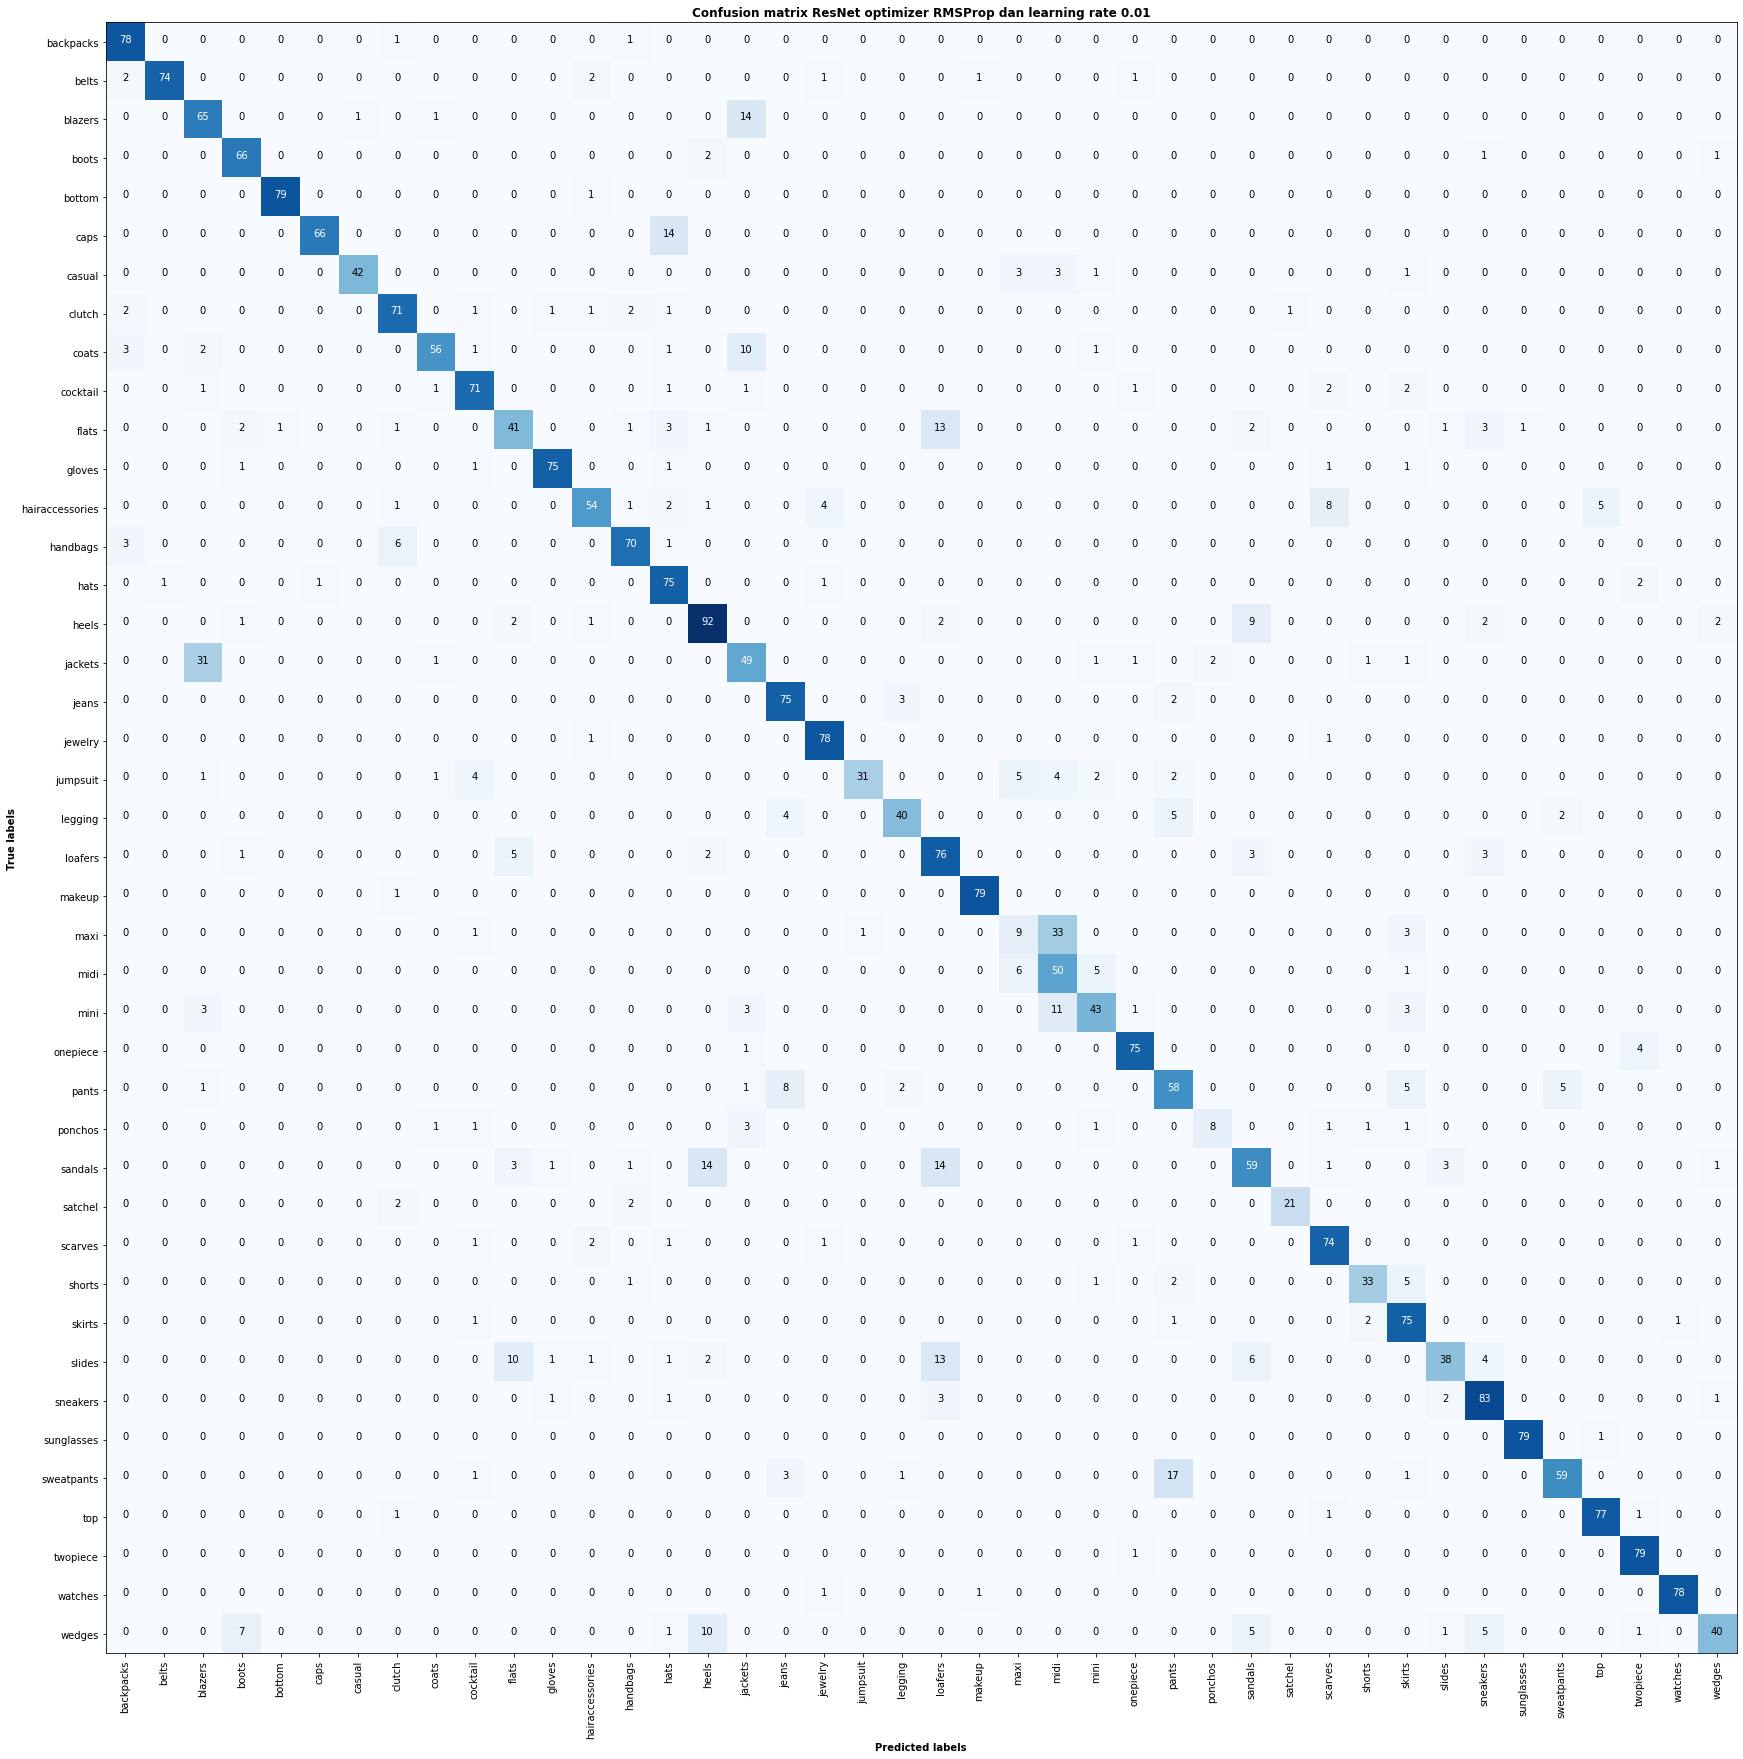

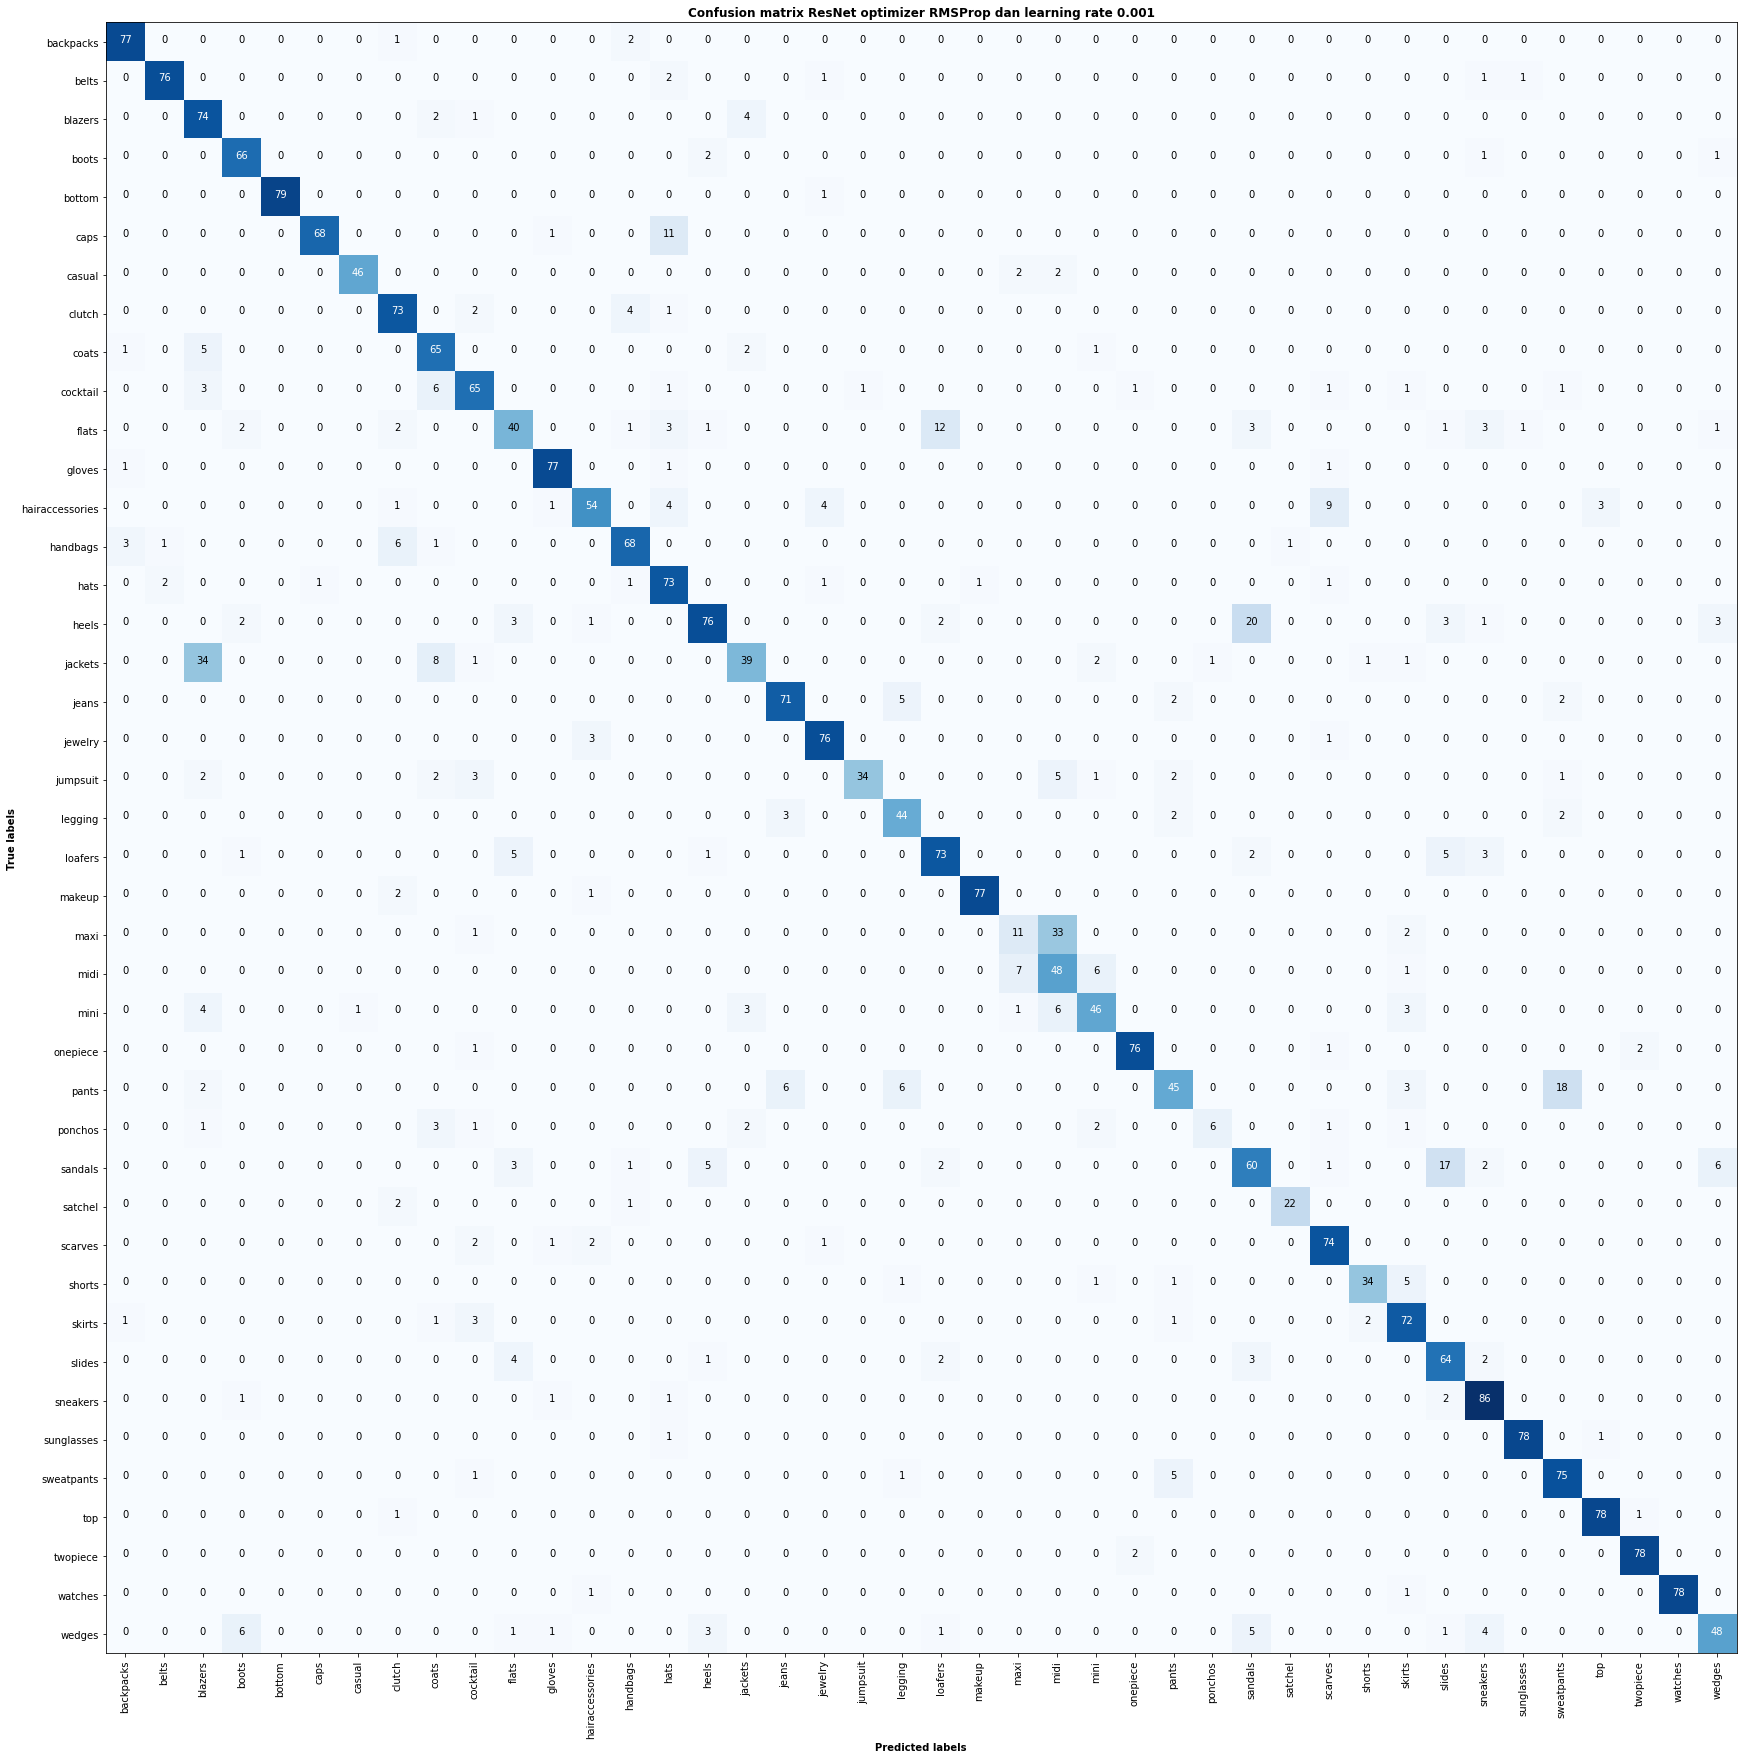

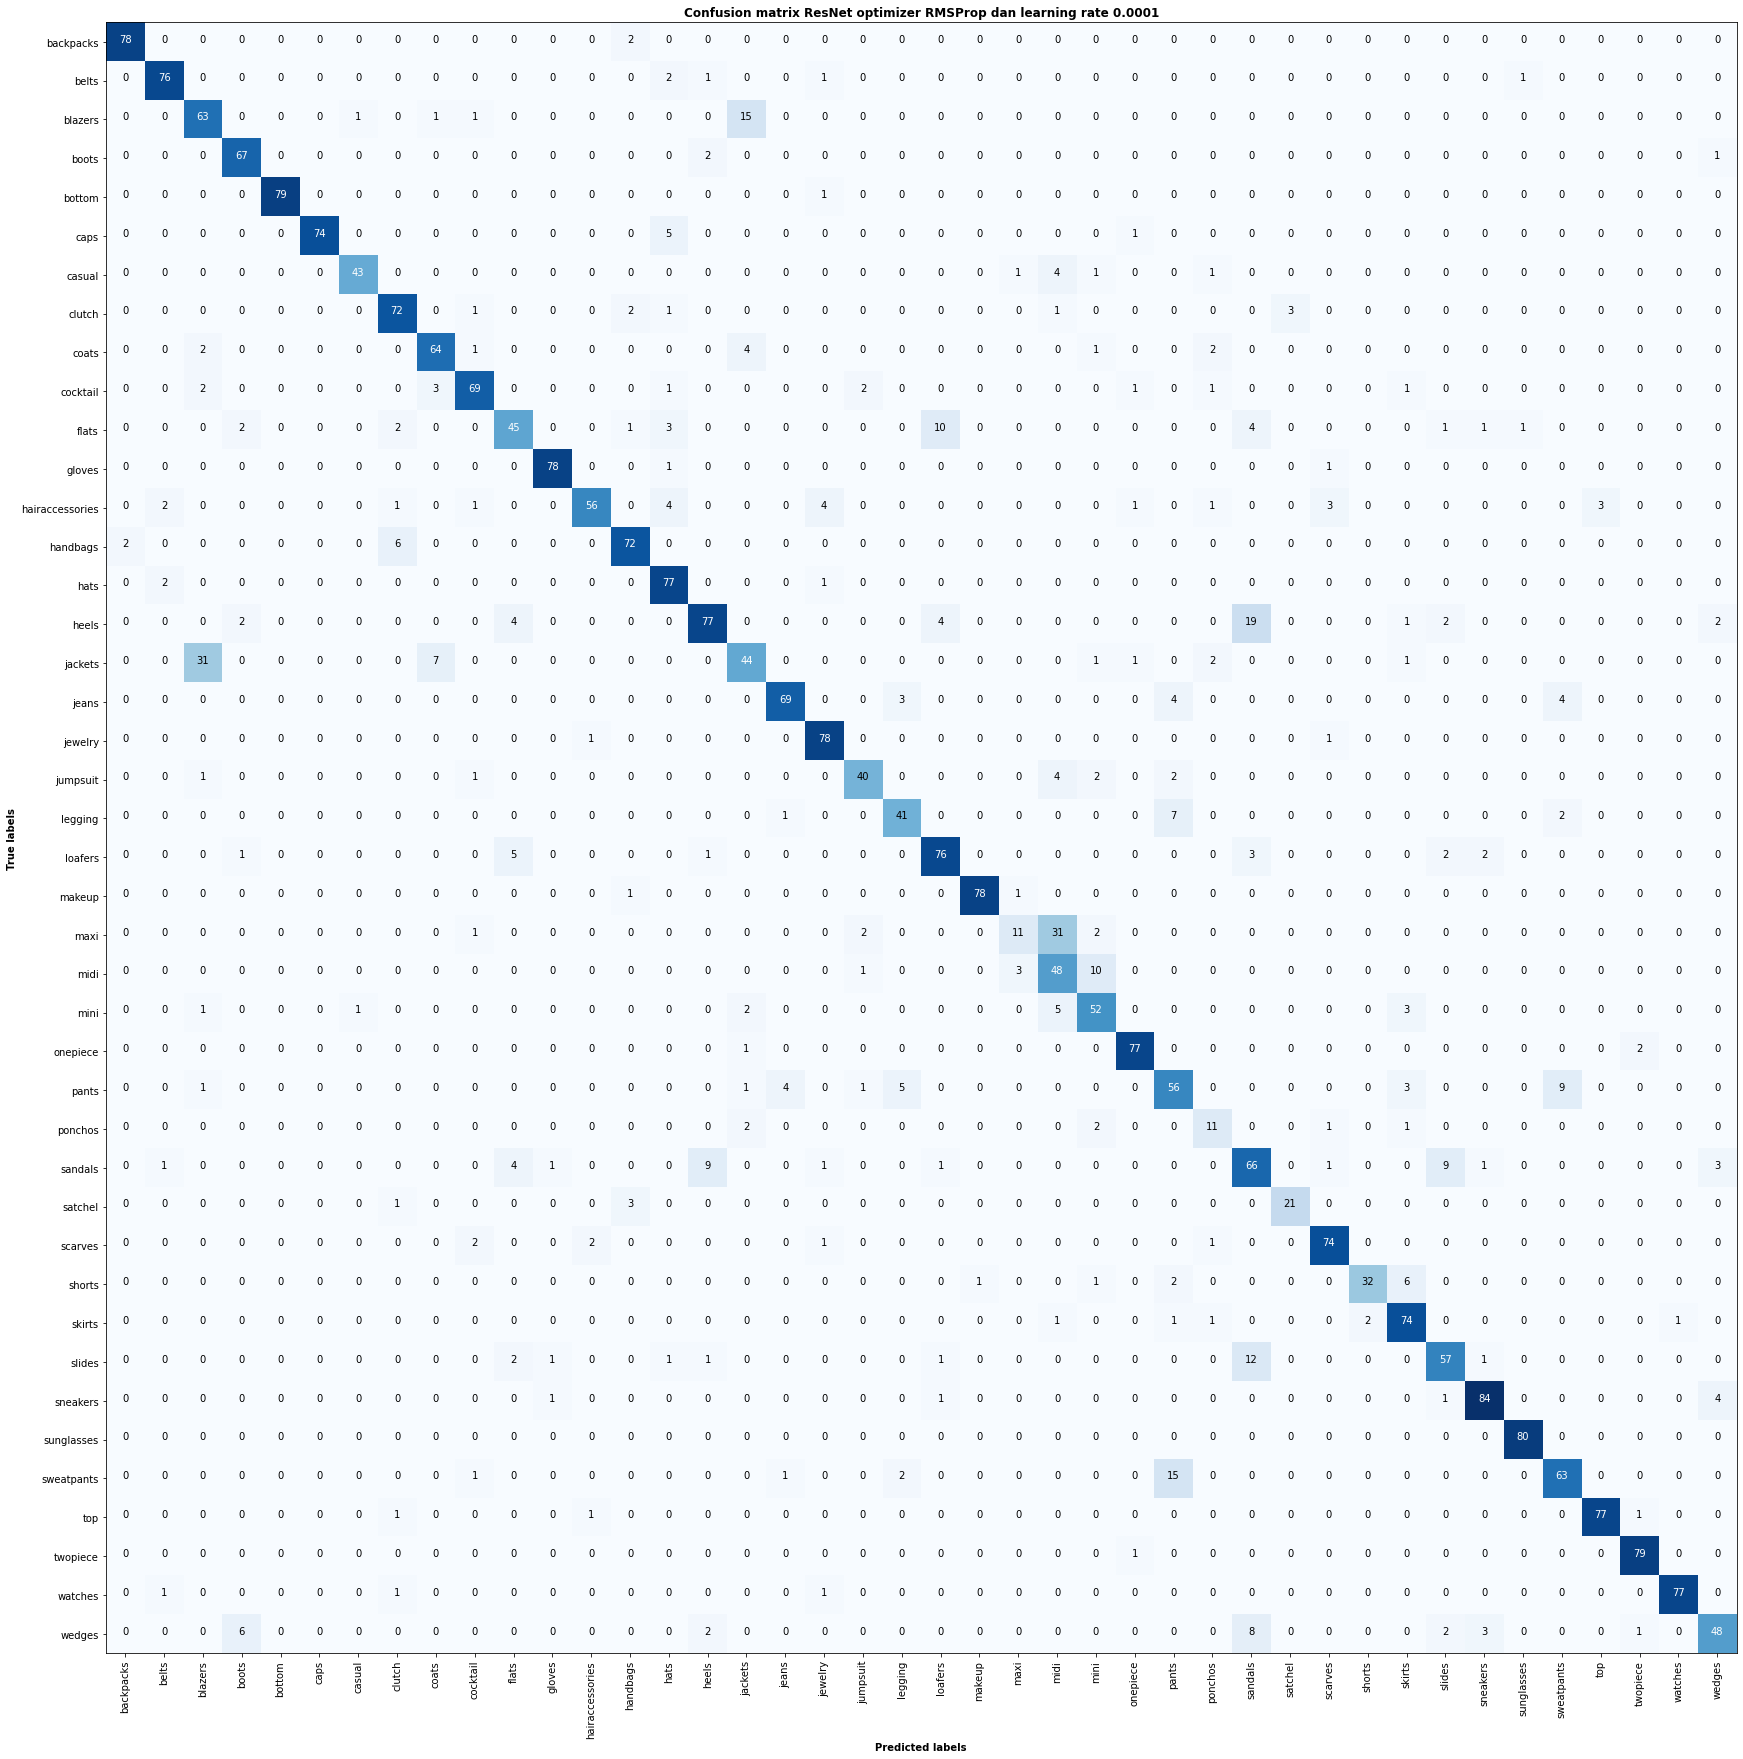

In [ ]:
# Visualisasi menggunakan confusion matrix
for (x, y, z) in (zip(res_predict, opt, lr)):
  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  plot_confusion_matrix(confusion_matrix(true_classes, preds), class_labels, f"ResNet optimizer {y} dan learning rate {z}")

#### 6.2.3 Model sendiri

In [ ]:
res_predict = [pred_own_adam1, pred_own_adam2, pred_own_adam3, pred_own_rmsprop1, pred_own_rmsprop2, pred_own_rmsprop3]
for (x, y, z) in (zip(res_predict, opt, lr)):
  print(f"\n++++++++++++++++++++++++ Model Sendiri ++++++++++++++++++++++++")
  print(f"++++++++++ optimizer {y} dan learning rate {z} ++++++++++\n")

  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  print(classification_report(true_classes, preds, target_names=class_labels))


++++++++++++++++++++++++ Model VGG ++++++++++++++++++++++++
++++++++++ optimizer Adam dan learning rate 0.01 ++++++++++

                 precision    recall  f1-score   support

      backpacks       0.80      0.91      0.85        80
          belts       0.62      0.75      0.68        81
        blazers       0.55      0.74      0.63        81
          boots       0.89      0.94      0.92        70
         bottom       0.96      0.91      0.94        80
           caps       0.90      0.69      0.78        80
         casual       0.73      0.76      0.75        50
         clutch       0.84      0.81      0.83        80
          coats       0.54      0.82      0.65        74
       cocktail       0.80      0.50      0.62        80
          flats       0.62      0.56      0.59        70
         gloves       0.85      0.82      0.84        80
hairaccessories       0.58      0.51      0.55        76
       handbags       0.83      0.78      0.80        80
           hats       

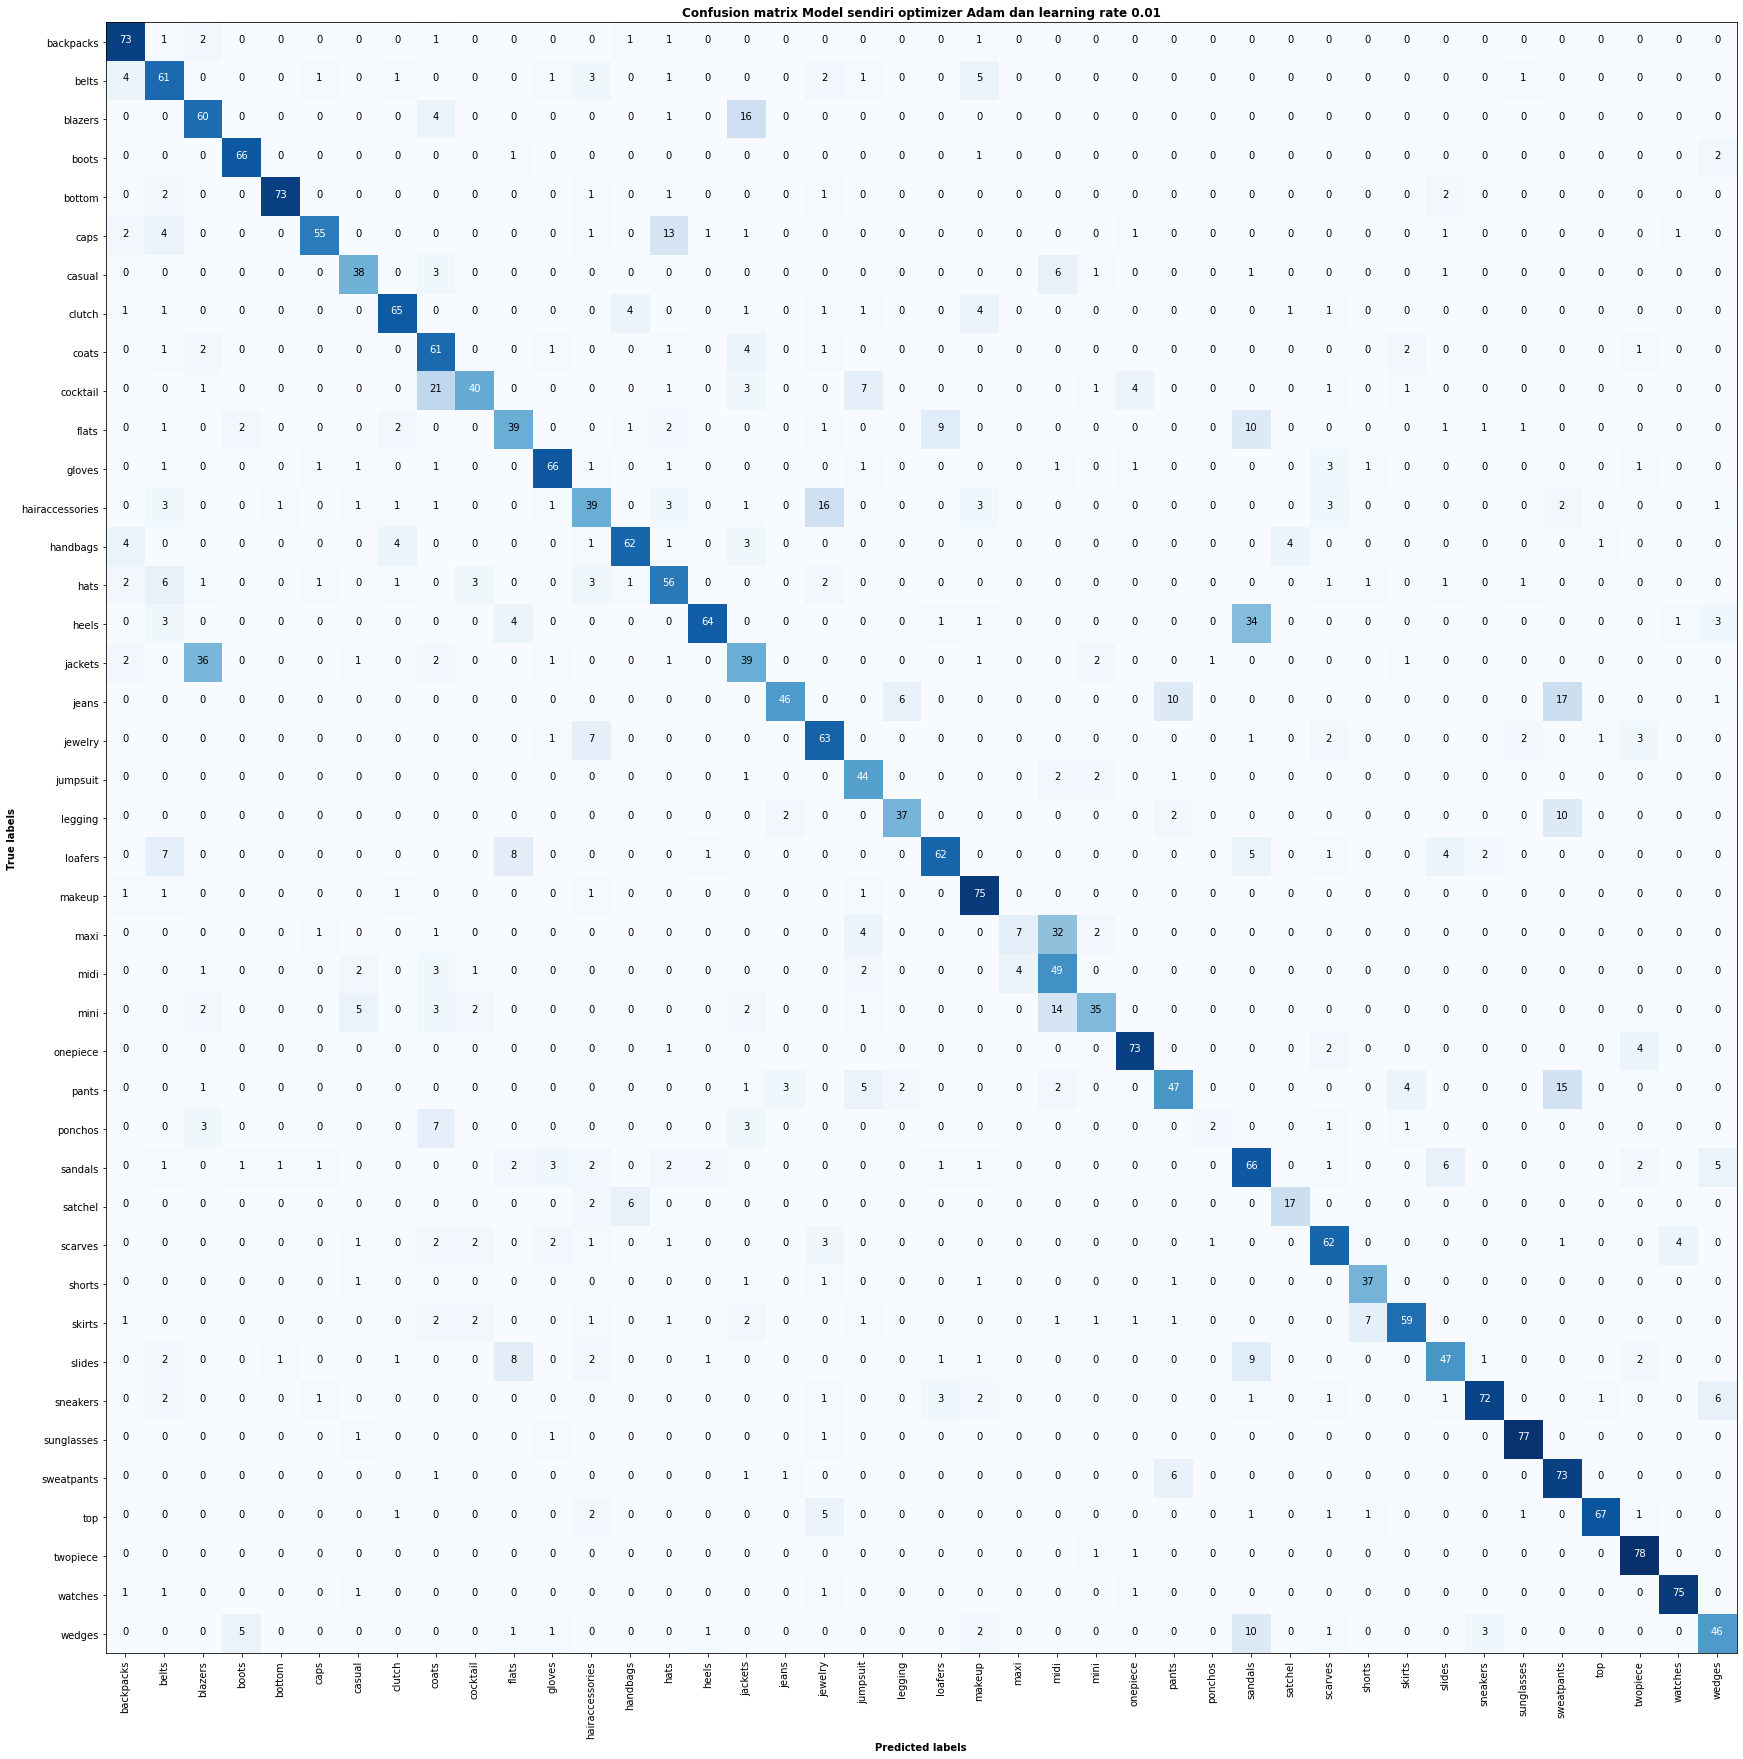

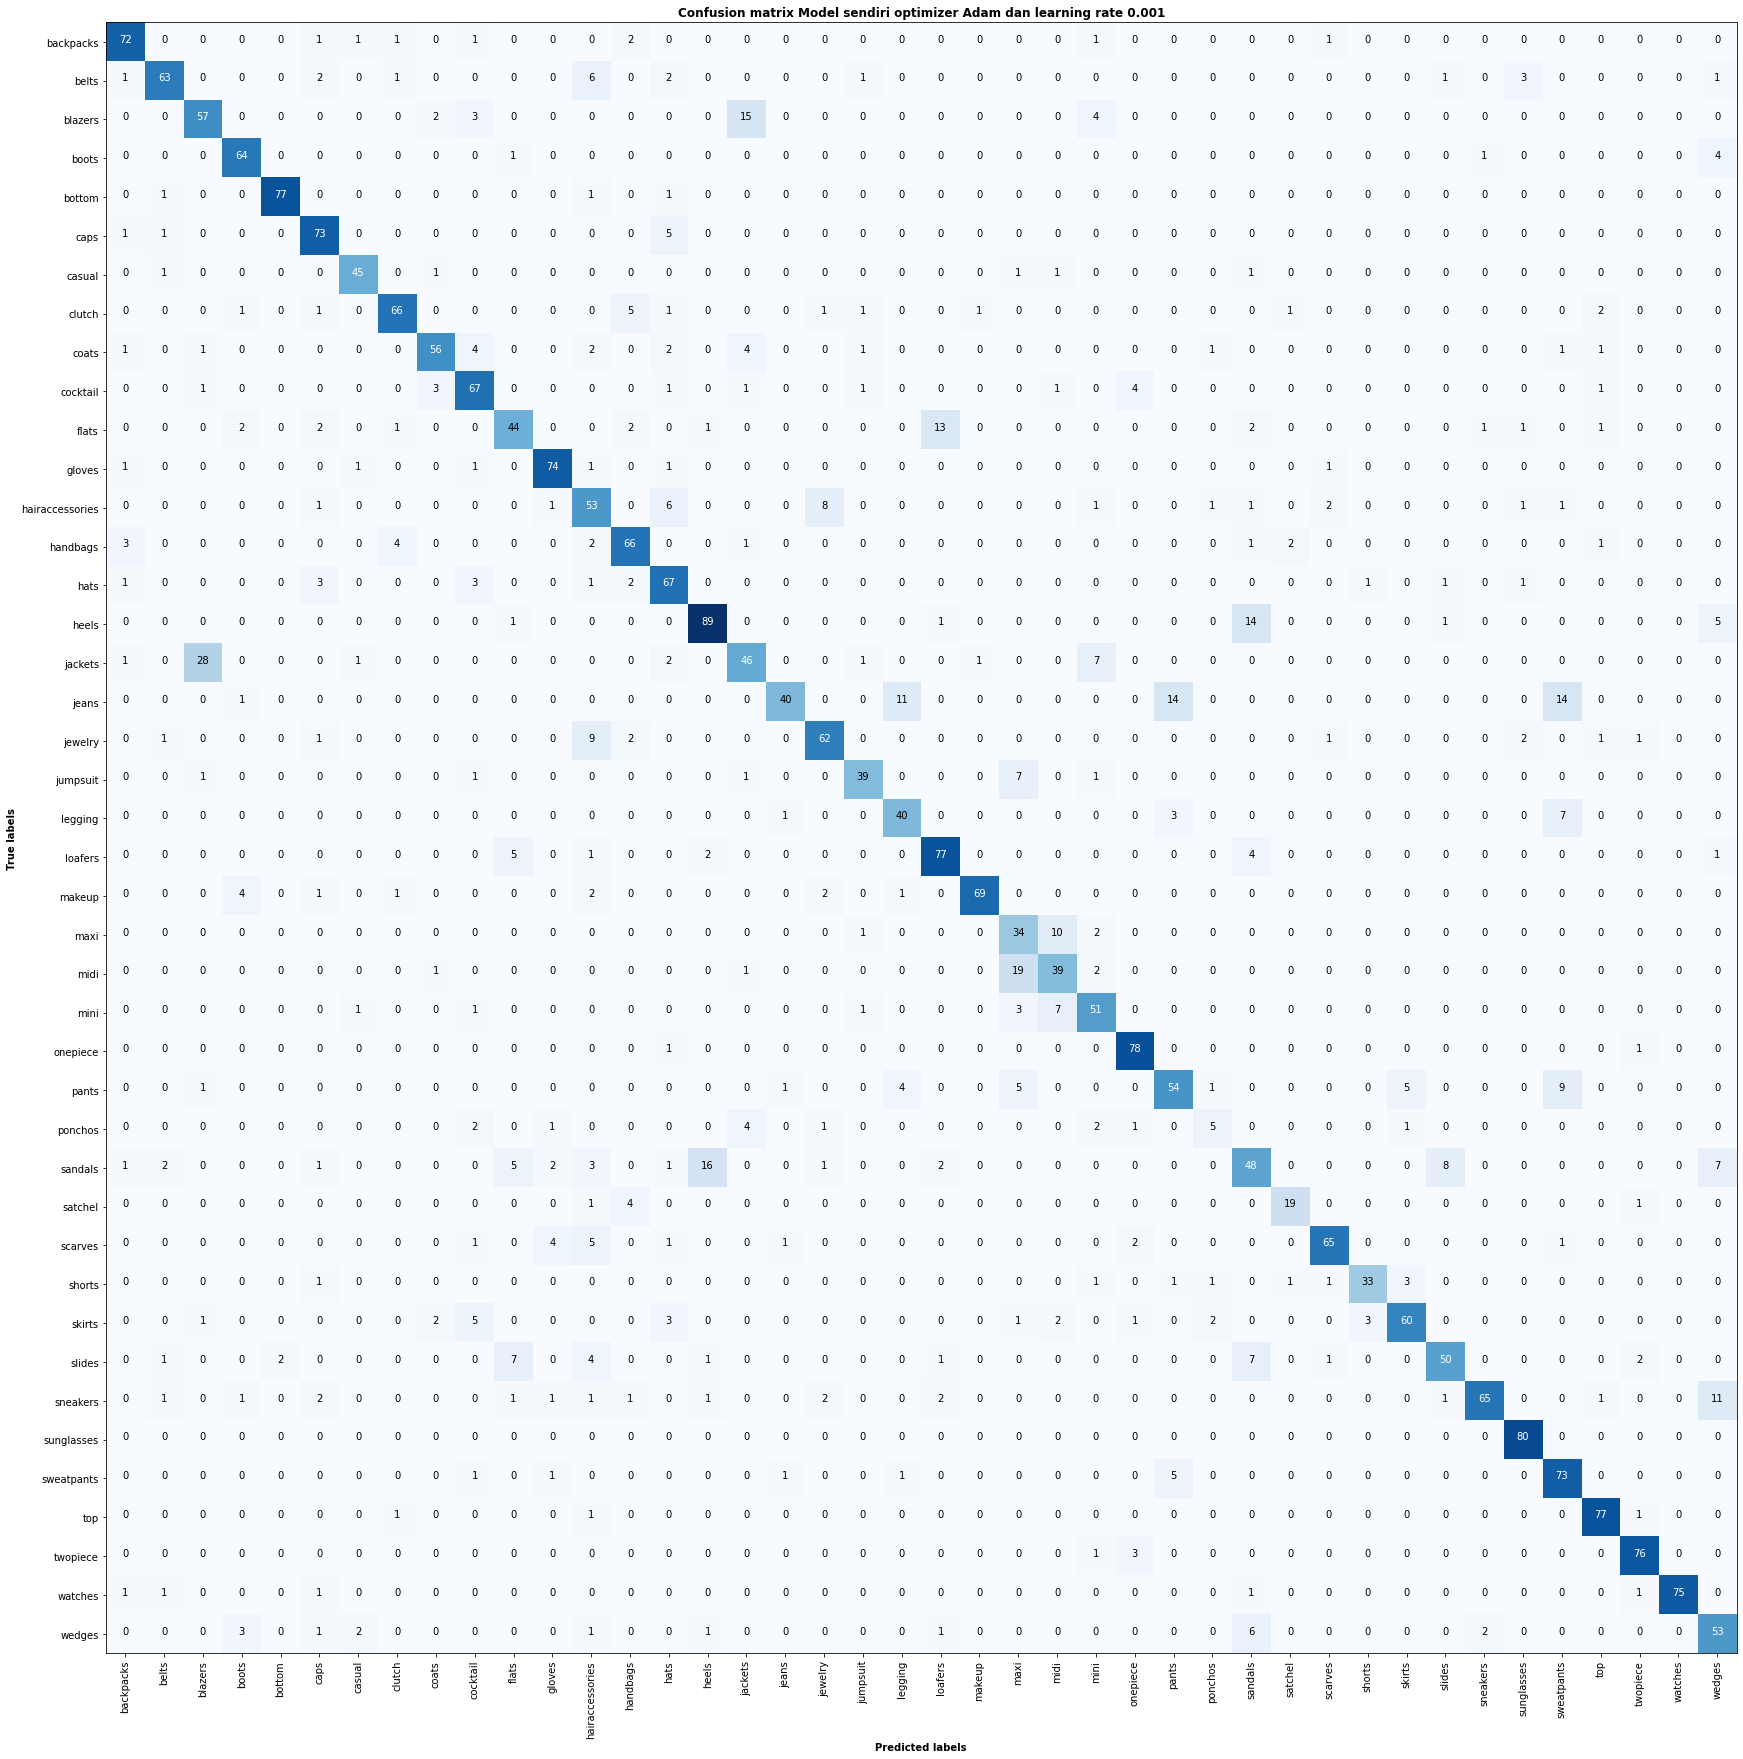

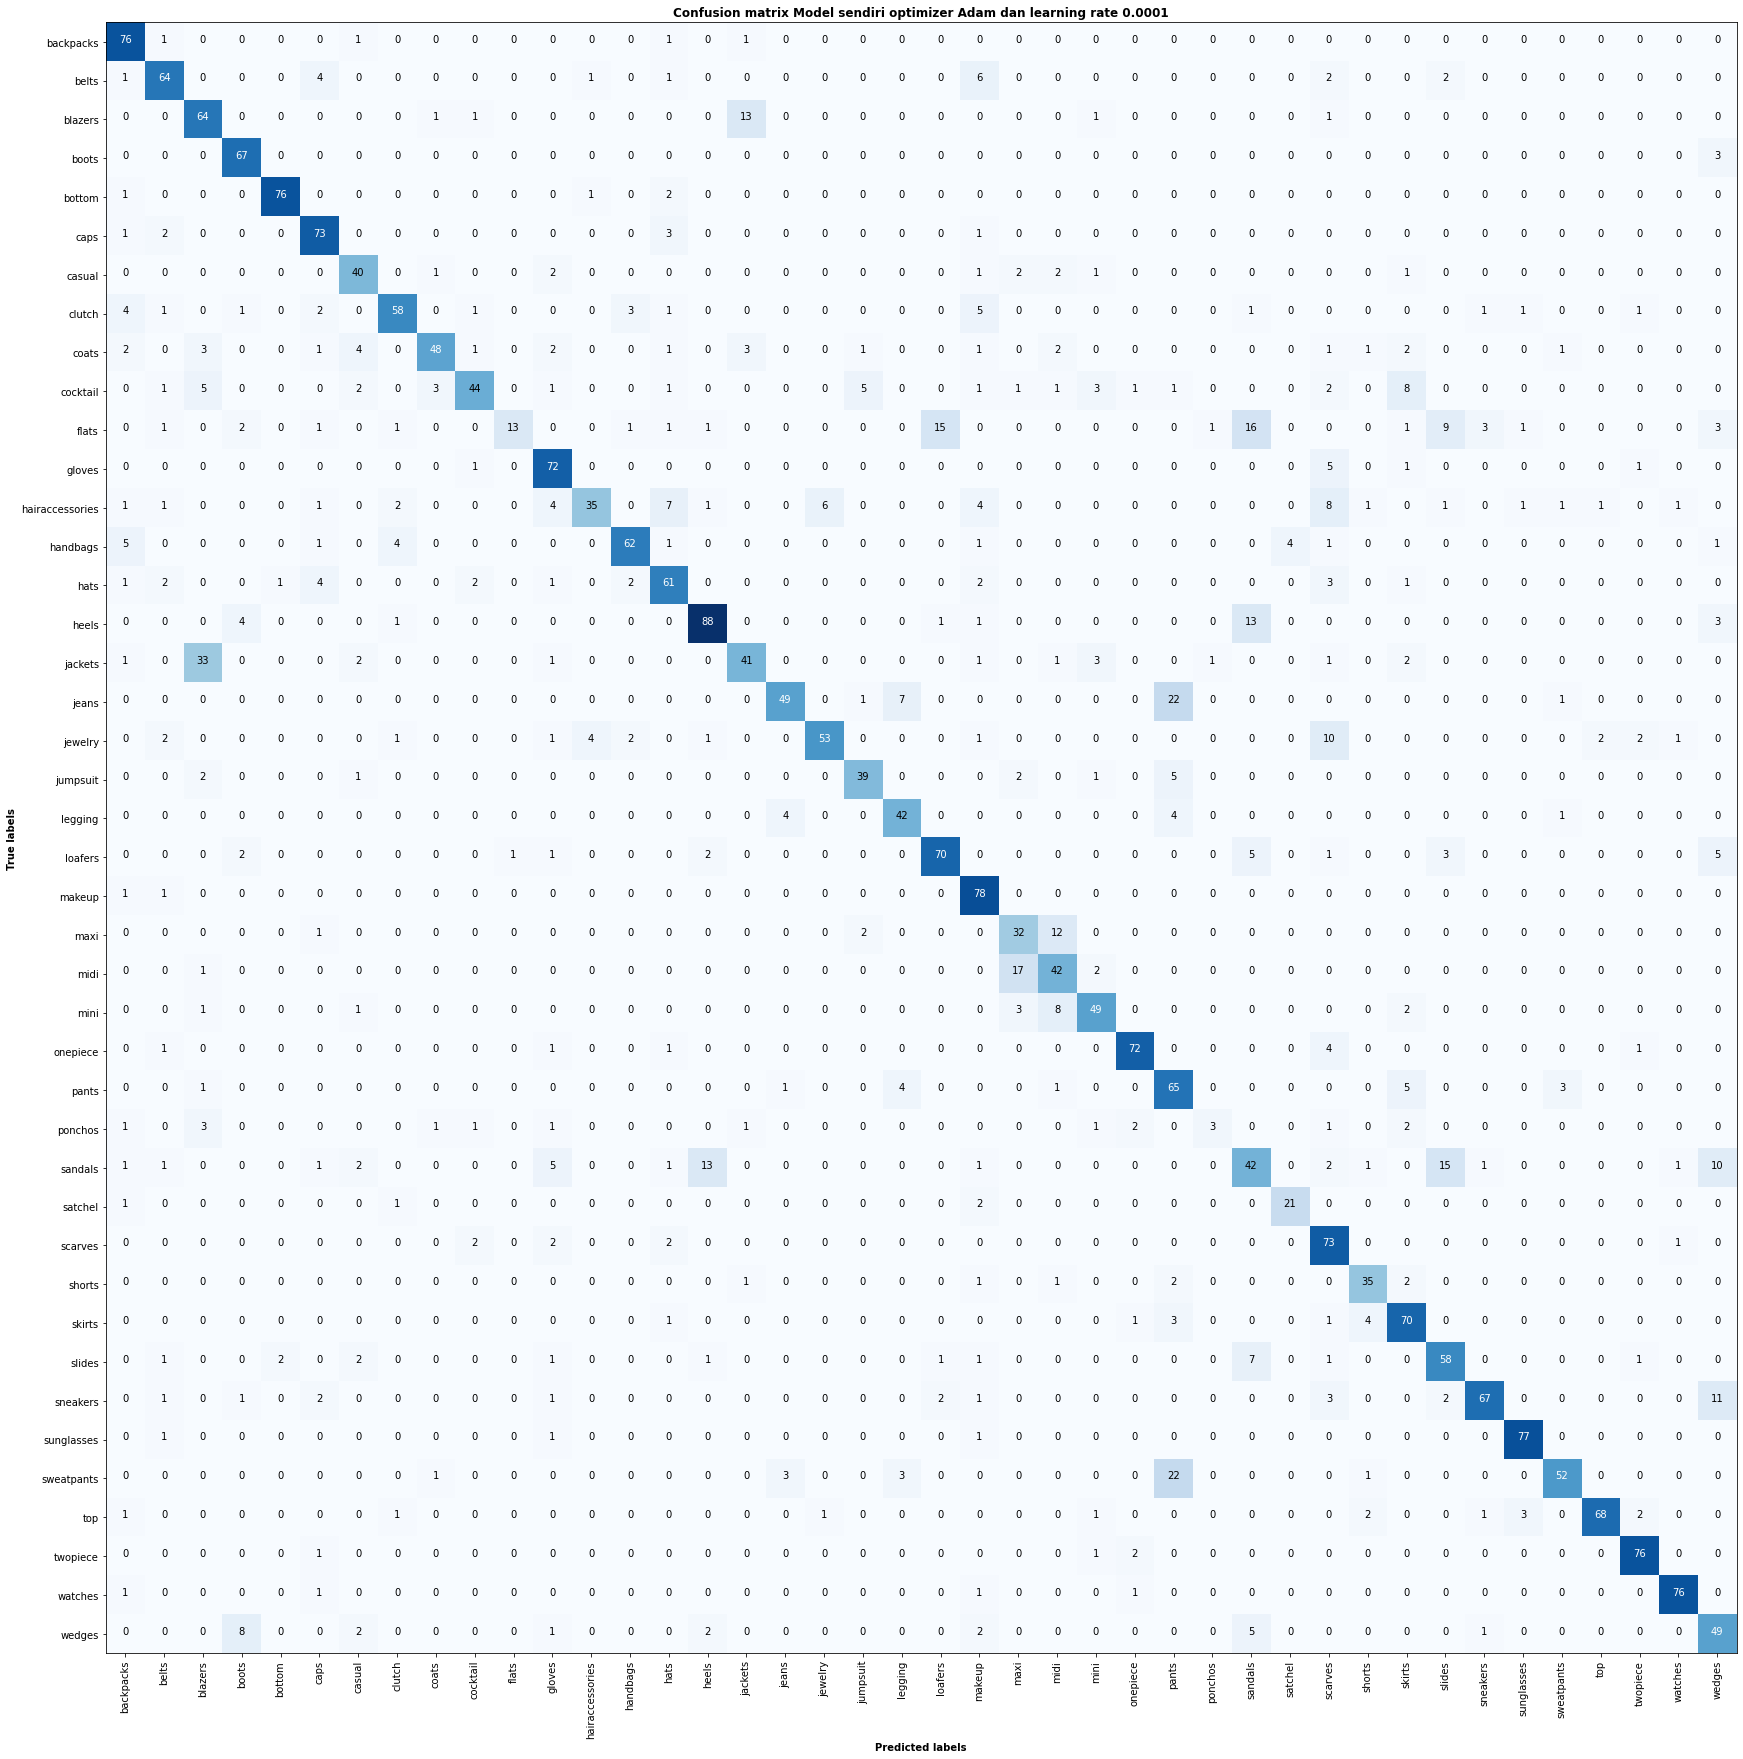

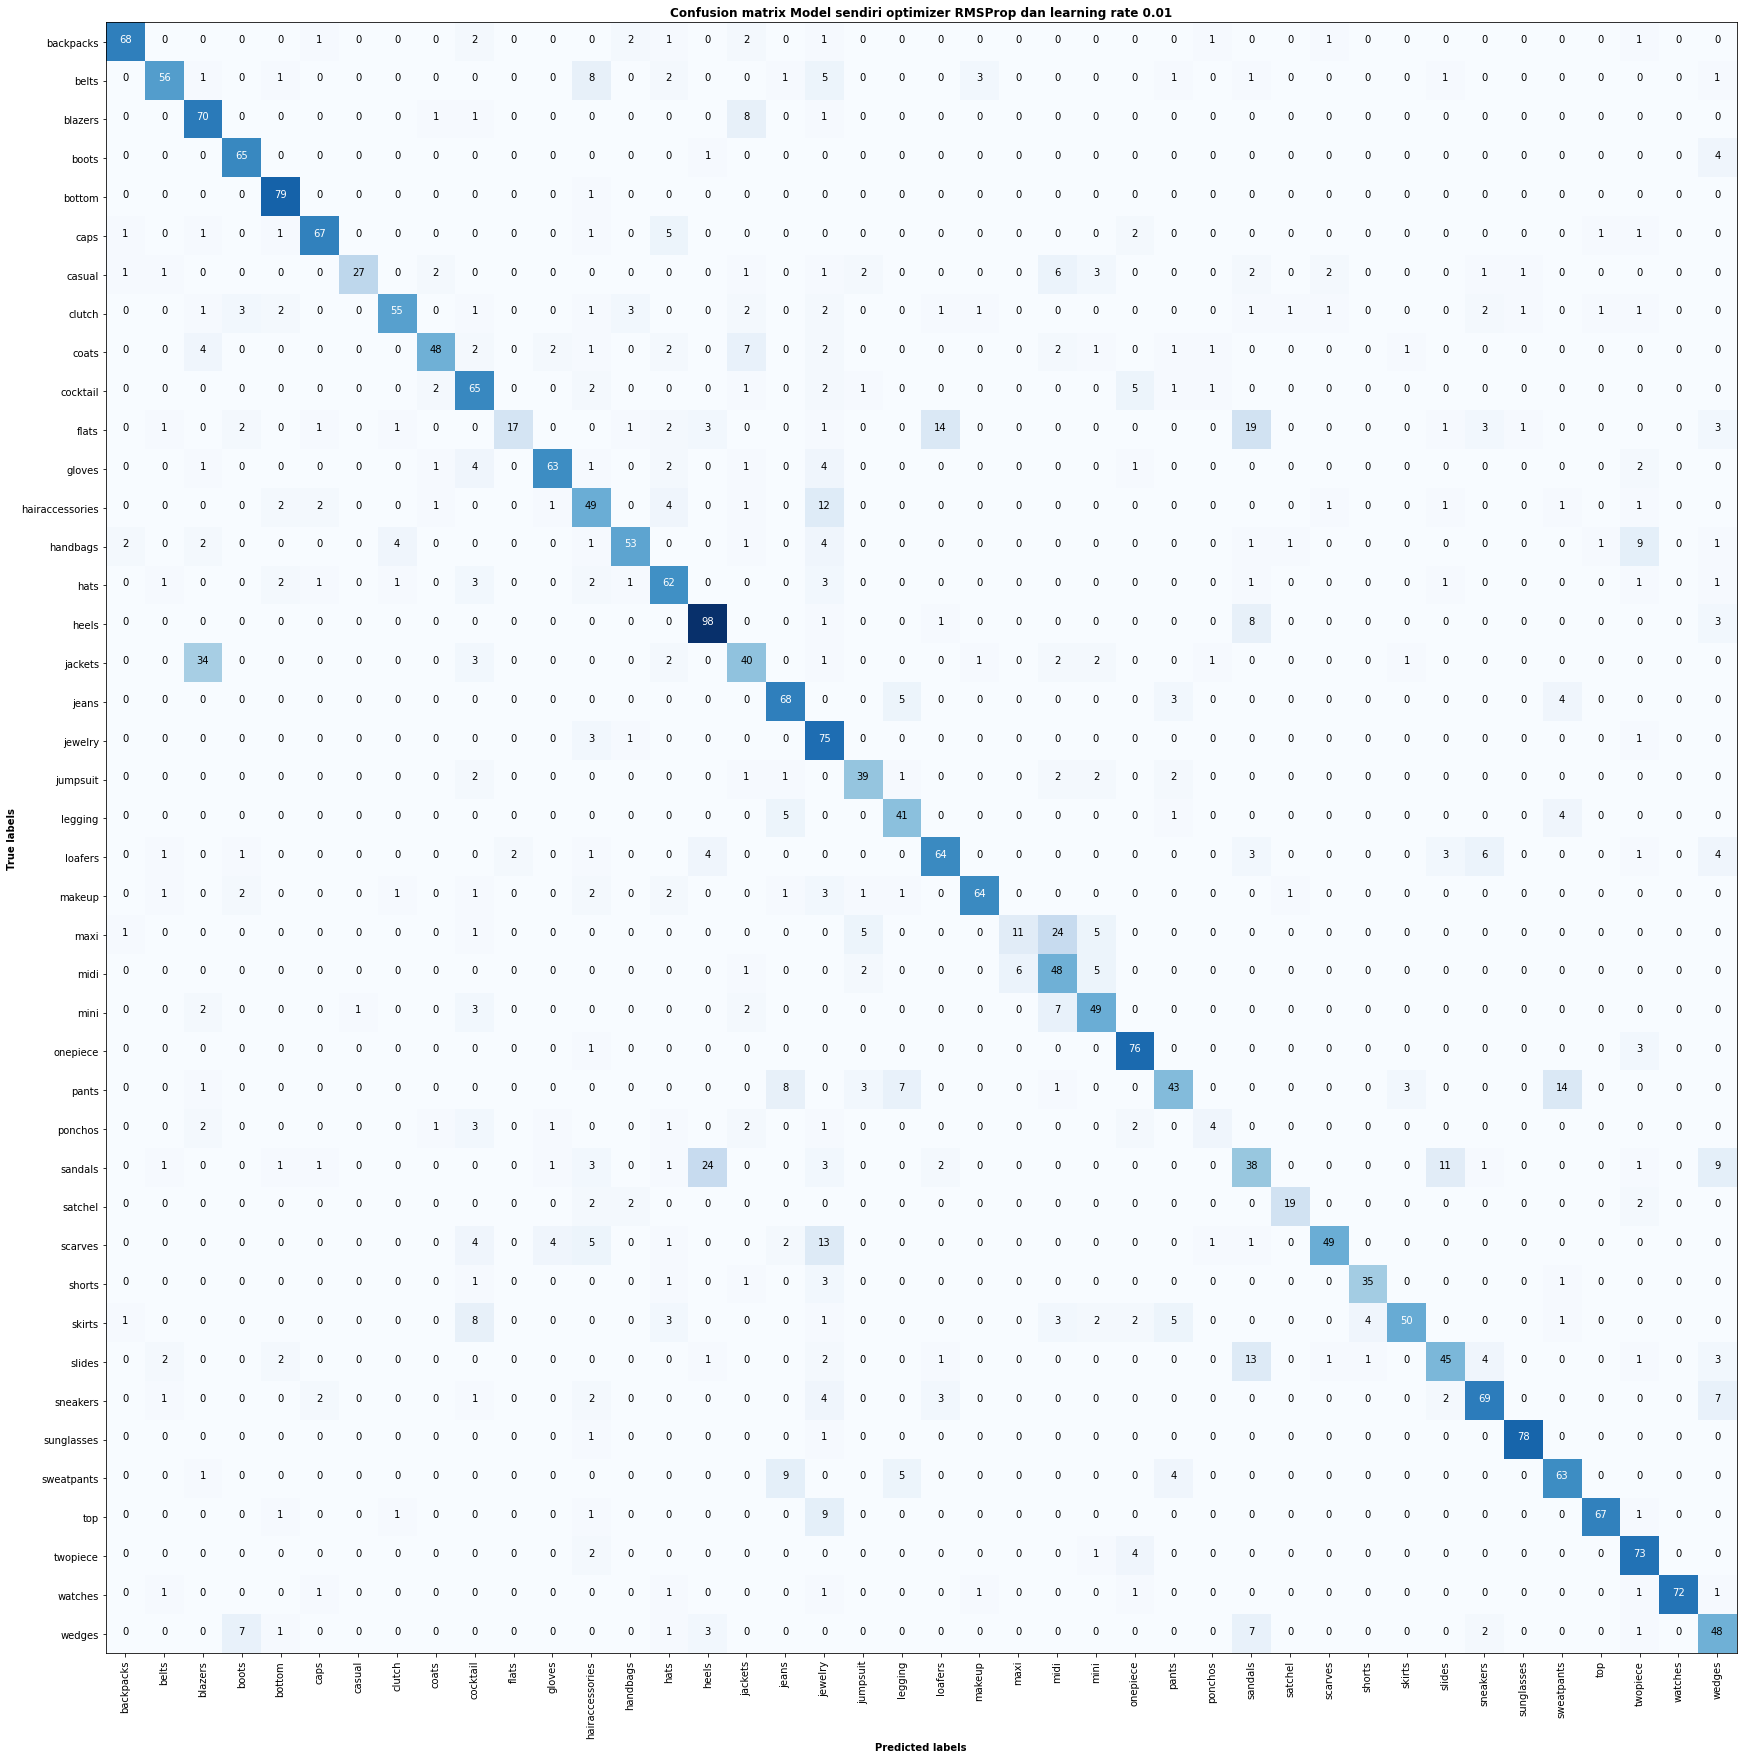

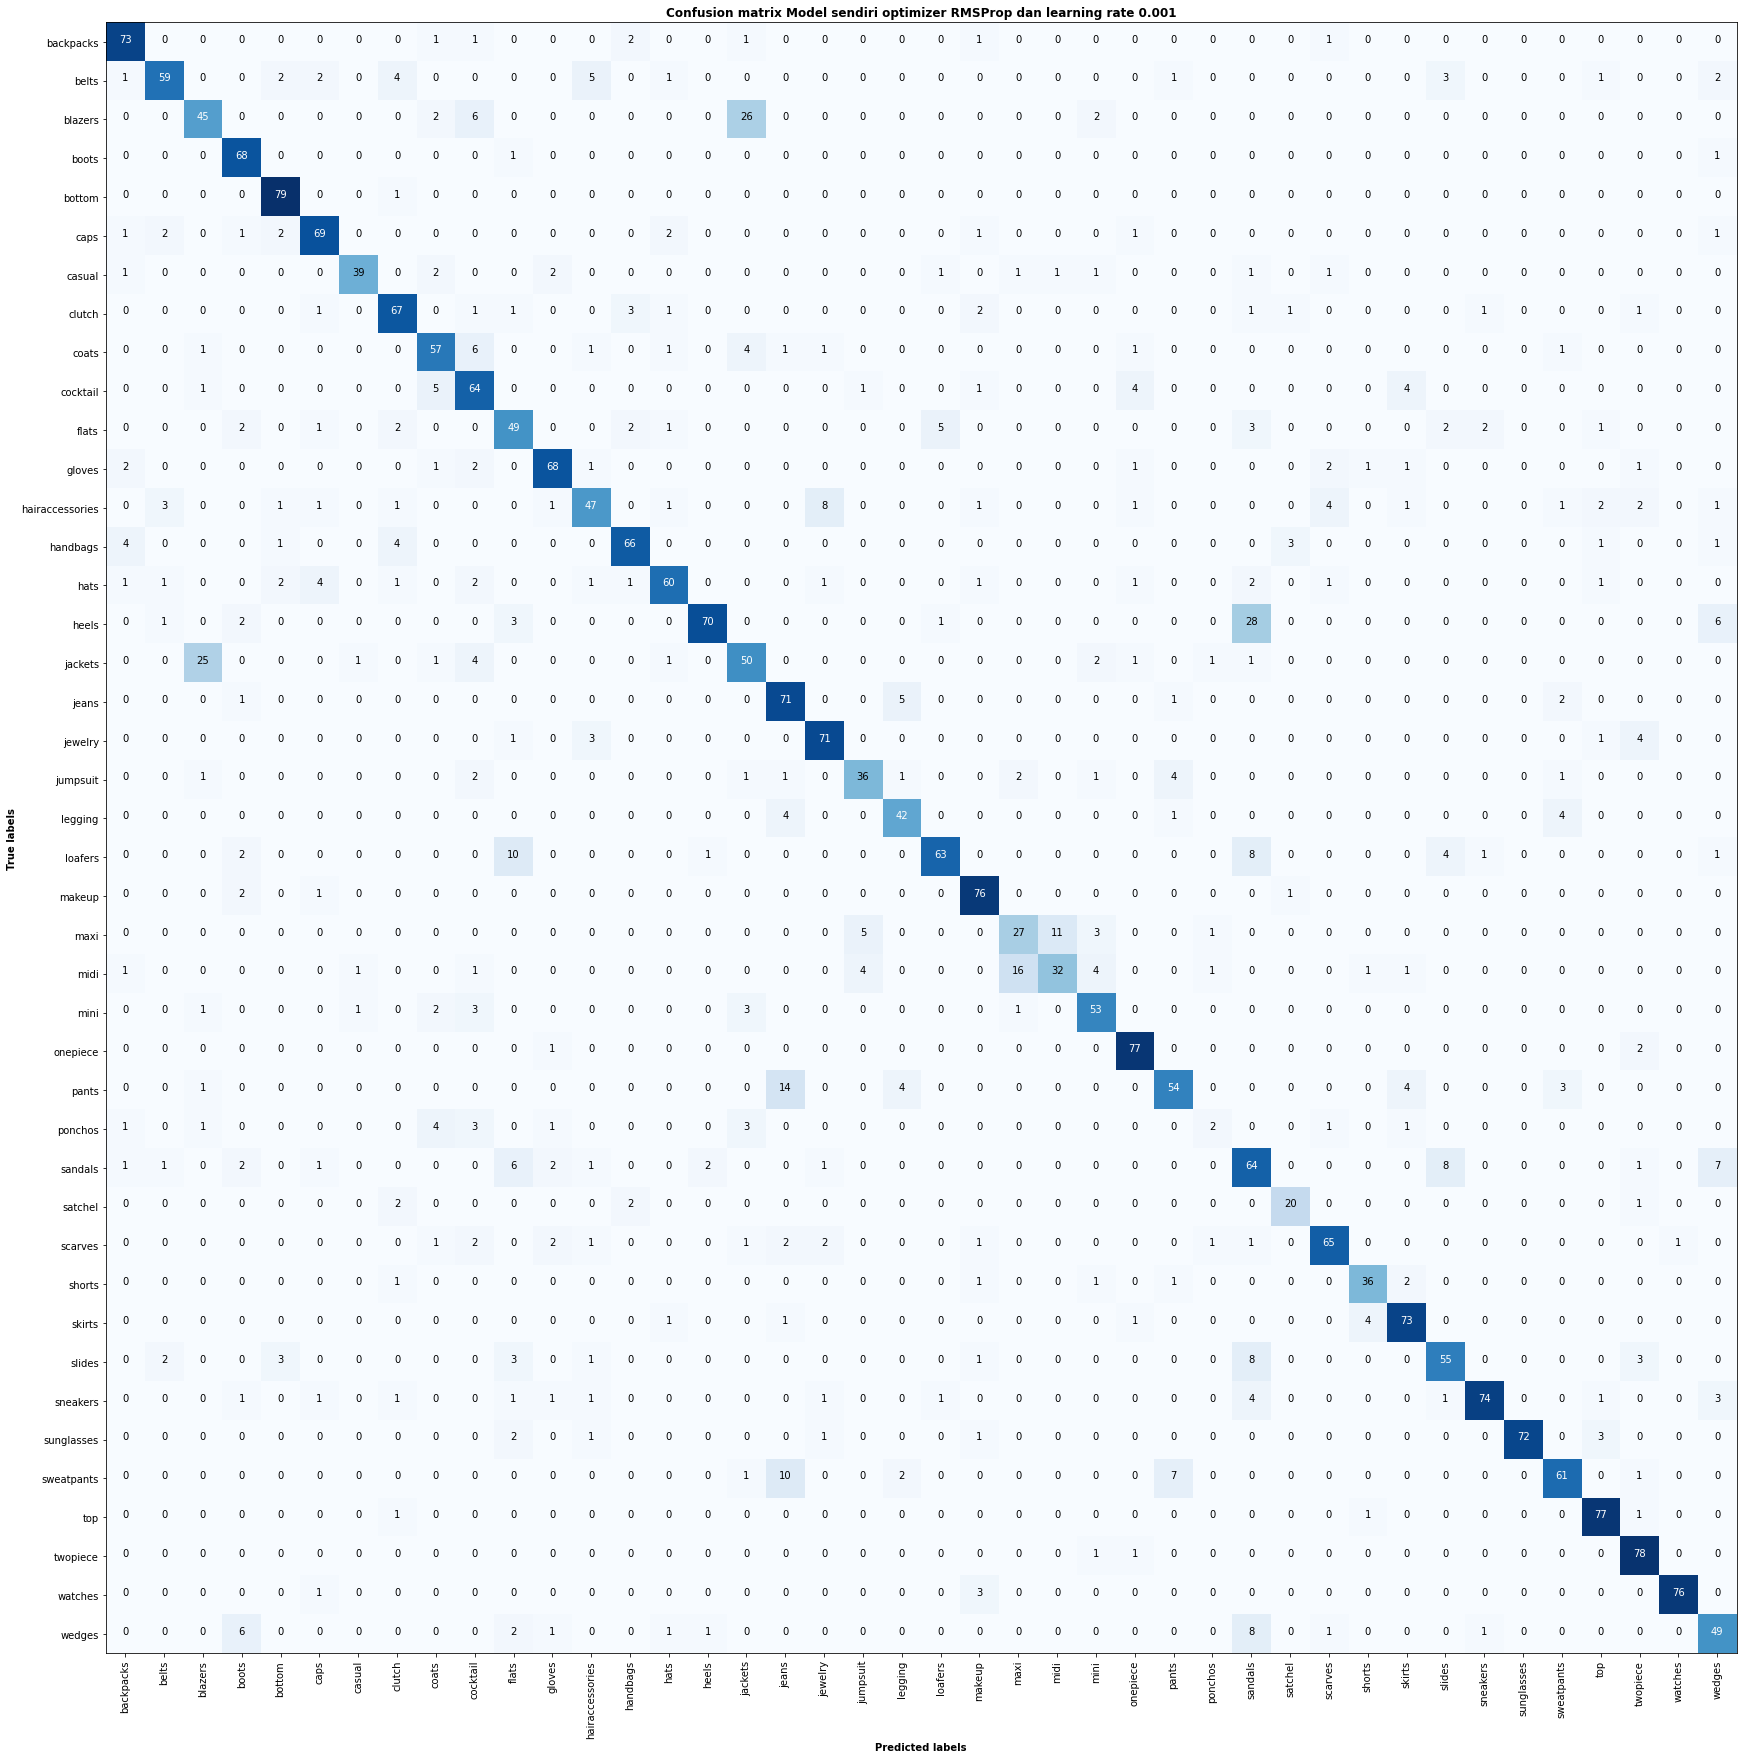

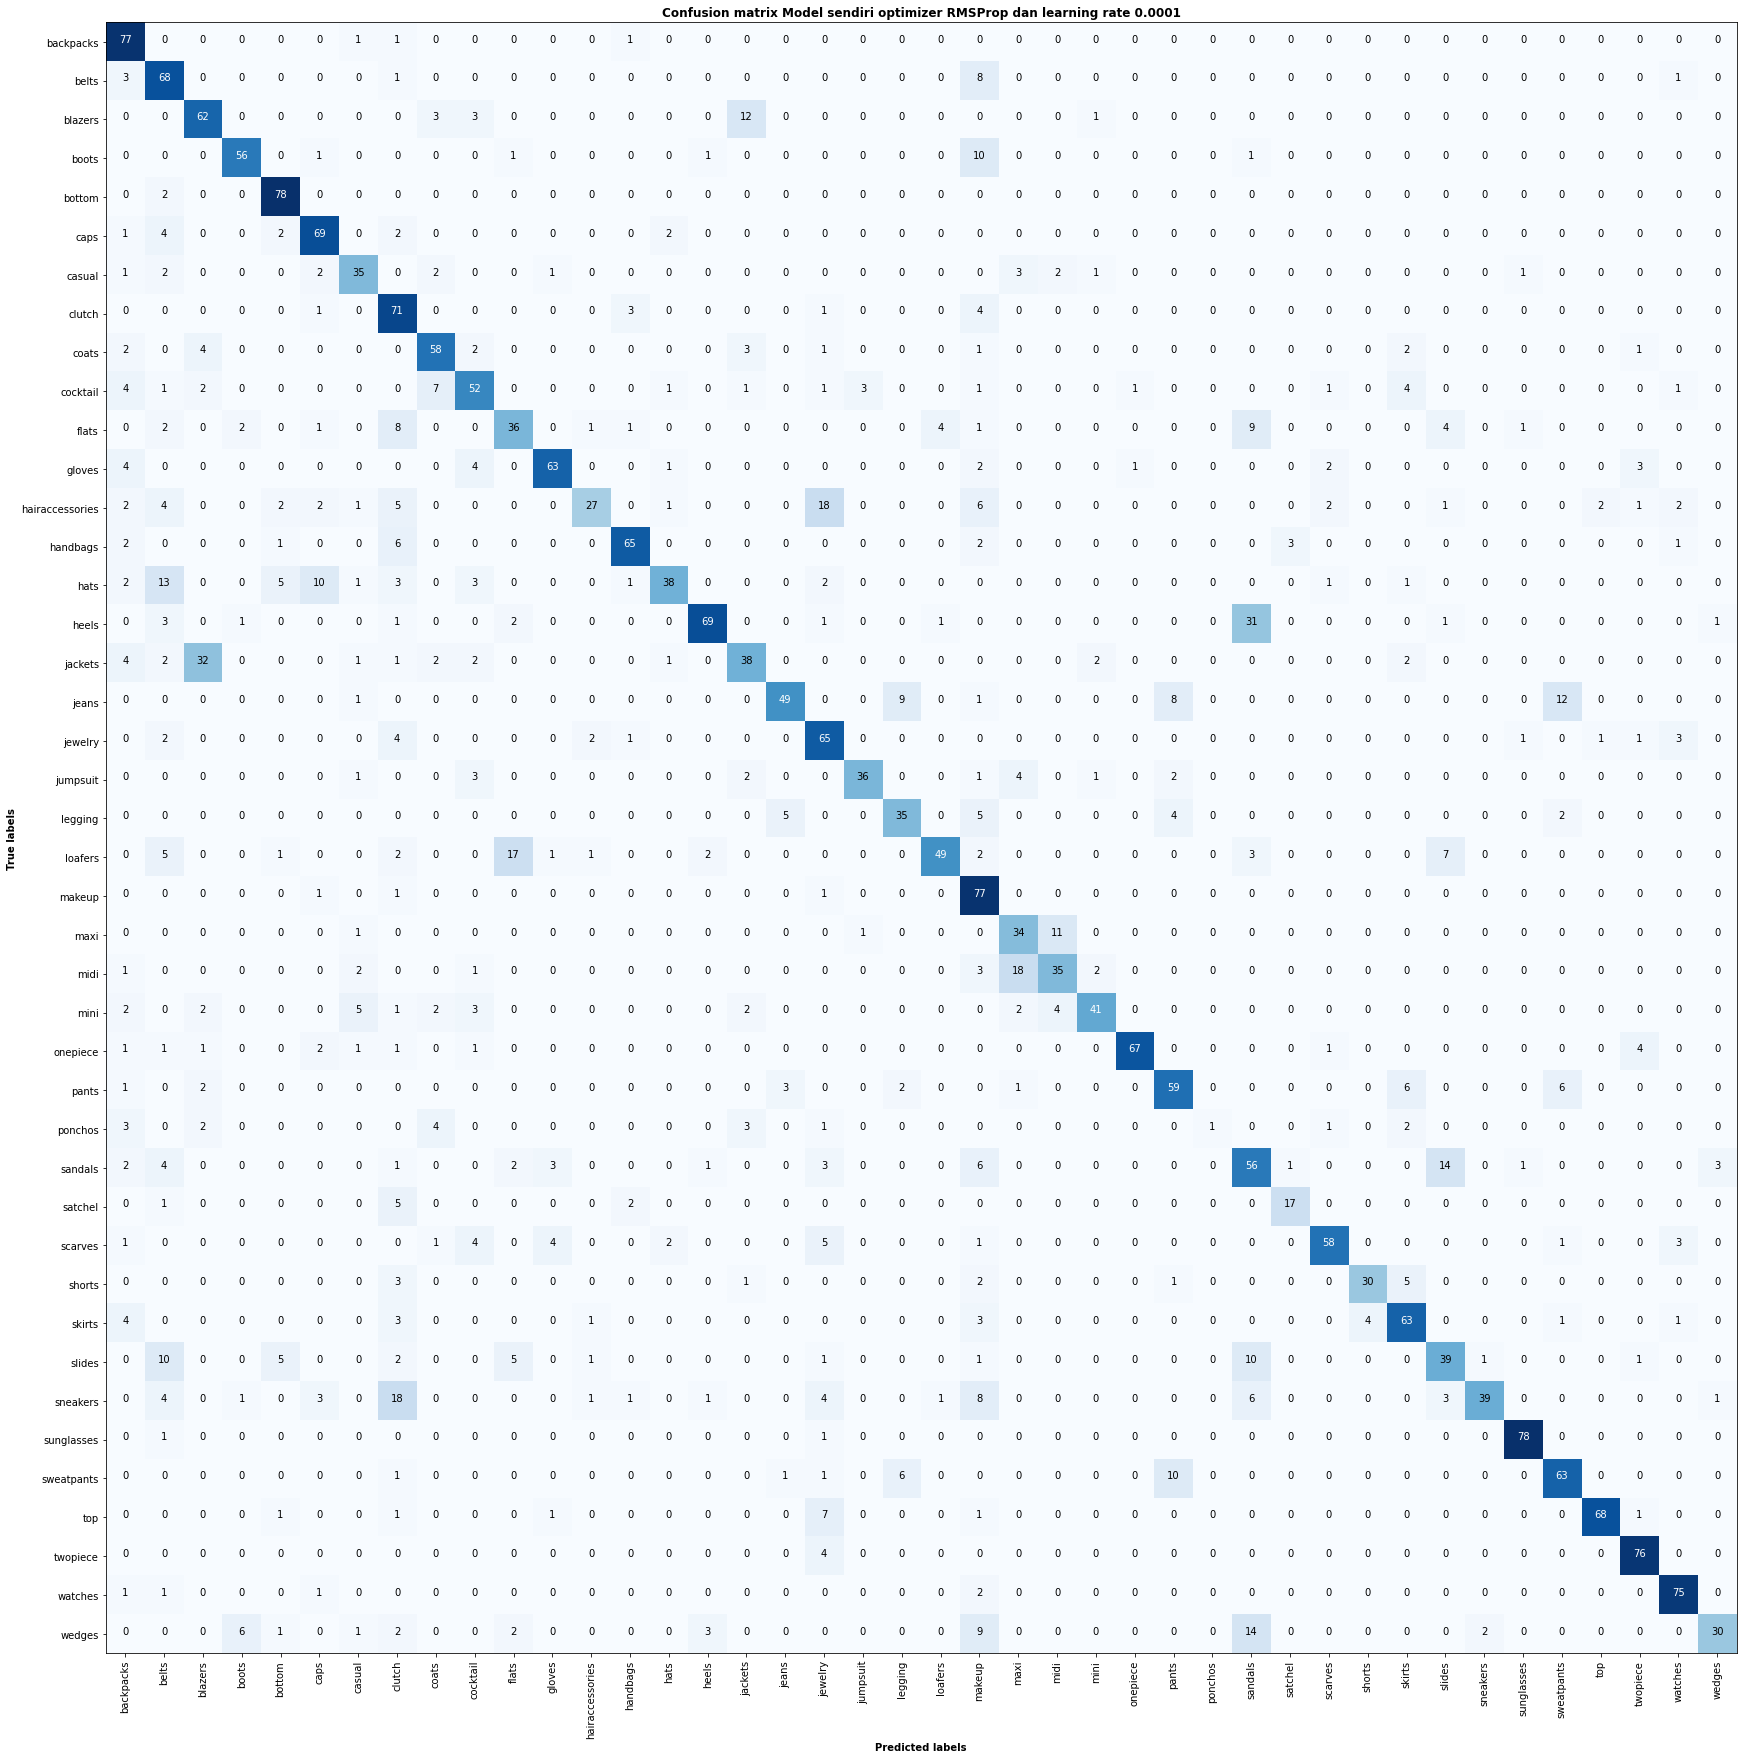

In [ ]:
# Visualisasi menggunakan confusion matrix
for (x, y, z) in (zip(res_predict, opt, lr)):
  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  plot_confusion_matrix(confusion_matrix(true_classes, preds), class_labels, f"Model sendiri optimizer {y} dan learning rate {z}")